In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [9]:
# 1. Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

Using device: NVIDIA GeForce RTX 2070 SUPER


In [10]:
# 2. Load FashionMNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=4, pin_memory=True)

# Class names for FashionMNIST
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [11]:
# 3. Define CNN Model with Configurable Kernel and Pooling
class CNN(nn.Module):
    def __init__(self, kernel_size=3, pooling_type="max"):
        super(CNN, self).__init__()
        pooling_layer = nn.MaxPool2d if pooling_type == "max" else nn.AvgPool2d

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            pooling_layer(2, 2),
            nn.Conv2d(32, 64, kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            pooling_layer(2, 2),
            nn.Conv2d(64, 128, kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            pooling_layer(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [12]:
# 4. Define Training and Testing Functions
from torch.amp import GradScaler, autocast

scaler = GradScaler(device="cuda")

def train_model(model, criterion, optimizer, train_loader, scheduler=None):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        with autocast(device_type='cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
    if scheduler:
        scheduler.step()
    return running_loss / len(train_loader)

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [13]:
# 5. Experiment Configurations
kernel_sizes = [3, 5, 7]
pooling_types = ["max", "avg"]
num_epochs_list = [5, 50, 100, 250, 350]
optimizers = {"SGD": optim.SGD, "RMSProp": optim.RMSprop, "Adam": optim.Adam}

# Store Results
results = {}

In [14]:
# 6. Experiment Loop
for kernel_size in kernel_sizes:
    for pooling_type in pooling_types:
        for opt_name, opt_class in optimizers.items():
            print(f"Kernel: {kernel_size}, Pooling: {pooling_type}, Optimizer: {opt_name}")
            
            # Initialize model, loss function, and optimizer
            model = CNN(kernel_size=kernel_size, pooling_type=pooling_type).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = opt_class(model.parameters(), lr=0.001)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

            epoch_accuracies = []

            for num_epochs in num_epochs_list:
                print(f"Training for {num_epochs} epochs")

                # Early Stopping Setup
                early_stop_counter = 0
                best_accuracy = 0
                patience = 5

                for epoch in range(num_epochs):
                    train_loss = train_model(model, criterion, optimizer, train_loader, scheduler)
                    test_accuracy = evaluate_model(model, test_loader)

                    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {train_loss:.4f}, Accuracy: {test_accuracy:.4f}")

                    if test_accuracy > best_accuracy:
                        best_accuracy = test_accuracy
                        early_stop_counter = 0
                    else:
                        early_stop_counter += 1

                    if early_stop_counter >= patience:
                        print("Early stopping triggered.")
                        break

                epoch_accuracies.append(best_accuracy)

            results[(kernel_size, pooling_type, opt_name)] = epoch_accuracies

Kernel: 3, Pooling: max, Optimizer: SGD
Training for 5 epochs


100%|██████████| 59/59 [00:07<00:00,  7.81it/s]


Epoch 1/5 - Loss: 2.3024, Accuracy: 0.1131


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch 2/5 - Loss: 2.3009, Accuracy: 0.1140


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 3/5 - Loss: 2.2994, Accuracy: 0.1153


100%|██████████| 59/59 [00:06<00:00,  8.70it/s]


Epoch 4/5 - Loss: 2.2980, Accuracy: 0.1156


100%|██████████| 59/59 [00:07<00:00,  8.07it/s]


Epoch 5/5 - Loss: 2.2965, Accuracy: 0.1154
Training for 50 epochs


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Epoch 1/50 - Loss: 2.2951, Accuracy: 0.1157


100%|██████████| 59/59 [00:07<00:00,  8.16it/s]


Epoch 2/50 - Loss: 2.2936, Accuracy: 0.1193


100%|██████████| 59/59 [00:07<00:00,  7.93it/s]


Epoch 3/50 - Loss: 2.2921, Accuracy: 0.1265


100%|██████████| 59/59 [00:07<00:00,  8.32it/s]


Epoch 4/50 - Loss: 2.2906, Accuracy: 0.1380


100%|██████████| 59/59 [00:08<00:00,  6.75it/s]


Epoch 5/50 - Loss: 2.2891, Accuracy: 0.1548


100%|██████████| 59/59 [00:07<00:00,  8.20it/s]


Epoch 6/50 - Loss: 2.2875, Accuracy: 0.1757


100%|██████████| 59/59 [00:07<00:00,  8.25it/s]


Epoch 7/50 - Loss: 2.2860, Accuracy: 0.1995


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 8/50 - Loss: 2.2843, Accuracy: 0.2273


100%|██████████| 59/59 [00:06<00:00,  8.69it/s]


Epoch 9/50 - Loss: 2.2827, Accuracy: 0.2576


100%|██████████| 59/59 [00:06<00:00,  8.64it/s]


Epoch 10/50 - Loss: 2.2810, Accuracy: 0.2833


100%|██████████| 59/59 [00:06<00:00,  8.74it/s]


Epoch 11/50 - Loss: 2.2792, Accuracy: 0.3102


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 12/50 - Loss: 2.2773, Accuracy: 0.3326


100%|██████████| 59/59 [00:06<00:00,  8.73it/s]


Epoch 13/50 - Loss: 2.2754, Accuracy: 0.3534


100%|██████████| 59/59 [00:06<00:00,  8.68it/s]


Epoch 14/50 - Loss: 2.2733, Accuracy: 0.3702


100%|██████████| 59/59 [00:07<00:00,  8.32it/s]


Epoch 15/50 - Loss: 2.2712, Accuracy: 0.3854


100%|██████████| 59/59 [00:11<00:00,  5.35it/s]


Epoch 16/50 - Loss: 2.2690, Accuracy: 0.3979


100%|██████████| 59/59 [00:07<00:00,  7.72it/s]


Epoch 17/50 - Loss: 2.2666, Accuracy: 0.4078


100%|██████████| 59/59 [00:08<00:00,  6.85it/s]


Epoch 18/50 - Loss: 2.2641, Accuracy: 0.4161


100%|██████████| 59/59 [00:07<00:00,  8.21it/s]


Epoch 19/50 - Loss: 2.2614, Accuracy: 0.4228


100%|██████████| 59/59 [00:07<00:00,  8.08it/s]


Epoch 20/50 - Loss: 2.2587, Accuracy: 0.4271


100%|██████████| 59/59 [00:07<00:00,  7.62it/s]


Epoch 21/50 - Loss: 2.2557, Accuracy: 0.4313


100%|██████████| 59/59 [00:08<00:00,  7.24it/s]


Epoch 22/50 - Loss: 2.2525, Accuracy: 0.4324


100%|██████████| 59/59 [00:07<00:00,  7.45it/s]


Epoch 23/50 - Loss: 2.2491, Accuracy: 0.4355


100%|██████████| 59/59 [00:08<00:00,  7.36it/s]


Epoch 24/50 - Loss: 2.2455, Accuracy: 0.4374


100%|██████████| 59/59 [00:07<00:00,  7.71it/s]


Epoch 25/50 - Loss: 2.2416, Accuracy: 0.4409


100%|██████████| 59/59 [00:07<00:00,  7.41it/s]


Epoch 26/50 - Loss: 2.2373, Accuracy: 0.4420


100%|██████████| 59/59 [00:07<00:00,  7.43it/s]


Epoch 27/50 - Loss: 2.2327, Accuracy: 0.4440


100%|██████████| 59/59 [00:08<00:00,  7.09it/s]


Epoch 28/50 - Loss: 2.2278, Accuracy: 0.4448


100%|██████████| 59/59 [00:07<00:00,  7.57it/s]


Epoch 29/50 - Loss: 2.2223, Accuracy: 0.4466


100%|██████████| 59/59 [00:07<00:00,  7.76it/s]


Epoch 30/50 - Loss: 2.2164, Accuracy: 0.4475


100%|██████████| 59/59 [00:07<00:00,  7.71it/s]


Epoch 31/50 - Loss: 2.2100, Accuracy: 0.4470


100%|██████████| 59/59 [00:07<00:00,  8.02it/s]


Epoch 32/50 - Loss: 2.2029, Accuracy: 0.4483


100%|██████████| 59/59 [00:07<00:00,  7.65it/s]


Epoch 33/50 - Loss: 2.1951, Accuracy: 0.4494


100%|██████████| 59/59 [00:07<00:00,  8.02it/s]


Epoch 34/50 - Loss: 2.1865, Accuracy: 0.4502


100%|██████████| 59/59 [00:07<00:00,  7.66it/s]


Epoch 35/50 - Loss: 2.1771, Accuracy: 0.4502


100%|██████████| 59/59 [00:07<00:00,  7.98it/s]


Epoch 36/50 - Loss: 2.1668, Accuracy: 0.4518


100%|██████████| 59/59 [00:08<00:00,  7.12it/s]


Epoch 37/50 - Loss: 2.1553, Accuracy: 0.4524


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Epoch 38/50 - Loss: 2.1425, Accuracy: 0.4534


100%|██████████| 59/59 [00:07<00:00,  7.75it/s]


Epoch 39/50 - Loss: 2.1283, Accuracy: 0.4537


100%|██████████| 59/59 [00:07<00:00,  7.68it/s]


Epoch 40/50 - Loss: 2.1124, Accuracy: 0.4565


100%|██████████| 59/59 [00:07<00:00,  8.08it/s]


Epoch 41/50 - Loss: 2.0946, Accuracy: 0.4570


100%|██████████| 59/59 [00:07<00:00,  7.54it/s]


Epoch 42/50 - Loss: 2.0748, Accuracy: 0.4593


100%|██████████| 59/59 [00:07<00:00,  7.86it/s]


Epoch 43/50 - Loss: 2.0527, Accuracy: 0.4610


100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch 44/50 - Loss: 2.0278, Accuracy: 0.4631


100%|██████████| 59/59 [00:08<00:00,  7.19it/s]


Epoch 45/50 - Loss: 2.0002, Accuracy: 0.4663


100%|██████████| 59/59 [00:07<00:00,  7.56it/s]


Epoch 46/50 - Loss: 1.9836, Accuracy: 0.4664


100%|██████████| 59/59 [00:07<00:00,  7.57it/s]


Epoch 47/50 - Loss: 1.9804, Accuracy: 0.4665


100%|██████████| 59/59 [00:07<00:00,  8.13it/s]


Epoch 48/50 - Loss: 1.9773, Accuracy: 0.4669


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Epoch 49/50 - Loss: 1.9743, Accuracy: 0.4674


100%|██████████| 59/59 [00:07<00:00,  8.20it/s]


Epoch 50/50 - Loss: 1.9709, Accuracy: 0.4675
Training for 100 epochs


100%|██████████| 59/59 [00:07<00:00,  8.37it/s]


Epoch 1/100 - Loss: 1.9677, Accuracy: 0.4677


100%|██████████| 59/59 [00:07<00:00,  7.71it/s]


Epoch 2/100 - Loss: 1.9644, Accuracy: 0.4678


100%|██████████| 59/59 [00:07<00:00,  8.24it/s]


Epoch 3/100 - Loss: 1.9612, Accuracy: 0.4678


100%|██████████| 59/59 [00:07<00:00,  8.20it/s]


Epoch 4/100 - Loss: 1.9579, Accuracy: 0.4682


100%|██████████| 59/59 [00:07<00:00,  8.32it/s]


Epoch 5/100 - Loss: 1.9545, Accuracy: 0.4684


100%|██████████| 59/59 [00:07<00:00,  8.00it/s]


Epoch 6/100 - Loss: 1.9510, Accuracy: 0.4694


100%|██████████| 59/59 [00:07<00:00,  8.24it/s]


Epoch 7/100 - Loss: 1.9474, Accuracy: 0.4698


100%|██████████| 59/59 [00:07<00:00,  8.26it/s]


Epoch 8/100 - Loss: 1.9441, Accuracy: 0.4701


100%|██████████| 59/59 [00:07<00:00,  7.39it/s]


Epoch 9/100 - Loss: 1.9407, Accuracy: 0.4704


100%|██████████| 59/59 [00:07<00:00,  8.15it/s]


Epoch 10/100 - Loss: 1.9371, Accuracy: 0.4709


100%|██████████| 59/59 [00:07<00:00,  8.22it/s]


Epoch 11/100 - Loss: 1.9336, Accuracy: 0.4715


100%|██████████| 59/59 [00:07<00:00,  8.35it/s]


Epoch 12/100 - Loss: 1.9301, Accuracy: 0.4722


100%|██████████| 59/59 [00:07<00:00,  7.99it/s]


Epoch 13/100 - Loss: 1.9262, Accuracy: 0.4727


100%|██████████| 59/59 [00:07<00:00,  8.21it/s]


Epoch 14/100 - Loss: 1.9227, Accuracy: 0.4738


100%|██████████| 59/59 [00:07<00:00,  8.13it/s]


Epoch 15/100 - Loss: 1.9190, Accuracy: 0.4739


100%|██████████| 59/59 [00:08<00:00,  7.28it/s]


Epoch 16/100 - Loss: 1.9150, Accuracy: 0.4739


100%|██████████| 59/59 [00:08<00:00,  6.98it/s]


Epoch 17/100 - Loss: 1.9113, Accuracy: 0.4747


100%|██████████| 59/59 [00:07<00:00,  8.25it/s]


Epoch 18/100 - Loss: 1.9076, Accuracy: 0.4756


100%|██████████| 59/59 [00:07<00:00,  7.92it/s]


Epoch 19/100 - Loss: 1.9037, Accuracy: 0.4761


100%|██████████| 59/59 [00:07<00:00,  7.99it/s]


Epoch 20/100 - Loss: 1.8998, Accuracy: 0.4766


100%|██████████| 59/59 [00:07<00:00,  8.32it/s]


Epoch 21/100 - Loss: 1.8958, Accuracy: 0.4768


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 22/100 - Loss: 1.8921, Accuracy: 0.4774


100%|██████████| 59/59 [00:07<00:00,  8.35it/s]


Epoch 23/100 - Loss: 1.8882, Accuracy: 0.4772


100%|██████████| 59/59 [00:07<00:00,  7.93it/s]


Epoch 24/100 - Loss: 1.8841, Accuracy: 0.4778


100%|██████████| 59/59 [00:07<00:00,  8.34it/s]


Epoch 25/100 - Loss: 1.8800, Accuracy: 0.4785


100%|██████████| 59/59 [00:06<00:00,  8.48it/s]


Epoch 26/100 - Loss: 1.8758, Accuracy: 0.4792


100%|██████████| 59/59 [00:06<00:00,  8.50it/s]


Epoch 27/100 - Loss: 1.8717, Accuracy: 0.4805


100%|██████████| 59/59 [00:07<00:00,  8.37it/s]


Epoch 28/100 - Loss: 1.8677, Accuracy: 0.4808


100%|██████████| 59/59 [00:07<00:00,  8.21it/s]


Epoch 29/100 - Loss: 1.8634, Accuracy: 0.4815


100%|██████████| 59/59 [00:07<00:00,  8.39it/s]


Epoch 30/100 - Loss: 1.8593, Accuracy: 0.4822


100%|██████████| 59/59 [00:07<00:00,  7.83it/s]


Epoch 31/100 - Loss: 1.8551, Accuracy: 0.4830


100%|██████████| 59/59 [00:07<00:00,  8.11it/s]


Epoch 32/100 - Loss: 1.8507, Accuracy: 0.4836


100%|██████████| 59/59 [00:07<00:00,  8.29it/s]


Epoch 33/100 - Loss: 1.8462, Accuracy: 0.4842


100%|██████████| 59/59 [00:07<00:00,  8.20it/s]


Epoch 34/100 - Loss: 1.8420, Accuracy: 0.4851


100%|██████████| 59/59 [00:07<00:00,  8.35it/s]


Epoch 35/100 - Loss: 1.8375, Accuracy: 0.4860


100%|██████████| 59/59 [00:07<00:00,  8.39it/s]


Epoch 36/100 - Loss: 1.8332, Accuracy: 0.4869


100%|██████████| 59/59 [00:07<00:00,  8.13it/s]


Epoch 37/100 - Loss: 1.8287, Accuracy: 0.4877


100%|██████████| 59/59 [00:07<00:00,  8.26it/s]


Epoch 38/100 - Loss: 1.8245, Accuracy: 0.4887


100%|██████████| 59/59 [00:07<00:00,  8.16it/s]


Epoch 39/100 - Loss: 1.8200, Accuracy: 0.4900


100%|██████████| 59/59 [00:07<00:00,  8.19it/s]


Epoch 40/100 - Loss: 1.8156, Accuracy: 0.4908


100%|██████████| 59/59 [00:07<00:00,  7.93it/s]


Epoch 41/100 - Loss: 1.8109, Accuracy: 0.4915


100%|██████████| 59/59 [00:07<00:00,  8.14it/s]


Epoch 42/100 - Loss: 1.8063, Accuracy: 0.4928


100%|██████████| 59/59 [00:07<00:00,  7.84it/s]


Epoch 43/100 - Loss: 1.8017, Accuracy: 0.4942


100%|██████████| 59/59 [00:07<00:00,  8.00it/s]


Epoch 44/100 - Loss: 1.7972, Accuracy: 0.4950


100%|██████████| 59/59 [00:07<00:00,  7.85it/s]


Epoch 45/100 - Loss: 1.7924, Accuracy: 0.4962


100%|██████████| 59/59 [00:07<00:00,  8.08it/s]


Epoch 46/100 - Loss: 1.7899, Accuracy: 0.4963


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 47/100 - Loss: 1.7893, Accuracy: 0.4963


100%|██████████| 59/59 [00:06<00:00,  8.48it/s]


Epoch 48/100 - Loss: 1.7888, Accuracy: 0.4966


100%|██████████| 59/59 [00:06<00:00,  8.53it/s]


Epoch 49/100 - Loss: 1.7884, Accuracy: 0.4968


100%|██████████| 59/59 [00:07<00:00,  8.35it/s]


Epoch 50/100 - Loss: 1.7880, Accuracy: 0.4968


100%|██████████| 59/59 [00:07<00:00,  8.25it/s]


Epoch 51/100 - Loss: 1.7874, Accuracy: 0.4971


100%|██████████| 59/59 [00:06<00:00,  8.53it/s]


Epoch 52/100 - Loss: 1.7868, Accuracy: 0.4971


100%|██████████| 59/59 [00:07<00:00,  8.35it/s]


Epoch 53/100 - Loss: 1.7865, Accuracy: 0.4971


100%|██████████| 59/59 [00:07<00:00,  8.31it/s]


Epoch 54/100 - Loss: 1.7862, Accuracy: 0.4973


100%|██████████| 59/59 [00:07<00:00,  8.32it/s]


Epoch 55/100 - Loss: 1.7855, Accuracy: 0.4973


100%|██████████| 59/59 [00:07<00:00,  8.20it/s]


Epoch 56/100 - Loss: 1.7852, Accuracy: 0.4974


100%|██████████| 59/59 [00:07<00:00,  8.22it/s]


Epoch 57/100 - Loss: 1.7847, Accuracy: 0.4977


100%|██████████| 59/59 [00:07<00:00,  8.23it/s]


Epoch 58/100 - Loss: 1.7841, Accuracy: 0.4978


100%|██████████| 59/59 [00:07<00:00,  8.25it/s]


Epoch 59/100 - Loss: 1.7837, Accuracy: 0.4979


100%|██████████| 59/59 [00:07<00:00,  8.28it/s]


Epoch 60/100 - Loss: 1.7834, Accuracy: 0.4979


100%|██████████| 59/59 [00:07<00:00,  7.99it/s]


Epoch 61/100 - Loss: 1.7828, Accuracy: 0.4976


100%|██████████| 59/59 [00:07<00:00,  8.25it/s]


Epoch 62/100 - Loss: 1.7823, Accuracy: 0.4980


100%|██████████| 59/59 [00:07<00:00,  8.29it/s]


Epoch 63/100 - Loss: 1.7818, Accuracy: 0.4980


100%|██████████| 59/59 [00:07<00:00,  8.23it/s]


Epoch 64/100 - Loss: 1.7814, Accuracy: 0.4980


100%|██████████| 59/59 [00:07<00:00,  8.42it/s]


Epoch 65/100 - Loss: 1.7808, Accuracy: 0.4982


100%|██████████| 59/59 [00:07<00:00,  8.18it/s]


Epoch 66/100 - Loss: 1.7803, Accuracy: 0.4982


100%|██████████| 59/59 [00:07<00:00,  8.21it/s]


Epoch 67/100 - Loss: 1.7799, Accuracy: 0.4984


100%|██████████| 59/59 [00:07<00:00,  8.16it/s]


Epoch 68/100 - Loss: 1.7794, Accuracy: 0.4986


100%|██████████| 59/59 [00:06<00:00,  8.52it/s]


Epoch 69/100 - Loss: 1.7791, Accuracy: 0.4988


100%|██████████| 59/59 [00:07<00:00,  8.14it/s]


Epoch 70/100 - Loss: 1.7785, Accuracy: 0.4989


100%|██████████| 59/59 [00:06<00:00,  8.65it/s]


Epoch 71/100 - Loss: 1.7780, Accuracy: 0.4989


100%|██████████| 59/59 [00:06<00:00,  8.65it/s]


Epoch 72/100 - Loss: 1.7777, Accuracy: 0.4990


100%|██████████| 59/59 [00:07<00:00,  8.24it/s]


Epoch 73/100 - Loss: 1.7771, Accuracy: 0.4989


100%|██████████| 59/59 [00:07<00:00,  8.07it/s]


Epoch 74/100 - Loss: 1.7766, Accuracy: 0.4989


100%|██████████| 59/59 [00:07<00:00,  8.18it/s]


Epoch 75/100 - Loss: 1.7762, Accuracy: 0.4989


100%|██████████| 59/59 [00:07<00:00,  8.24it/s]


Epoch 76/100 - Loss: 1.7756, Accuracy: 0.4992


100%|██████████| 59/59 [00:07<00:00,  8.19it/s]


Epoch 77/100 - Loss: 1.7750, Accuracy: 0.4993


100%|██████████| 59/59 [00:07<00:00,  8.14it/s]


Epoch 78/100 - Loss: 1.7749, Accuracy: 0.4993


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 79/100 - Loss: 1.7742, Accuracy: 0.4995


100%|██████████| 59/59 [00:07<00:00,  8.34it/s]


Epoch 80/100 - Loss: 1.7737, Accuracy: 0.4995


100%|██████████| 59/59 [00:07<00:00,  8.33it/s]


Epoch 81/100 - Loss: 1.7733, Accuracy: 0.4996


100%|██████████| 59/59 [00:07<00:00,  8.18it/s]


Epoch 82/100 - Loss: 1.7728, Accuracy: 0.4999


100%|██████████| 59/59 [00:07<00:00,  8.28it/s]


Epoch 83/100 - Loss: 1.7723, Accuracy: 0.4999


100%|██████████| 59/59 [00:07<00:00,  8.10it/s]


Epoch 84/100 - Loss: 1.7717, Accuracy: 0.4999


100%|██████████| 59/59 [00:07<00:00,  8.24it/s]


Epoch 85/100 - Loss: 1.7714, Accuracy: 0.5000


100%|██████████| 59/59 [00:07<00:00,  8.22it/s]


Epoch 86/100 - Loss: 1.7707, Accuracy: 0.5001


100%|██████████| 59/59 [00:07<00:00,  8.29it/s]


Epoch 87/100 - Loss: 1.7703, Accuracy: 0.5001


100%|██████████| 59/59 [00:07<00:00,  8.27it/s]


Epoch 88/100 - Loss: 1.7699, Accuracy: 0.5002


100%|██████████| 59/59 [00:07<00:00,  8.23it/s]


Epoch 89/100 - Loss: 1.7694, Accuracy: 0.5003


100%|██████████| 59/59 [00:07<00:00,  8.14it/s]


Epoch 90/100 - Loss: 1.7690, Accuracy: 0.5003


100%|██████████| 59/59 [00:07<00:00,  8.26it/s]


Epoch 91/100 - Loss: 1.7685, Accuracy: 0.5003


100%|██████████| 59/59 [00:07<00:00,  8.21it/s]


Epoch 92/100 - Loss: 1.7680, Accuracy: 0.5005


100%|██████████| 59/59 [00:07<00:00,  8.37it/s]


Epoch 93/100 - Loss: 1.7673, Accuracy: 0.5006


100%|██████████| 59/59 [00:07<00:00,  8.24it/s]


Epoch 94/100 - Loss: 1.7670, Accuracy: 0.5009


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Epoch 95/100 - Loss: 1.7666, Accuracy: 0.5011


100%|██████████| 59/59 [00:07<00:00,  8.20it/s]


Epoch 96/100 - Loss: 1.7662, Accuracy: 0.5012


100%|██████████| 59/59 [00:07<00:00,  8.26it/s]


Epoch 97/100 - Loss: 1.7662, Accuracy: 0.5012


100%|██████████| 59/59 [00:07<00:00,  8.28it/s]


Epoch 98/100 - Loss: 1.7663, Accuracy: 0.5012


100%|██████████| 59/59 [00:07<00:00,  8.19it/s]


Epoch 99/100 - Loss: 1.7660, Accuracy: 0.5012


100%|██████████| 59/59 [00:07<00:00,  8.23it/s]


Epoch 100/100 - Loss: 1.7661, Accuracy: 0.5012
Training for 250 epochs


100%|██████████| 59/59 [00:07<00:00,  8.23it/s]


Epoch 1/250 - Loss: 1.7660, Accuracy: 0.5012


100%|██████████| 59/59 [00:07<00:00,  8.27it/s]


Epoch 2/250 - Loss: 1.7660, Accuracy: 0.5012


100%|██████████| 59/59 [00:07<00:00,  8.15it/s]


Epoch 3/250 - Loss: 1.7659, Accuracy: 0.5013


100%|██████████| 59/59 [00:07<00:00,  8.29it/s]


Epoch 4/250 - Loss: 1.7661, Accuracy: 0.5013


100%|██████████| 59/59 [00:07<00:00,  8.15it/s]


Epoch 5/250 - Loss: 1.7657, Accuracy: 0.5013


100%|██████████| 59/59 [00:07<00:00,  8.24it/s]


Epoch 6/250 - Loss: 1.7659, Accuracy: 0.5013


100%|██████████| 59/59 [00:07<00:00,  8.34it/s]


Epoch 7/250 - Loss: 1.7657, Accuracy: 0.5013


100%|██████████| 59/59 [00:07<00:00,  8.25it/s]


Epoch 8/250 - Loss: 1.7657, Accuracy: 0.5013
Early stopping triggered.
Training for 350 epochs


100%|██████████| 59/59 [00:07<00:00,  8.22it/s]


Epoch 1/350 - Loss: 1.7655, Accuracy: 0.5013


100%|██████████| 59/59 [00:07<00:00,  8.16it/s]


Epoch 2/350 - Loss: 1.7656, Accuracy: 0.5013


100%|██████████| 59/59 [00:07<00:00,  8.16it/s]


Epoch 3/350 - Loss: 1.7655, Accuracy: 0.5013


100%|██████████| 59/59 [00:07<00:00,  8.20it/s]


Epoch 4/350 - Loss: 1.7657, Accuracy: 0.5013


100%|██████████| 59/59 [00:07<00:00,  8.36it/s]


Epoch 5/350 - Loss: 1.7656, Accuracy: 0.5013


100%|██████████| 59/59 [00:07<00:00,  8.32it/s]


Epoch 6/350 - Loss: 1.7653, Accuracy: 0.5013
Early stopping triggered.
Kernel: 3, Pooling: max, Optimizer: RMSProp
Training for 5 epochs


100%|██████████| 59/59 [00:07<00:00,  8.29it/s]


Epoch 1/5 - Loss: 1.2131, Accuracy: 0.7618


100%|██████████| 59/59 [00:07<00:00,  8.13it/s]


Epoch 2/5 - Loss: 0.5338, Accuracy: 0.7997


100%|██████████| 59/59 [00:07<00:00,  8.25it/s]


Epoch 3/5 - Loss: 0.4199, Accuracy: 0.8570


100%|██████████| 59/59 [00:07<00:00,  8.13it/s]


Epoch 4/5 - Loss: 0.3622, Accuracy: 0.8657


100%|██████████| 59/59 [00:07<00:00,  8.32it/s]


Epoch 5/5 - Loss: 0.3243, Accuracy: 0.8634
Training for 50 epochs


100%|██████████| 59/59 [00:07<00:00,  8.32it/s]


Epoch 1/50 - Loss: 0.3050, Accuracy: 0.8813


100%|██████████| 59/59 [00:07<00:00,  8.33it/s]


Epoch 2/50 - Loss: 0.2888, Accuracy: 0.8700


100%|██████████| 59/59 [00:07<00:00,  8.25it/s]


Epoch 3/50 - Loss: 0.2722, Accuracy: 0.8780


100%|██████████| 59/59 [00:07<00:00,  8.34it/s]


Epoch 4/50 - Loss: 0.2540, Accuracy: 0.8953


100%|██████████| 59/59 [00:07<00:00,  8.29it/s]


Epoch 5/50 - Loss: 0.2490, Accuracy: 0.9017


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 6/50 - Loss: 0.2338, Accuracy: 0.8977


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 7/50 - Loss: 0.2236, Accuracy: 0.9039


100%|██████████| 59/59 [00:07<00:00,  8.31it/s]


Epoch 8/50 - Loss: 0.2113, Accuracy: 0.9035


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 9/50 - Loss: 0.2032, Accuracy: 0.9018


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch 10/50 - Loss: 0.1928, Accuracy: 0.9038


100%|██████████| 59/59 [00:06<00:00,  8.44it/s]


Epoch 11/50 - Loss: 0.1849, Accuracy: 0.9126


100%|██████████| 59/59 [00:07<00:00,  8.21it/s]


Epoch 12/50 - Loss: 0.1770, Accuracy: 0.9011


100%|██████████| 59/59 [00:07<00:00,  8.20it/s]


Epoch 13/50 - Loss: 0.1700, Accuracy: 0.9121


100%|██████████| 59/59 [00:07<00:00,  8.24it/s]


Epoch 14/50 - Loss: 0.1610, Accuracy: 0.8950


100%|██████████| 59/59 [00:06<00:00,  8.46it/s]


Epoch 15/50 - Loss: 0.1542, Accuracy: 0.9152


100%|██████████| 59/59 [00:06<00:00,  8.47it/s]


Epoch 16/50 - Loss: 0.1441, Accuracy: 0.9203


100%|██████████| 59/59 [00:07<00:00,  8.25it/s]


Epoch 17/50 - Loss: 0.1360, Accuracy: 0.9069


100%|██████████| 59/59 [00:07<00:00,  8.20it/s]


Epoch 18/50 - Loss: 0.1329, Accuracy: 0.9162


100%|██████████| 59/59 [00:07<00:00,  8.15it/s]


Epoch 19/50 - Loss: 0.1254, Accuracy: 0.9086


100%|██████████| 59/59 [00:07<00:00,  8.26it/s]


Epoch 20/50 - Loss: 0.1158, Accuracy: 0.9171


100%|██████████| 59/59 [00:07<00:00,  8.08it/s]


Epoch 21/50 - Loss: 0.1086, Accuracy: 0.9064
Early stopping triggered.
Training for 100 epochs


100%|██████████| 59/59 [00:07<00:00,  8.23it/s]


Epoch 1/100 - Loss: 0.1065, Accuracy: 0.9070


100%|██████████| 59/59 [00:07<00:00,  8.20it/s]


Epoch 2/100 - Loss: 0.0970, Accuracy: 0.9170


100%|██████████| 59/59 [00:07<00:00,  8.25it/s]


Epoch 3/100 - Loss: 0.1174, Accuracy: 0.9210


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 4/100 - Loss: 0.0863, Accuracy: 0.9176


100%|██████████| 59/59 [00:07<00:00,  8.20it/s]


Epoch 5/100 - Loss: 0.0808, Accuracy: 0.8962


100%|██████████| 59/59 [00:07<00:00,  8.28it/s]


Epoch 6/100 - Loss: 0.0847, Accuracy: 0.9202


100%|██████████| 59/59 [00:07<00:00,  8.27it/s]


Epoch 7/100 - Loss: 0.0696, Accuracy: 0.9186


100%|██████████| 59/59 [00:07<00:00,  8.16it/s]


Epoch 8/100 - Loss: 0.0712, Accuracy: 0.9188
Early stopping triggered.
Training for 250 epochs


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 1/250 - Loss: 0.0633, Accuracy: 0.9184


100%|██████████| 59/59 [00:07<00:00,  8.27it/s]


Epoch 2/250 - Loss: 0.0641, Accuracy: 0.9100


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 3/250 - Loss: 0.0597, Accuracy: 0.9218


100%|██████████| 59/59 [00:07<00:00,  8.35it/s]


Epoch 4/250 - Loss: 0.0537, Accuracy: 0.9200


100%|██████████| 59/59 [00:07<00:00,  8.34it/s]


Epoch 5/250 - Loss: 0.0583, Accuracy: 0.9155


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 6/250 - Loss: 0.0538, Accuracy: 0.9198


100%|██████████| 59/59 [00:07<00:00,  8.23it/s]


Epoch 7/250 - Loss: 0.0439, Accuracy: 0.9223


100%|██████████| 59/59 [00:07<00:00,  8.27it/s]


Epoch 8/250 - Loss: 0.0381, Accuracy: 0.9140


100%|██████████| 59/59 [00:07<00:00,  8.28it/s]


Epoch 9/250 - Loss: 0.0452, Accuracy: 0.9098


100%|██████████| 59/59 [00:07<00:00,  8.25it/s]


Epoch 10/250 - Loss: 0.0419, Accuracy: 0.9176


100%|██████████| 59/59 [00:07<00:00,  8.13it/s]


Epoch 11/250 - Loss: 0.0284, Accuracy: 0.9199


100%|██████████| 59/59 [00:07<00:00,  8.32it/s]


Epoch 12/250 - Loss: 0.0426, Accuracy: 0.9225


100%|██████████| 59/59 [00:07<00:00,  8.35it/s]


Epoch 13/250 - Loss: 0.0406, Accuracy: 0.9178


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 14/250 - Loss: 0.0200, Accuracy: 0.9187


100%|██████████| 59/59 [00:07<00:00,  8.36it/s]


Epoch 15/250 - Loss: 0.0493, Accuracy: 0.9218


100%|██████████| 59/59 [00:07<00:00,  8.19it/s]


Epoch 16/250 - Loss: 0.0207, Accuracy: 0.9226


100%|██████████| 59/59 [00:07<00:00,  8.33it/s]


Epoch 17/250 - Loss: 0.0073, Accuracy: 0.9235


100%|██████████| 59/59 [00:07<00:00,  8.18it/s]


Epoch 18/250 - Loss: 0.0062, Accuracy: 0.9235


100%|██████████| 59/59 [00:07<00:00,  8.24it/s]


Epoch 19/250 - Loss: 0.0057, Accuracy: 0.9236


100%|██████████| 59/59 [00:07<00:00,  8.24it/s]


Epoch 20/250 - Loss: 0.0053, Accuracy: 0.9234


100%|██████████| 59/59 [00:07<00:00,  8.22it/s]


Epoch 21/250 - Loss: 0.0049, Accuracy: 0.9220


100%|██████████| 59/59 [00:07<00:00,  8.12it/s]


Epoch 22/250 - Loss: 0.0046, Accuracy: 0.9237


100%|██████████| 59/59 [00:07<00:00,  8.25it/s]


Epoch 23/250 - Loss: 0.0042, Accuracy: 0.9237


100%|██████████| 59/59 [00:07<00:00,  8.33it/s]


Epoch 24/250 - Loss: 0.0039, Accuracy: 0.9236


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 25/250 - Loss: 0.0036, Accuracy: 0.9234


100%|██████████| 59/59 [00:07<00:00,  8.37it/s]


Epoch 26/250 - Loss: 0.0033, Accuracy: 0.9238


100%|██████████| 59/59 [00:06<00:00,  8.67it/s]


Epoch 27/250 - Loss: 0.0031, Accuracy: 0.9221


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 28/250 - Loss: 0.0028, Accuracy: 0.9237


100%|██████████| 59/59 [00:07<00:00,  8.39it/s]


Epoch 29/250 - Loss: 0.0025, Accuracy: 0.9239


100%|██████████| 59/59 [00:07<00:00,  8.20it/s]


Epoch 30/250 - Loss: 0.0023, Accuracy: 0.9239


100%|██████████| 59/59 [00:07<00:00,  8.21it/s]


Epoch 31/250 - Loss: 0.0021, Accuracy: 0.9234


100%|██████████| 59/59 [00:07<00:00,  8.16it/s]


Epoch 32/250 - Loss: 0.0019, Accuracy: 0.9236


100%|██████████| 59/59 [00:07<00:00,  8.20it/s]


Epoch 33/250 - Loss: 0.0017, Accuracy: 0.9229


100%|██████████| 59/59 [00:07<00:00,  8.27it/s]


Epoch 34/250 - Loss: 0.0016, Accuracy: 0.9240


100%|██████████| 59/59 [00:07<00:00,  8.32it/s]


Epoch 35/250 - Loss: 0.0015, Accuracy: 0.9231


100%|██████████| 59/59 [00:07<00:00,  8.32it/s]


Epoch 36/250 - Loss: 0.0013, Accuracy: 0.9235


100%|██████████| 59/59 [00:07<00:00,  8.14it/s]


Epoch 37/250 - Loss: 0.0012, Accuracy: 0.9237


100%|██████████| 59/59 [00:07<00:00,  8.32it/s]


Epoch 38/250 - Loss: 0.0011, Accuracy: 0.9234


100%|██████████| 59/59 [00:07<00:00,  8.32it/s]


Epoch 39/250 - Loss: 0.0010, Accuracy: 0.9236
Early stopping triggered.
Training for 350 epochs


100%|██████████| 59/59 [00:07<00:00,  8.14it/s]


Epoch 1/350 - Loss: 0.0009, Accuracy: 0.9228


100%|██████████| 59/59 [00:07<00:00,  8.32it/s]


Epoch 2/350 - Loss: 0.0008, Accuracy: 0.9222


100%|██████████| 59/59 [00:07<00:00,  8.34it/s]


Epoch 3/350 - Loss: 0.0007, Accuracy: 0.9243


100%|██████████| 59/59 [00:07<00:00,  8.26it/s]


Epoch 4/350 - Loss: 0.0007, Accuracy: 0.9233


100%|██████████| 59/59 [00:07<00:00,  8.27it/s]


Epoch 5/350 - Loss: 0.0006, Accuracy: 0.9238


100%|██████████| 59/59 [00:07<00:00,  8.25it/s]


Epoch 6/350 - Loss: 0.0006, Accuracy: 0.9247


100%|██████████| 59/59 [00:07<00:00,  8.21it/s]


Epoch 7/350 - Loss: 0.0005, Accuracy: 0.9233


100%|██████████| 59/59 [00:07<00:00,  8.17it/s]


Epoch 8/350 - Loss: 0.0005, Accuracy: 0.9234


100%|██████████| 59/59 [00:07<00:00,  8.26it/s]


Epoch 9/350 - Loss: 0.0004, Accuracy: 0.9238


100%|██████████| 59/59 [00:07<00:00,  8.42it/s]


Epoch 10/350 - Loss: 0.0004, Accuracy: 0.9230


100%|██████████| 59/59 [00:07<00:00,  8.36it/s]


Epoch 11/350 - Loss: 0.0003, Accuracy: 0.9238
Early stopping triggered.
Kernel: 3, Pooling: max, Optimizer: Adam
Training for 5 epochs


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 1/5 - Loss: 0.8953, Accuracy: 0.7898


100%|██████████| 59/59 [00:07<00:00,  8.35it/s]


Epoch 2/5 - Loss: 0.4798, Accuracy: 0.8395


100%|██████████| 59/59 [00:07<00:00,  8.29it/s]


Epoch 3/5 - Loss: 0.3993, Accuracy: 0.8604


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 4/5 - Loss: 0.3509, Accuracy: 0.8707


100%|██████████| 59/59 [00:07<00:00,  8.25it/s]


Epoch 5/5 - Loss: 0.3133, Accuracy: 0.8815
Training for 50 epochs


100%|██████████| 59/59 [00:07<00:00,  8.25it/s]


Epoch 1/50 - Loss: 0.2904, Accuracy: 0.8819


100%|██████████| 59/59 [00:07<00:00,  8.26it/s]


Epoch 2/50 - Loss: 0.2730, Accuracy: 0.8888


100%|██████████| 59/59 [00:07<00:00,  8.28it/s]


Epoch 3/50 - Loss: 0.2568, Accuracy: 0.8908


100%|██████████| 59/59 [00:07<00:00,  8.27it/s]


Epoch 4/50 - Loss: 0.2483, Accuracy: 0.9012


100%|██████████| 59/59 [00:07<00:00,  8.29it/s]


Epoch 5/50 - Loss: 0.2314, Accuracy: 0.8975


100%|██████████| 59/59 [00:07<00:00,  8.40it/s]


Epoch 6/50 - Loss: 0.2252, Accuracy: 0.9021


100%|██████████| 59/59 [00:07<00:00,  8.41it/s]


Epoch 7/50 - Loss: 0.2116, Accuracy: 0.9019


100%|██████████| 59/59 [00:07<00:00,  8.41it/s]


Epoch 8/50 - Loss: 0.2008, Accuracy: 0.9081


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 9/50 - Loss: 0.2001, Accuracy: 0.9084


100%|██████████| 59/59 [00:07<00:00,  8.37it/s]


Epoch 10/50 - Loss: 0.1876, Accuracy: 0.9074


100%|██████████| 59/59 [00:07<00:00,  8.28it/s]


Epoch 11/50 - Loss: 0.1847, Accuracy: 0.9105


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 12/50 - Loss: 0.1699, Accuracy: 0.9136


100%|██████████| 59/59 [00:07<00:00,  8.42it/s]


Epoch 13/50 - Loss: 0.1639, Accuracy: 0.9106


100%|██████████| 59/59 [00:07<00:00,  8.34it/s]


Epoch 14/50 - Loss: 0.1565, Accuracy: 0.9145


100%|██████████| 59/59 [00:07<00:00,  8.32it/s]


Epoch 15/50 - Loss: 0.1490, Accuracy: 0.9149


100%|██████████| 59/59 [00:07<00:00,  8.24it/s]


Epoch 16/50 - Loss: 0.1468, Accuracy: 0.9077


100%|██████████| 59/59 [00:06<00:00,  8.45it/s]


Epoch 17/50 - Loss: 0.1400, Accuracy: 0.9170


100%|██████████| 59/59 [00:06<00:00,  8.45it/s]


Epoch 18/50 - Loss: 0.1310, Accuracy: 0.9139


100%|██████████| 59/59 [00:07<00:00,  8.26it/s]


Epoch 19/50 - Loss: 0.1219, Accuracy: 0.9162


100%|██████████| 59/59 [00:07<00:00,  8.21it/s]


Epoch 20/50 - Loss: 0.1183, Accuracy: 0.9171


100%|██████████| 59/59 [00:07<00:00,  8.18it/s]


Epoch 21/50 - Loss: 0.1125, Accuracy: 0.9142


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 22/50 - Loss: 0.1036, Accuracy: 0.9186


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 23/50 - Loss: 0.1070, Accuracy: 0.9143


100%|██████████| 59/59 [00:07<00:00,  8.29it/s]


Epoch 24/50 - Loss: 0.0943, Accuracy: 0.9169


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 25/50 - Loss: 0.0894, Accuracy: 0.9137


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 26/50 - Loss: 0.0856, Accuracy: 0.9160


100%|██████████| 59/59 [00:06<00:00,  8.47it/s]


Epoch 27/50 - Loss: 0.0782, Accuracy: 0.9188


100%|██████████| 59/59 [00:06<00:00,  8.67it/s]


Epoch 28/50 - Loss: 0.0716, Accuracy: 0.9148


100%|██████████| 59/59 [00:07<00:00,  8.37it/s]


Epoch 29/50 - Loss: 0.0721, Accuracy: 0.9177


100%|██████████| 59/59 [00:07<00:00,  8.31it/s]


Epoch 30/50 - Loss: 0.0613, Accuracy: 0.9135


100%|██████████| 59/59 [00:07<00:00,  8.31it/s]


Epoch 31/50 - Loss: 0.0554, Accuracy: 0.9141


100%|██████████| 59/59 [00:07<00:00,  8.32it/s]


Epoch 32/50 - Loss: 0.0572, Accuracy: 0.9177
Early stopping triggered.
Training for 100 epochs


100%|██████████| 59/59 [00:06<00:00,  8.65it/s]


Epoch 1/100 - Loss: 0.0509, Accuracy: 0.9168


100%|██████████| 59/59 [00:07<00:00,  8.01it/s]


Epoch 2/100 - Loss: 0.0519, Accuracy: 0.9166


100%|██████████| 59/59 [00:07<00:00,  7.54it/s]


Epoch 3/100 - Loss: 0.0390, Accuracy: 0.9204


100%|██████████| 59/59 [00:07<00:00,  7.87it/s]


Epoch 4/100 - Loss: 0.0444, Accuracy: 0.9169


100%|██████████| 59/59 [00:07<00:00,  8.36it/s]


Epoch 5/100 - Loss: 0.0417, Accuracy: 0.9175


100%|██████████| 59/59 [00:07<00:00,  8.35it/s]


Epoch 6/100 - Loss: 0.0327, Accuracy: 0.9154


100%|██████████| 59/59 [00:07<00:00,  8.10it/s]


Epoch 7/100 - Loss: 0.0313, Accuracy: 0.9169


100%|██████████| 59/59 [00:07<00:00,  8.07it/s]


Epoch 8/100 - Loss: 0.0216, Accuracy: 0.9183
Early stopping triggered.
Training for 250 epochs


100%|██████████| 59/59 [00:07<00:00,  8.28it/s]


Epoch 1/250 - Loss: 0.0300, Accuracy: 0.9167


100%|██████████| 59/59 [00:07<00:00,  8.14it/s]


Epoch 2/250 - Loss: 0.0246, Accuracy: 0.9175


100%|██████████| 59/59 [00:07<00:00,  8.13it/s]


Epoch 3/250 - Loss: 0.0200, Accuracy: 0.9179


100%|██████████| 59/59 [00:07<00:00,  8.21it/s]


Epoch 4/250 - Loss: 0.0196, Accuracy: 0.9177


100%|██████████| 59/59 [00:07<00:00,  8.15it/s]


Epoch 5/250 - Loss: 0.0143, Accuracy: 0.9211


100%|██████████| 59/59 [00:07<00:00,  8.21it/s]


Epoch 6/250 - Loss: 0.0068, Accuracy: 0.9206


100%|██████████| 59/59 [00:07<00:00,  8.22it/s]


Epoch 7/250 - Loss: 0.0049, Accuracy: 0.9207


100%|██████████| 59/59 [00:07<00:00,  8.23it/s]


Epoch 8/250 - Loss: 0.0044, Accuracy: 0.9210


100%|██████████| 59/59 [00:07<00:00,  8.17it/s]


Epoch 9/250 - Loss: 0.0041, Accuracy: 0.9220


100%|██████████| 59/59 [00:07<00:00,  7.77it/s]


Epoch 10/250 - Loss: 0.0039, Accuracy: 0.9218


100%|██████████| 59/59 [00:07<00:00,  7.68it/s]


Epoch 11/250 - Loss: 0.0038, Accuracy: 0.9215


100%|██████████| 59/59 [00:07<00:00,  8.41it/s]


Epoch 12/250 - Loss: 0.0036, Accuracy: 0.9218


100%|██████████| 59/59 [00:07<00:00,  8.39it/s]


Epoch 13/250 - Loss: 0.0035, Accuracy: 0.9218


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 14/250 - Loss: 0.0034, Accuracy: 0.9217
Early stopping triggered.
Training for 350 epochs


100%|██████████| 59/59 [00:07<00:00,  8.31it/s]


Epoch 1/350 - Loss: 0.0033, Accuracy: 0.9222


100%|██████████| 59/59 [00:07<00:00,  8.34it/s]


Epoch 2/350 - Loss: 0.0032, Accuracy: 0.9221


100%|██████████| 59/59 [00:07<00:00,  8.32it/s]


Epoch 3/350 - Loss: 0.0031, Accuracy: 0.9221


100%|██████████| 59/59 [00:07<00:00,  8.36it/s]


Epoch 4/350 - Loss: 0.0031, Accuracy: 0.9217


100%|██████████| 59/59 [00:07<00:00,  8.36it/s]


Epoch 5/350 - Loss: 0.0030, Accuracy: 0.9218


100%|██████████| 59/59 [00:07<00:00,  7.79it/s]


Epoch 6/350 - Loss: 0.0029, Accuracy: 0.9215
Early stopping triggered.
Kernel: 3, Pooling: avg, Optimizer: SGD
Training for 5 epochs


100%|██████████| 59/59 [00:07<00:00,  8.22it/s]


Epoch 1/5 - Loss: 2.3037, Accuracy: 0.0991


100%|██████████| 59/59 [00:07<00:00,  8.37it/s]


Epoch 2/5 - Loss: 2.3034, Accuracy: 0.0995


100%|██████████| 59/59 [00:07<00:00,  8.17it/s]


Epoch 3/5 - Loss: 2.3031, Accuracy: 0.0995


100%|██████████| 59/59 [00:07<00:00,  8.18it/s]


Epoch 4/5 - Loss: 2.3028, Accuracy: 0.0996


100%|██████████| 59/59 [00:07<00:00,  8.23it/s]


Epoch 5/5 - Loss: 2.3025, Accuracy: 0.0997
Training for 50 epochs


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 1/50 - Loss: 2.3022, Accuracy: 0.0997


100%|██████████| 59/59 [00:07<00:00,  8.29it/s]


Epoch 2/50 - Loss: 2.3019, Accuracy: 0.0997


100%|██████████| 59/59 [00:07<00:00,  8.23it/s]


Epoch 3/50 - Loss: 2.3016, Accuracy: 0.0997


100%|██████████| 59/59 [00:07<00:00,  8.42it/s]


Epoch 4/50 - Loss: 2.3013, Accuracy: 0.0997


100%|██████████| 59/59 [00:07<00:00,  8.17it/s]


Epoch 5/50 - Loss: 2.3010, Accuracy: 0.0998


100%|██████████| 59/59 [00:07<00:00,  8.19it/s]


Epoch 6/50 - Loss: 2.3008, Accuracy: 0.0998


100%|██████████| 59/59 [00:07<00:00,  8.28it/s]


Epoch 7/50 - Loss: 2.3005, Accuracy: 0.0998


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 8/50 - Loss: 2.3002, Accuracy: 0.0999


100%|██████████| 59/59 [00:07<00:00,  8.26it/s]


Epoch 9/50 - Loss: 2.2999, Accuracy: 0.0999


100%|██████████| 59/59 [00:07<00:00,  8.34it/s]


Epoch 10/50 - Loss: 2.2996, Accuracy: 0.0999


100%|██████████| 59/59 [00:07<00:00,  8.31it/s]


Epoch 11/50 - Loss: 2.2993, Accuracy: 0.0999


100%|██████████| 59/59 [00:07<00:00,  8.32it/s]


Epoch 12/50 - Loss: 2.2990, Accuracy: 0.1000


100%|██████████| 59/59 [00:07<00:00,  8.40it/s]


Epoch 13/50 - Loss: 2.2987, Accuracy: 0.1001


100%|██████████| 59/59 [00:07<00:00,  8.34it/s]


Epoch 14/50 - Loss: 2.2984, Accuracy: 0.1005


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 15/50 - Loss: 2.2982, Accuracy: 0.1009


100%|██████████| 59/59 [00:07<00:00,  8.43it/s]


Epoch 16/50 - Loss: 2.2979, Accuracy: 0.1020


100%|██████████| 59/59 [00:07<00:00,  8.28it/s]


Epoch 17/50 - Loss: 2.2975, Accuracy: 0.1060


100%|██████████| 59/59 [00:07<00:00,  8.33it/s]


Epoch 18/50 - Loss: 2.2972, Accuracy: 0.1118


100%|██████████| 59/59 [00:07<00:00,  8.37it/s]


Epoch 19/50 - Loss: 2.2969, Accuracy: 0.1230


100%|██████████| 59/59 [00:07<00:00,  8.03it/s]


Epoch 20/50 - Loss: 2.2966, Accuracy: 0.1347


100%|██████████| 59/59 [00:07<00:00,  8.25it/s]


Epoch 21/50 - Loss: 2.2962, Accuracy: 0.1519


100%|██████████| 59/59 [00:07<00:00,  8.35it/s]


Epoch 22/50 - Loss: 2.2959, Accuracy: 0.1682


100%|██████████| 59/59 [00:07<00:00,  8.23it/s]


Epoch 23/50 - Loss: 2.2955, Accuracy: 0.1848


100%|██████████| 59/59 [00:07<00:00,  8.16it/s]


Epoch 24/50 - Loss: 2.2951, Accuracy: 0.1993


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 25/50 - Loss: 2.2948, Accuracy: 0.2127


100%|██████████| 59/59 [00:07<00:00,  8.26it/s]


Epoch 26/50 - Loss: 2.2944, Accuracy: 0.2254


100%|██████████| 59/59 [00:07<00:00,  8.40it/s]


Epoch 27/50 - Loss: 2.2940, Accuracy: 0.2363


100%|██████████| 59/59 [00:06<00:00,  8.45it/s]


Epoch 28/50 - Loss: 2.2936, Accuracy: 0.2443


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch 29/50 - Loss: 2.2931, Accuracy: 0.2507


100%|██████████| 59/59 [00:07<00:00,  8.26it/s]


Epoch 30/50 - Loss: 2.2927, Accuracy: 0.2550


100%|██████████| 59/59 [00:07<00:00,  8.29it/s]


Epoch 31/50 - Loss: 2.2922, Accuracy: 0.2574


100%|██████████| 59/59 [00:07<00:00,  7.65it/s]


Epoch 32/50 - Loss: 2.2917, Accuracy: 0.2596


100%|██████████| 59/59 [00:07<00:00,  7.83it/s]


Epoch 33/50 - Loss: 2.2912, Accuracy: 0.2617


100%|██████████| 59/59 [00:07<00:00,  7.80it/s]


Epoch 34/50 - Loss: 2.2907, Accuracy: 0.2609


100%|██████████| 59/59 [00:07<00:00,  7.87it/s]


Epoch 35/50 - Loss: 2.2901, Accuracy: 0.2605


100%|██████████| 59/59 [00:07<00:00,  7.68it/s]


Epoch 36/50 - Loss: 2.2896, Accuracy: 0.2606


100%|██████████| 59/59 [00:07<00:00,  8.11it/s]


Epoch 37/50 - Loss: 2.2889, Accuracy: 0.2592


100%|██████████| 59/59 [00:07<00:00,  7.59it/s]


Epoch 38/50 - Loss: 2.2883, Accuracy: 0.2588
Early stopping triggered.
Training for 100 epochs


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 1/100 - Loss: 2.2876, Accuracy: 0.2580


100%|██████████| 59/59 [00:07<00:00,  8.36it/s]


Epoch 2/100 - Loss: 2.2869, Accuracy: 0.2560


100%|██████████| 59/59 [00:07<00:00,  8.08it/s]


Epoch 3/100 - Loss: 2.2862, Accuracy: 0.2546


100%|██████████| 59/59 [00:07<00:00,  7.96it/s]


Epoch 4/100 - Loss: 2.2854, Accuracy: 0.2524


100%|██████████| 59/59 [00:07<00:00,  8.40it/s]


Epoch 5/100 - Loss: 2.2846, Accuracy: 0.2504


100%|██████████| 59/59 [00:07<00:00,  8.40it/s]


Epoch 6/100 - Loss: 2.2837, Accuracy: 0.2485
Early stopping triggered.
Training for 250 epochs


100%|██████████| 59/59 [00:07<00:00,  8.22it/s]


Epoch 1/250 - Loss: 2.2828, Accuracy: 0.2459


100%|██████████| 59/59 [00:08<00:00,  7.34it/s]


Epoch 2/250 - Loss: 2.2822, Accuracy: 0.2457


100%|██████████| 59/59 [00:07<00:00,  7.48it/s]


Epoch 3/250 - Loss: 2.2822, Accuracy: 0.2454


100%|██████████| 59/59 [00:10<00:00,  5.41it/s]


Epoch 4/250 - Loss: 2.2820, Accuracy: 0.2453


100%|██████████| 59/59 [00:07<00:00,  8.18it/s]


Epoch 5/250 - Loss: 2.2819, Accuracy: 0.2452


100%|██████████| 59/59 [00:06<00:00,  8.69it/s]


Epoch 6/250 - Loss: 2.2818, Accuracy: 0.2452
Early stopping triggered.
Training for 350 epochs


100%|██████████| 59/59 [00:06<00:00,  8.66it/s]


Epoch 1/350 - Loss: 2.2818, Accuracy: 0.2450


100%|██████████| 59/59 [00:06<00:00,  8.63it/s]


Epoch 2/350 - Loss: 2.2817, Accuracy: 0.2447


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 3/350 - Loss: 2.2816, Accuracy: 0.2443


100%|██████████| 59/59 [00:06<00:00,  8.74it/s]


Epoch 4/350 - Loss: 2.2814, Accuracy: 0.2441


100%|██████████| 59/59 [00:06<00:00,  8.69it/s]


Epoch 5/350 - Loss: 2.2813, Accuracy: 0.2440


100%|██████████| 59/59 [00:06<00:00,  8.73it/s]


Epoch 6/350 - Loss: 2.2812, Accuracy: 0.2439
Early stopping triggered.
Kernel: 3, Pooling: avg, Optimizer: RMSProp
Training for 5 epochs


100%|██████████| 59/59 [00:06<00:00,  8.43it/s]


Epoch 1/5 - Loss: 1.5043, Accuracy: 0.6976


100%|██████████| 59/59 [00:06<00:00,  8.63it/s]


Epoch 2/5 - Loss: 0.6706, Accuracy: 0.7549


100%|██████████| 59/59 [00:06<00:00,  8.67it/s]


Epoch 3/5 - Loss: 0.5661, Accuracy: 0.7901


100%|██████████| 59/59 [00:06<00:00,  8.64it/s]


Epoch 4/5 - Loss: 0.5014, Accuracy: 0.8095


100%|██████████| 59/59 [00:06<00:00,  8.69it/s]


Epoch 5/5 - Loss: 0.4506, Accuracy: 0.8366
Training for 50 epochs


100%|██████████| 59/59 [00:06<00:00,  8.70it/s]


Epoch 1/50 - Loss: 0.4183, Accuracy: 0.8388


100%|██████████| 59/59 [00:06<00:00,  8.77it/s]


Epoch 2/50 - Loss: 0.3917, Accuracy: 0.8566


100%|██████████| 59/59 [00:07<00:00,  8.22it/s]


Epoch 3/50 - Loss: 0.3653, Accuracy: 0.8471


100%|██████████| 59/59 [00:06<00:00,  8.71it/s]


Epoch 4/50 - Loss: 0.3537, Accuracy: 0.8567


100%|██████████| 59/59 [00:07<00:00,  8.21it/s]


Epoch 5/50 - Loss: 0.3372, Accuracy: 0.8771


100%|██████████| 59/59 [00:07<00:00,  7.38it/s]


Epoch 6/50 - Loss: 0.3250, Accuracy: 0.8714


100%|██████████| 59/59 [00:07<00:00,  8.20it/s]


Epoch 7/50 - Loss: 0.3112, Accuracy: 0.8650


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 8/50 - Loss: 0.2991, Accuracy: 0.8701


100%|██████████| 59/59 [00:06<00:00,  8.69it/s]


Epoch 9/50 - Loss: 0.2945, Accuracy: 0.8862


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 10/50 - Loss: 0.2815, Accuracy: 0.8853


100%|██████████| 59/59 [00:06<00:00,  8.63it/s]


Epoch 11/50 - Loss: 0.2698, Accuracy: 0.8869


100%|██████████| 59/59 [00:06<00:00,  8.66it/s]


Epoch 12/50 - Loss: 0.2669, Accuracy: 0.8778


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch 13/50 - Loss: 0.2608, Accuracy: 0.8837


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 14/50 - Loss: 0.2493, Accuracy: 0.8835


100%|██████████| 59/59 [00:07<00:00,  8.09it/s]


Epoch 15/50 - Loss: 0.2424, Accuracy: 0.8808


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 16/50 - Loss: 0.2394, Accuracy: 0.8971


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 17/50 - Loss: 0.2287, Accuracy: 0.8991


100%|██████████| 59/59 [00:07<00:00,  7.76it/s]


Epoch 18/50 - Loss: 0.2245, Accuracy: 0.8994


100%|██████████| 59/59 [00:07<00:00,  7.77it/s]


Epoch 19/50 - Loss: 0.2214, Accuracy: 0.8952


100%|██████████| 59/59 [00:06<00:00,  8.65it/s]


Epoch 20/50 - Loss: 0.2144, Accuracy: 0.9081


100%|██████████| 59/59 [00:06<00:00,  8.74it/s]


Epoch 21/50 - Loss: 0.2056, Accuracy: 0.9049


100%|██████████| 59/59 [00:06<00:00,  8.68it/s]


Epoch 22/50 - Loss: 0.1998, Accuracy: 0.8974


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 23/50 - Loss: 0.1972, Accuracy: 0.9071


100%|██████████| 59/59 [00:07<00:00,  8.28it/s]


Epoch 24/50 - Loss: 0.1927, Accuracy: 0.9078


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 25/50 - Loss: 0.1851, Accuracy: 0.9049
Early stopping triggered.
Training for 100 epochs


100%|██████████| 59/59 [00:07<00:00,  8.01it/s]


Epoch 1/100 - Loss: 0.1838, Accuracy: 0.9106


100%|██████████| 59/59 [00:06<00:00,  8.49it/s]


Epoch 2/100 - Loss: 0.1737, Accuracy: 0.9116


100%|██████████| 59/59 [00:06<00:00,  8.44it/s]


Epoch 3/100 - Loss: 0.1752, Accuracy: 0.9091


100%|██████████| 59/59 [00:07<00:00,  7.80it/s]


Epoch 4/100 - Loss: 0.1692, Accuracy: 0.8972


100%|██████████| 59/59 [00:07<00:00,  8.07it/s]


Epoch 5/100 - Loss: 0.1634, Accuracy: 0.9088


100%|██████████| 59/59 [00:07<00:00,  8.19it/s]


Epoch 6/100 - Loss: 0.1593, Accuracy: 0.8857


100%|██████████| 59/59 [00:07<00:00,  7.98it/s]


Epoch 7/100 - Loss: 0.1577, Accuracy: 0.9123


100%|██████████| 59/59 [00:07<00:00,  8.01it/s]


Epoch 8/100 - Loss: 0.1519, Accuracy: 0.9191


100%|██████████| 59/59 [00:07<00:00,  8.11it/s]


Epoch 9/100 - Loss: 0.1501, Accuracy: 0.9065


100%|██████████| 59/59 [00:07<00:00,  8.04it/s]


Epoch 10/100 - Loss: 0.1411, Accuracy: 0.9175


100%|██████████| 59/59 [00:07<00:00,  8.03it/s]


Epoch 11/100 - Loss: 0.1395, Accuracy: 0.9167


100%|██████████| 59/59 [00:07<00:00,  8.03it/s]


Epoch 12/100 - Loss: 0.1361, Accuracy: 0.9013


100%|██████████| 59/59 [00:07<00:00,  8.09it/s]


Epoch 13/100 - Loss: 0.1349, Accuracy: 0.8996
Early stopping triggered.
Training for 250 epochs


100%|██████████| 59/59 [00:07<00:00,  8.05it/s]


Epoch 1/250 - Loss: 0.1293, Accuracy: 0.9158


100%|██████████| 59/59 [00:07<00:00,  7.96it/s]


Epoch 2/250 - Loss: 0.1237, Accuracy: 0.9155


100%|██████████| 59/59 [00:07<00:00,  8.15it/s]


Epoch 3/250 - Loss: 0.1213, Accuracy: 0.9186


100%|██████████| 59/59 [00:07<00:00,  8.20it/s]


Epoch 4/250 - Loss: 0.1176, Accuracy: 0.9078


100%|██████████| 59/59 [00:07<00:00,  8.28it/s]


Epoch 5/250 - Loss: 0.1154, Accuracy: 0.9132


100%|██████████| 59/59 [00:07<00:00,  8.29it/s]


Epoch 6/250 - Loss: 0.1118, Accuracy: 0.9160


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 7/250 - Loss: 0.1097, Accuracy: 0.9130


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 8/250 - Loss: 0.0843, Accuracy: 0.9215


100%|██████████| 59/59 [00:07<00:00,  8.10it/s]


Epoch 9/250 - Loss: 0.0782, Accuracy: 0.9210


100%|██████████| 59/59 [00:07<00:00,  8.07it/s]


Epoch 10/250 - Loss: 0.0763, Accuracy: 0.9209


100%|██████████| 59/59 [00:07<00:00,  8.15it/s]


Epoch 11/250 - Loss: 0.0752, Accuracy: 0.9202


100%|██████████| 59/59 [00:07<00:00,  7.98it/s]


Epoch 12/250 - Loss: 0.0740, Accuracy: 0.9208


100%|██████████| 59/59 [00:07<00:00,  8.25it/s]


Epoch 13/250 - Loss: 0.0731, Accuracy: 0.9212
Early stopping triggered.
Training for 350 epochs


100%|██████████| 59/59 [00:07<00:00,  8.21it/s]


Epoch 1/350 - Loss: 0.0721, Accuracy: 0.9203


100%|██████████| 59/59 [00:07<00:00,  8.03it/s]


Epoch 2/350 - Loss: 0.0711, Accuracy: 0.9214


100%|██████████| 59/59 [00:07<00:00,  8.16it/s]


Epoch 3/350 - Loss: 0.0700, Accuracy: 0.9215


100%|██████████| 59/59 [00:07<00:00,  7.39it/s]


Epoch 4/350 - Loss: 0.0694, Accuracy: 0.9206


100%|██████████| 59/59 [00:07<00:00,  7.80it/s]


Epoch 5/350 - Loss: 0.0685, Accuracy: 0.9209


100%|██████████| 59/59 [00:07<00:00,  7.81it/s]


Epoch 6/350 - Loss: 0.0677, Accuracy: 0.9216


100%|██████████| 59/59 [00:07<00:00,  7.74it/s]


Epoch 7/350 - Loss: 0.0667, Accuracy: 0.9207


100%|██████████| 59/59 [00:07<00:00,  8.24it/s]


Epoch 8/350 - Loss: 0.0657, Accuracy: 0.9204


100%|██████████| 59/59 [00:06<00:00,  8.49it/s]


Epoch 9/350 - Loss: 0.0650, Accuracy: 0.9204


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 10/350 - Loss: 0.0646, Accuracy: 0.9202


100%|██████████| 59/59 [00:06<00:00,  8.47it/s]


Epoch 11/350 - Loss: 0.0635, Accuracy: 0.9200
Early stopping triggered.
Kernel: 3, Pooling: avg, Optimizer: Adam
Training for 5 epochs


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 1/5 - Loss: 1.0134, Accuracy: 0.7419


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 2/5 - Loss: 0.6180, Accuracy: 0.7840


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 3/5 - Loss: 0.5380, Accuracy: 0.7993


100%|██████████| 59/59 [00:06<00:00,  8.45it/s]


Epoch 4/5 - Loss: 0.4800, Accuracy: 0.8241


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 5/5 - Loss: 0.4383, Accuracy: 0.8416
Training for 50 epochs


100%|██████████| 59/59 [00:07<00:00,  8.41it/s]


Epoch 1/50 - Loss: 0.4066, Accuracy: 0.8451


100%|██████████| 59/59 [00:07<00:00,  8.18it/s]


Epoch 2/50 - Loss: 0.3843, Accuracy: 0.8579


100%|██████████| 59/59 [00:07<00:00,  8.29it/s]


Epoch 3/50 - Loss: 0.3582, Accuracy: 0.8661


100%|██████████| 59/59 [00:07<00:00,  8.17it/s]


Epoch 4/50 - Loss: 0.3416, Accuracy: 0.8661


100%|██████████| 59/59 [00:07<00:00,  8.32it/s]


Epoch 5/50 - Loss: 0.3303, Accuracy: 0.8686


100%|██████████| 59/59 [00:07<00:00,  8.01it/s]


Epoch 6/50 - Loss: 0.3195, Accuracy: 0.8767


100%|██████████| 59/59 [00:07<00:00,  8.22it/s]


Epoch 7/50 - Loss: 0.3052, Accuracy: 0.8785


100%|██████████| 59/59 [00:07<00:00,  8.32it/s]


Epoch 8/50 - Loss: 0.2961, Accuracy: 0.8814


100%|██████████| 59/59 [00:07<00:00,  8.27it/s]


Epoch 9/50 - Loss: 0.2865, Accuracy: 0.8849


100%|██████████| 59/59 [00:07<00:00,  8.12it/s]


Epoch 10/50 - Loss: 0.2752, Accuracy: 0.8853


100%|██████████| 59/59 [00:07<00:00,  8.21it/s]


Epoch 11/50 - Loss: 0.2713, Accuracy: 0.8859


100%|██████████| 59/59 [00:07<00:00,  8.21it/s]


Epoch 12/50 - Loss: 0.2759, Accuracy: 0.8892


100%|██████████| 59/59 [00:07<00:00,  8.14it/s]


Epoch 13/50 - Loss: 0.2635, Accuracy: 0.8937


100%|██████████| 59/59 [00:07<00:00,  8.22it/s]


Epoch 14/50 - Loss: 0.2542, Accuracy: 0.8914


100%|██████████| 59/59 [00:07<00:00,  8.18it/s]


Epoch 15/50 - Loss: 0.2499, Accuracy: 0.8934


100%|██████████| 59/59 [00:07<00:00,  8.17it/s]


Epoch 16/50 - Loss: 0.2460, Accuracy: 0.8970


100%|██████████| 59/59 [00:07<00:00,  8.20it/s]


Epoch 17/50 - Loss: 0.2407, Accuracy: 0.8965


100%|██████████| 59/59 [00:07<00:00,  8.17it/s]


Epoch 18/50 - Loss: 0.2408, Accuracy: 0.8964


100%|██████████| 59/59 [00:07<00:00,  8.09it/s]


Epoch 19/50 - Loss: 0.2335, Accuracy: 0.8987


100%|██████████| 59/59 [00:07<00:00,  8.10it/s]


Epoch 20/50 - Loss: 0.2289, Accuracy: 0.8978


100%|██████████| 59/59 [00:07<00:00,  8.24it/s]


Epoch 21/50 - Loss: 0.2260, Accuracy: 0.8936


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 22/50 - Loss: 0.2220, Accuracy: 0.9008


100%|██████████| 59/59 [00:07<00:00,  8.20it/s]


Epoch 23/50 - Loss: 0.2170, Accuracy: 0.9038


100%|██████████| 59/59 [00:07<00:00,  8.09it/s]


Epoch 24/50 - Loss: 0.2080, Accuracy: 0.9044


100%|██████████| 59/59 [00:07<00:00,  8.05it/s]


Epoch 25/50 - Loss: 0.2082, Accuracy: 0.9040


100%|██████████| 59/59 [00:07<00:00,  8.17it/s]


Epoch 26/50 - Loss: 0.2050, Accuracy: 0.9006


100%|██████████| 59/59 [00:07<00:00,  8.12it/s]


Epoch 27/50 - Loss: 0.2023, Accuracy: 0.9061


100%|██████████| 59/59 [00:07<00:00,  8.18it/s]


Epoch 28/50 - Loss: 0.1988, Accuracy: 0.9081


100%|██████████| 59/59 [00:07<00:00,  8.08it/s]


Epoch 29/50 - Loss: 0.1921, Accuracy: 0.9099


100%|██████████| 59/59 [00:07<00:00,  7.97it/s]


Epoch 30/50 - Loss: 0.1886, Accuracy: 0.9068


100%|██████████| 59/59 [00:07<00:00,  8.28it/s]


Epoch 31/50 - Loss: 0.1861, Accuracy: 0.9069


100%|██████████| 59/59 [00:07<00:00,  8.26it/s]


Epoch 32/50 - Loss: 0.1817, Accuracy: 0.9044


100%|██████████| 59/59 [00:07<00:00,  8.15it/s]


Epoch 33/50 - Loss: 0.1819, Accuracy: 0.9062


100%|██████████| 59/59 [00:07<00:00,  8.10it/s]


Epoch 34/50 - Loss: 0.1796, Accuracy: 0.9084
Early stopping triggered.
Training for 100 epochs


100%|██████████| 59/59 [00:07<00:00,  8.26it/s]


Epoch 1/100 - Loss: 0.1750, Accuracy: 0.9119


100%|██████████| 59/59 [00:07<00:00,  8.13it/s]


Epoch 2/100 - Loss: 0.1745, Accuracy: 0.9100


100%|██████████| 59/59 [00:07<00:00,  8.22it/s]


Epoch 3/100 - Loss: 0.1647, Accuracy: 0.9135


100%|██████████| 59/59 [00:07<00:00,  8.08it/s]


Epoch 4/100 - Loss: 0.1646, Accuracy: 0.9080


100%|██████████| 59/59 [00:07<00:00,  8.31it/s]


Epoch 5/100 - Loss: 0.1653, Accuracy: 0.9121


100%|██████████| 59/59 [00:07<00:00,  8.26it/s]


Epoch 6/100 - Loss: 0.1570, Accuracy: 0.9117


100%|██████████| 59/59 [00:07<00:00,  8.23it/s]


Epoch 7/100 - Loss: 0.1568, Accuracy: 0.9132


100%|██████████| 59/59 [00:07<00:00,  8.33it/s]


Epoch 8/100 - Loss: 0.1549, Accuracy: 0.9148


100%|██████████| 59/59 [00:07<00:00,  8.15it/s]


Epoch 9/100 - Loss: 0.1510, Accuracy: 0.9141


100%|██████████| 59/59 [00:07<00:00,  8.32it/s]


Epoch 10/100 - Loss: 0.1470, Accuracy: 0.9151


100%|██████████| 59/59 [00:07<00:00,  8.08it/s]


Epoch 11/100 - Loss: 0.1447, Accuracy: 0.9114


100%|██████████| 59/59 [00:07<00:00,  8.35it/s]


Epoch 12/100 - Loss: 0.1247, Accuracy: 0.9177


100%|██████████| 59/59 [00:07<00:00,  8.25it/s]


Epoch 13/100 - Loss: 0.1180, Accuracy: 0.9182


100%|██████████| 59/59 [00:07<00:00,  8.31it/s]


Epoch 14/100 - Loss: 0.1163, Accuracy: 0.9169


100%|██████████| 59/59 [00:07<00:00,  8.36it/s]


Epoch 15/100 - Loss: 0.1151, Accuracy: 0.9193


100%|██████████| 59/59 [00:07<00:00,  8.41it/s]


Epoch 16/100 - Loss: 0.1152, Accuracy: 0.9176


100%|██████████| 59/59 [00:07<00:00,  8.36it/s]


Epoch 17/100 - Loss: 0.1137, Accuracy: 0.9182


100%|██████████| 59/59 [00:07<00:00,  8.31it/s]


Epoch 18/100 - Loss: 0.1130, Accuracy: 0.9192


100%|██████████| 59/59 [00:07<00:00,  8.09it/s]


Epoch 19/100 - Loss: 0.1122, Accuracy: 0.9186


100%|██████████| 59/59 [00:07<00:00,  8.16it/s]


Epoch 20/100 - Loss: 0.1118, Accuracy: 0.9183
Early stopping triggered.
Training for 250 epochs


100%|██████████| 59/59 [00:07<00:00,  8.12it/s]


Epoch 1/250 - Loss: 0.1109, Accuracy: 0.9187


100%|██████████| 59/59 [00:07<00:00,  8.01it/s]


Epoch 2/250 - Loss: 0.1104, Accuracy: 0.9175


100%|██████████| 59/59 [00:07<00:00,  8.23it/s]


Epoch 3/250 - Loss: 0.1097, Accuracy: 0.9190


100%|██████████| 59/59 [00:07<00:00,  8.19it/s]


Epoch 4/250 - Loss: 0.1091, Accuracy: 0.9175


100%|██████████| 59/59 [00:07<00:00,  8.36it/s]


Epoch 5/250 - Loss: 0.1082, Accuracy: 0.9172


100%|██████████| 59/59 [00:07<00:00,  8.36it/s]


Epoch 6/250 - Loss: 0.1080, Accuracy: 0.9183


100%|██████████| 59/59 [00:07<00:00,  8.24it/s]


Epoch 7/250 - Loss: 0.1072, Accuracy: 0.9191


100%|██████████| 59/59 [00:07<00:00,  8.21it/s]


Epoch 8/250 - Loss: 0.1067, Accuracy: 0.9193


100%|██████████| 59/59 [00:07<00:00,  7.87it/s]


Epoch 9/250 - Loss: 0.1063, Accuracy: 0.9169


100%|██████████| 59/59 [00:06<00:00,  8.47it/s]


Epoch 10/250 - Loss: 0.1055, Accuracy: 0.9178


100%|██████████| 59/59 [00:06<00:00,  8.50it/s]


Epoch 11/250 - Loss: 0.1052, Accuracy: 0.9182


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 12/250 - Loss: 0.1043, Accuracy: 0.9170


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch 13/250 - Loss: 0.1042, Accuracy: 0.9185
Early stopping triggered.
Training for 350 epochs


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 1/350 - Loss: 0.1035, Accuracy: 0.9178


100%|██████████| 59/59 [00:07<00:00,  8.26it/s]


Epoch 2/350 - Loss: 0.1025, Accuracy: 0.9181


100%|██████████| 59/59 [00:07<00:00,  8.34it/s]


Epoch 3/350 - Loss: 0.1023, Accuracy: 0.9171


100%|██████████| 59/59 [00:06<00:00,  8.46it/s]


Epoch 4/350 - Loss: 0.1012, Accuracy: 0.9178


100%|██████████| 59/59 [00:08<00:00,  6.98it/s]


Epoch 5/350 - Loss: 0.1010, Accuracy: 0.9180


100%|██████████| 59/59 [00:07<00:00,  8.04it/s]


Epoch 6/350 - Loss: 0.1003, Accuracy: 0.9205


100%|██████████| 59/59 [00:07<00:00,  8.15it/s]


Epoch 7/350 - Loss: 0.0996, Accuracy: 0.9188


100%|██████████| 59/59 [00:07<00:00,  8.33it/s]


Epoch 8/350 - Loss: 0.0988, Accuracy: 0.9181


100%|██████████| 59/59 [00:07<00:00,  8.00it/s]


Epoch 9/350 - Loss: 0.0986, Accuracy: 0.9184


100%|██████████| 59/59 [00:07<00:00,  7.74it/s]


Epoch 10/350 - Loss: 0.0977, Accuracy: 0.9162


100%|██████████| 59/59 [00:07<00:00,  7.58it/s]


Epoch 11/350 - Loss: 0.0971, Accuracy: 0.9173
Early stopping triggered.
Kernel: 5, Pooling: max, Optimizer: SGD
Training for 5 epochs


100%|██████████| 59/59 [00:07<00:00,  7.85it/s]


Epoch 1/5 - Loss: 2.3033, Accuracy: 0.1000


100%|██████████| 59/59 [00:07<00:00,  7.72it/s]


Epoch 2/5 - Loss: 2.3008, Accuracy: 0.1000


100%|██████████| 59/59 [00:07<00:00,  8.37it/s]


Epoch 3/5 - Loss: 2.2982, Accuracy: 0.1000


100%|██████████| 59/59 [00:07<00:00,  7.55it/s]


Epoch 4/5 - Loss: 2.2958, Accuracy: 0.1000


100%|██████████| 59/59 [00:07<00:00,  7.82it/s]


Epoch 5/5 - Loss: 2.2932, Accuracy: 0.1000
Training for 50 epochs


100%|██████████| 59/59 [00:07<00:00,  7.73it/s]


Epoch 1/50 - Loss: 2.2907, Accuracy: 0.1005


100%|██████████| 59/59 [00:07<00:00,  8.04it/s]


Epoch 2/50 - Loss: 2.2880, Accuracy: 0.1045


100%|██████████| 59/59 [00:07<00:00,  7.72it/s]


Epoch 3/50 - Loss: 2.2852, Accuracy: 0.1155


100%|██████████| 59/59 [00:07<00:00,  7.59it/s]


Epoch 4/50 - Loss: 2.2820, Accuracy: 0.1295


100%|██████████| 59/59 [00:07<00:00,  8.04it/s]


Epoch 5/50 - Loss: 2.2786, Accuracy: 0.1441


100%|██████████| 59/59 [00:07<00:00,  8.20it/s]


Epoch 6/50 - Loss: 2.2749, Accuracy: 0.1768


100%|██████████| 59/59 [00:07<00:00,  8.17it/s]


Epoch 7/50 - Loss: 2.2708, Accuracy: 0.2199


100%|██████████| 59/59 [00:07<00:00,  8.05it/s]


Epoch 8/50 - Loss: 2.2664, Accuracy: 0.2397


100%|██████████| 59/59 [00:07<00:00,  7.84it/s]


Epoch 9/50 - Loss: 2.2614, Accuracy: 0.2581


100%|██████████| 59/59 [00:07<00:00,  8.21it/s]


Epoch 10/50 - Loss: 2.2559, Accuracy: 0.2818


100%|██████████| 59/59 [00:07<00:00,  8.34it/s]


Epoch 11/50 - Loss: 2.2497, Accuracy: 0.2987


100%|██████████| 59/59 [00:07<00:00,  7.97it/s]


Epoch 12/50 - Loss: 2.2428, Accuracy: 0.3061


100%|██████████| 59/59 [00:07<00:00,  7.86it/s]


Epoch 13/50 - Loss: 2.2349, Accuracy: 0.3074


100%|██████████| 59/59 [00:06<00:00,  8.46it/s]


Epoch 14/50 - Loss: 2.2262, Accuracy: 0.3042


100%|██████████| 59/59 [00:06<00:00,  8.50it/s]


Epoch 15/50 - Loss: 2.2160, Accuracy: 0.3021


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 16/50 - Loss: 2.2044, Accuracy: 0.3058


100%|██████████| 59/59 [00:06<00:00,  8.46it/s]


Epoch 17/50 - Loss: 2.1910, Accuracy: 0.3149


100%|██████████| 59/59 [00:06<00:00,  8.45it/s]


Epoch 18/50 - Loss: 2.1753, Accuracy: 0.3291


100%|██████████| 59/59 [00:06<00:00,  8.53it/s]


Epoch 19/50 - Loss: 2.1573, Accuracy: 0.3445


100%|██████████| 59/59 [00:07<00:00,  7.71it/s]


Epoch 20/50 - Loss: 2.1362, Accuracy: 0.3630


100%|██████████| 59/59 [00:07<00:00,  7.58it/s]


Epoch 21/50 - Loss: 2.1116, Accuracy: 0.3821


100%|██████████| 59/59 [00:07<00:00,  8.42it/s]


Epoch 22/50 - Loss: 2.0826, Accuracy: 0.3990


100%|██████████| 59/59 [00:07<00:00,  8.27it/s]


Epoch 23/50 - Loss: 2.0481, Accuracy: 0.4200


100%|██████████| 59/59 [00:07<00:00,  7.78it/s]


Epoch 24/50 - Loss: 2.0070, Accuracy: 0.4382


100%|██████████| 59/59 [00:07<00:00,  8.23it/s]


Epoch 25/50 - Loss: 1.9583, Accuracy: 0.4588


100%|██████████| 59/59 [00:07<00:00,  7.61it/s]


Epoch 26/50 - Loss: 1.9005, Accuracy: 0.4797


100%|██████████| 59/59 [00:07<00:00,  8.02it/s]


Epoch 27/50 - Loss: 1.8329, Accuracy: 0.5022


100%|██████████| 59/59 [00:07<00:00,  8.41it/s]


Epoch 28/50 - Loss: 1.7562, Accuracy: 0.5204


100%|██████████| 59/59 [00:07<00:00,  8.02it/s]


Epoch 29/50 - Loss: 1.6724, Accuracy: 0.5380


100%|██████████| 59/59 [00:07<00:00,  7.93it/s]


Epoch 30/50 - Loss: 1.5860, Accuracy: 0.5532


100%|██████████| 59/59 [00:07<00:00,  7.82it/s]


Epoch 31/50 - Loss: 1.5012, Accuracy: 0.5788


100%|██████████| 59/59 [00:06<00:00,  8.48it/s]


Epoch 32/50 - Loss: 1.4210, Accuracy: 0.6006


100%|██████████| 59/59 [00:06<00:00,  8.52it/s]


Epoch 33/50 - Loss: 1.3474, Accuracy: 0.6168


100%|██████████| 59/59 [00:09<00:00,  5.93it/s]


Epoch 34/50 - Loss: 1.2816, Accuracy: 0.6247


100%|██████████| 59/59 [00:06<00:00,  8.64it/s]


Epoch 35/50 - Loss: 1.2228, Accuracy: 0.6235


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 36/50 - Loss: 1.1712, Accuracy: 0.6313


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 37/50 - Loss: 1.1255, Accuracy: 0.6357


100%|██████████| 59/59 [00:06<00:00,  8.51it/s]


Epoch 38/50 - Loss: 1.0848, Accuracy: 0.6423


100%|██████████| 59/59 [00:06<00:00,  8.52it/s]


Epoch 39/50 - Loss: 1.0494, Accuracy: 0.6491


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 40/50 - Loss: 1.0174, Accuracy: 0.6582


100%|██████████| 59/59 [00:06<00:00,  8.48it/s]


Epoch 41/50 - Loss: 0.9892, Accuracy: 0.6638


100%|██████████| 59/59 [00:07<00:00,  8.28it/s]


Epoch 42/50 - Loss: 0.9645, Accuracy: 0.6732


100%|██████████| 59/59 [00:06<00:00,  8.66it/s]


Epoch 43/50 - Loss: 0.9421, Accuracy: 0.6767


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 44/50 - Loss: 0.9227, Accuracy: 0.6828


100%|██████████| 59/59 [00:06<00:00,  8.49it/s]


Epoch 45/50 - Loss: 0.9055, Accuracy: 0.6910


100%|██████████| 59/59 [00:06<00:00,  8.52it/s]


Epoch 46/50 - Loss: 0.8960, Accuracy: 0.6912


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 47/50 - Loss: 0.8945, Accuracy: 0.6909


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 48/50 - Loss: 0.8925, Accuracy: 0.6907


100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch 49/50 - Loss: 0.8911, Accuracy: 0.6913


100%|██████████| 59/59 [00:06<00:00,  8.51it/s]


Epoch 50/50 - Loss: 0.8900, Accuracy: 0.6915
Training for 100 epochs


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 1/100 - Loss: 0.8885, Accuracy: 0.6918


100%|██████████| 59/59 [00:06<00:00,  8.53it/s]


Epoch 2/100 - Loss: 0.8866, Accuracy: 0.6923


100%|██████████| 59/59 [00:07<00:00,  8.36it/s]


Epoch 3/100 - Loss: 0.8853, Accuracy: 0.6928


100%|██████████| 59/59 [00:06<00:00,  8.48it/s]


Epoch 4/100 - Loss: 0.8840, Accuracy: 0.6934


100%|██████████| 59/59 [00:06<00:00,  8.52it/s]


Epoch 5/100 - Loss: 0.8822, Accuracy: 0.6937


100%|██████████| 59/59 [00:06<00:00,  8.49it/s]


Epoch 6/100 - Loss: 0.8811, Accuracy: 0.6945


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 7/100 - Loss: 0.8798, Accuracy: 0.6948


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 8/100 - Loss: 0.8784, Accuracy: 0.6951


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch 9/100 - Loss: 0.8769, Accuracy: 0.6952


100%|██████████| 59/59 [00:06<00:00,  8.50it/s]


Epoch 10/100 - Loss: 0.8760, Accuracy: 0.6954


100%|██████████| 59/59 [00:06<00:00,  8.63it/s]


Epoch 11/100 - Loss: 0.8740, Accuracy: 0.6954


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 12/100 - Loss: 0.8733, Accuracy: 0.6964


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 13/100 - Loss: 0.8716, Accuracy: 0.6967


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 14/100 - Loss: 0.8701, Accuracy: 0.6970


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 15/100 - Loss: 0.8696, Accuracy: 0.6971


100%|██████████| 59/59 [00:06<00:00,  8.70it/s]


Epoch 16/100 - Loss: 0.8679, Accuracy: 0.6969


100%|██████████| 59/59 [00:06<00:00,  8.53it/s]


Epoch 17/100 - Loss: 0.8667, Accuracy: 0.6982


100%|██████████| 59/59 [00:06<00:00,  8.51it/s]


Epoch 18/100 - Loss: 0.8653, Accuracy: 0.6979


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch 19/100 - Loss: 0.8646, Accuracy: 0.6987


100%|██████████| 59/59 [00:06<00:00,  8.51it/s]


Epoch 20/100 - Loss: 0.8633, Accuracy: 0.6985


100%|██████████| 59/59 [00:06<00:00,  8.51it/s]


Epoch 21/100 - Loss: 0.8619, Accuracy: 0.6981


100%|██████████| 59/59 [00:07<00:00,  8.32it/s]


Epoch 22/100 - Loss: 0.8606, Accuracy: 0.6991


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 23/100 - Loss: 0.8594, Accuracy: 0.6986


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 24/100 - Loss: 0.8579, Accuracy: 0.6986


100%|██████████| 59/59 [00:06<00:00,  8.46it/s]


Epoch 25/100 - Loss: 0.8571, Accuracy: 0.6987


100%|██████████| 59/59 [00:07<00:00,  8.17it/s]


Epoch 26/100 - Loss: 0.8559, Accuracy: 0.6991


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch 27/100 - Loss: 0.8548, Accuracy: 0.6995


100%|██████████| 59/59 [00:07<00:00,  8.39it/s]


Epoch 28/100 - Loss: 0.8541, Accuracy: 0.6991


100%|██████████| 59/59 [00:06<00:00,  8.48it/s]


Epoch 29/100 - Loss: 0.8526, Accuracy: 0.6999


100%|██████████| 59/59 [00:06<00:00,  8.65it/s]


Epoch 30/100 - Loss: 0.8514, Accuracy: 0.6992


100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch 31/100 - Loss: 0.8505, Accuracy: 0.6999


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 32/100 - Loss: 0.8493, Accuracy: 0.6998


100%|██████████| 59/59 [00:06<00:00,  8.45it/s]


Epoch 33/100 - Loss: 0.8481, Accuracy: 0.6997


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 34/100 - Loss: 0.8473, Accuracy: 0.6999
Early stopping triggered.
Training for 250 epochs


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 1/250 - Loss: 0.8462, Accuracy: 0.7004


100%|██████████| 59/59 [00:06<00:00,  8.48it/s]


Epoch 2/250 - Loss: 0.8451, Accuracy: 0.6999


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 3/250 - Loss: 0.8441, Accuracy: 0.6997


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 4/250 - Loss: 0.8431, Accuracy: 0.7004


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch 5/250 - Loss: 0.8424, Accuracy: 0.7004


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 6/250 - Loss: 0.8416, Accuracy: 0.7010


100%|██████████| 59/59 [00:06<00:00,  8.48it/s]


Epoch 7/250 - Loss: 0.8401, Accuracy: 0.7013


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch 8/250 - Loss: 0.8387, Accuracy: 0.7016


100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch 9/250 - Loss: 0.8382, Accuracy: 0.7017


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch 10/250 - Loss: 0.8373, Accuracy: 0.7015


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 11/250 - Loss: 0.8362, Accuracy: 0.7016


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 12/250 - Loss: 0.8357, Accuracy: 0.7017


100%|██████████| 59/59 [00:06<00:00,  8.51it/s]


Epoch 13/250 - Loss: 0.8355, Accuracy: 0.7019


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 14/250 - Loss: 0.8355, Accuracy: 0.7023


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 15/250 - Loss: 0.8352, Accuracy: 0.7023


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 16/250 - Loss: 0.8353, Accuracy: 0.7022


100%|██████████| 59/59 [00:07<00:00,  8.19it/s]


Epoch 17/250 - Loss: 0.8351, Accuracy: 0.7021


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 18/250 - Loss: 0.8351, Accuracy: 0.7021


100%|██████████| 59/59 [00:06<00:00,  8.64it/s]


Epoch 19/250 - Loss: 0.8347, Accuracy: 0.7021
Early stopping triggered.
Training for 350 epochs


100%|██████████| 59/59 [00:06<00:00,  8.63it/s]


Epoch 1/350 - Loss: 0.8347, Accuracy: 0.7021


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 2/350 - Loss: 0.8348, Accuracy: 0.7020


100%|██████████| 59/59 [00:07<00:00,  8.43it/s]


Epoch 3/350 - Loss: 0.8347, Accuracy: 0.7020


100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch 4/350 - Loss: 0.8347, Accuracy: 0.7021


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 5/350 - Loss: 0.8349, Accuracy: 0.7021


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 6/350 - Loss: 0.8344, Accuracy: 0.7021
Early stopping triggered.
Kernel: 5, Pooling: max, Optimizer: RMSProp
Training for 5 epochs


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 1/5 - Loss: 3.4113, Accuracy: 0.7173


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 2/5 - Loss: 0.5422, Accuracy: 0.8183


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 3/5 - Loss: 0.4302, Accuracy: 0.8154


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 4/5 - Loss: 0.3767, Accuracy: 0.8504


100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch 5/5 - Loss: 0.4393, Accuracy: 0.8631
Training for 50 epochs


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 1/50 - Loss: 0.3239, Accuracy: 0.8755


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 2/50 - Loss: 0.3089, Accuracy: 0.8684


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 3/50 - Loss: 0.2936, Accuracy: 0.8847


100%|██████████| 59/59 [00:06<00:00,  8.44it/s]


Epoch 4/50 - Loss: 0.2838, Accuracy: 0.8663


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 5/50 - Loss: 0.2717, Accuracy: 0.8881


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 6/50 - Loss: 0.2619, Accuracy: 0.8776


100%|██████████| 59/59 [00:06<00:00,  8.68it/s]


Epoch 7/50 - Loss: 0.2474, Accuracy: 0.8991


100%|██████████| 59/59 [00:06<00:00,  8.48it/s]


Epoch 8/50 - Loss: 0.2357, Accuracy: 0.8883


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 9/50 - Loss: 0.2278, Accuracy: 0.8968


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 10/50 - Loss: 0.2158, Accuracy: 0.9003


100%|██████████| 59/59 [00:06<00:00,  8.66it/s]


Epoch 11/50 - Loss: 0.2038, Accuracy: 0.8988


100%|██████████| 59/59 [00:06<00:00,  8.48it/s]


Epoch 12/50 - Loss: 0.1931, Accuracy: 0.8842


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 13/50 - Loss: 0.2035, Accuracy: 0.9000


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 14/50 - Loss: 0.1725, Accuracy: 0.8946


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch 15/50 - Loss: 0.1627, Accuracy: 0.9041


100%|██████████| 59/59 [00:07<00:00,  8.41it/s]


Epoch 16/50 - Loss: 0.1513, Accuracy: 0.9052


100%|██████████| 59/59 [00:06<00:00,  8.44it/s]


Epoch 17/50 - Loss: 0.1441, Accuracy: 0.8832


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 18/50 - Loss: 0.1382, Accuracy: 0.9042


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 19/50 - Loss: 0.1257, Accuracy: 0.9135


100%|██████████| 59/59 [00:06<00:00,  8.64it/s]


Epoch 20/50 - Loss: 0.1159, Accuracy: 0.9123


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 21/50 - Loss: 0.1156, Accuracy: 0.9148


100%|██████████| 59/59 [00:06<00:00,  8.43it/s]


Epoch 22/50 - Loss: 0.1004, Accuracy: 0.9015


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 23/50 - Loss: 0.0886, Accuracy: 0.9094


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 24/50 - Loss: 0.0905, Accuracy: 0.8999


100%|██████████| 59/59 [00:06<00:00,  8.65it/s]


Epoch 25/50 - Loss: 0.0765, Accuracy: 0.9066


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch 26/50 - Loss: 0.0728, Accuracy: 0.9126
Early stopping triggered.
Training for 100 epochs


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 1/100 - Loss: 0.0700, Accuracy: 0.9123


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 2/100 - Loss: 0.0652, Accuracy: 0.9108


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 3/100 - Loss: 0.0550, Accuracy: 0.9087


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch 4/100 - Loss: 0.0459, Accuracy: 0.9156


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 5/100 - Loss: 0.0652, Accuracy: 0.9093


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 6/100 - Loss: 0.0426, Accuracy: 0.9159


100%|██████████| 59/59 [00:06<00:00,  8.52it/s]


Epoch 7/100 - Loss: 0.0440, Accuracy: 0.9141


100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch 8/100 - Loss: 0.0323, Accuracy: 0.8801


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 9/100 - Loss: 0.0470, Accuracy: 0.9117


100%|██████████| 59/59 [00:06<00:00,  8.64it/s]


Epoch 10/100 - Loss: 0.0334, Accuracy: 0.9154


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 11/100 - Loss: 0.0437, Accuracy: 0.9170


100%|██████████| 59/59 [00:07<00:00,  8.31it/s]


Epoch 12/100 - Loss: 0.0450, Accuracy: 0.9121


100%|██████████| 59/59 [00:06<00:00,  8.49it/s]


Epoch 13/100 - Loss: 0.0154, Accuracy: 0.9165


100%|██████████| 59/59 [00:07<00:00,  8.28it/s]


Epoch 14/100 - Loss: 0.0312, Accuracy: 0.9141


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch 15/100 - Loss: 0.0391, Accuracy: 0.8955


100%|██████████| 59/59 [00:07<00:00,  7.90it/s]


Epoch 16/100 - Loss: 0.0362, Accuracy: 0.9174


100%|██████████| 59/59 [00:07<00:00,  8.35it/s]


Epoch 17/100 - Loss: 0.0314, Accuracy: 0.9073


100%|██████████| 59/59 [00:07<00:00,  8.34it/s]


Epoch 18/100 - Loss: 0.0120, Accuracy: 0.9179


100%|██████████| 59/59 [00:07<00:00,  7.81it/s]


Epoch 19/100 - Loss: 0.0359, Accuracy: 0.9188


100%|██████████| 59/59 [00:07<00:00,  8.27it/s]


Epoch 20/100 - Loss: 0.0067, Accuracy: 0.9204


100%|██████████| 59/59 [00:06<00:00,  8.64it/s]


Epoch 21/100 - Loss: 0.0043, Accuracy: 0.9209


100%|██████████| 59/59 [00:07<00:00,  8.29it/s]


Epoch 22/100 - Loss: 0.0033, Accuracy: 0.9208


100%|██████████| 59/59 [00:07<00:00,  7.51it/s]


Epoch 23/100 - Loss: 0.0026, Accuracy: 0.9212


100%|██████████| 59/59 [00:07<00:00,  8.25it/s]


Epoch 24/100 - Loss: 0.0021, Accuracy: 0.9209


100%|██████████| 59/59 [00:07<00:00,  8.12it/s]


Epoch 25/100 - Loss: 0.0017, Accuracy: 0.9213


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 26/100 - Loss: 0.0014, Accuracy: 0.9209


100%|██████████| 59/59 [00:07<00:00,  7.62it/s]


Epoch 27/100 - Loss: 0.0012, Accuracy: 0.9212


100%|██████████| 59/59 [00:07<00:00,  7.48it/s]


Epoch 28/100 - Loss: 0.0010, Accuracy: 0.9211


100%|██████████| 59/59 [00:07<00:00,  7.75it/s]


Epoch 29/100 - Loss: 0.0008, Accuracy: 0.9211


100%|██████████| 59/59 [00:07<00:00,  7.99it/s]


Epoch 30/100 - Loss: 0.0007, Accuracy: 0.9219


100%|██████████| 59/59 [00:07<00:00,  8.41it/s]


Epoch 31/100 - Loss: 0.0006, Accuracy: 0.9217


100%|██████████| 59/59 [00:06<00:00,  8.51it/s]


Epoch 32/100 - Loss: 0.0005, Accuracy: 0.9224


100%|██████████| 59/59 [00:07<00:00,  7.69it/s]


Epoch 33/100 - Loss: 0.0004, Accuracy: 0.9223


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 34/100 - Loss: 0.0003, Accuracy: 0.9219


100%|██████████| 59/59 [00:07<00:00,  7.98it/s]


Epoch 35/100 - Loss: 0.0003, Accuracy: 0.9229


100%|██████████| 59/59 [00:07<00:00,  8.19it/s]


Epoch 36/100 - Loss: 0.0002, Accuracy: 0.9222


100%|██████████| 59/59 [00:07<00:00,  7.93it/s]


Epoch 37/100 - Loss: 0.0002, Accuracy: 0.9220


100%|██████████| 59/59 [00:07<00:00,  8.29it/s]


Epoch 38/100 - Loss: 0.0001, Accuracy: 0.9216


100%|██████████| 59/59 [00:07<00:00,  7.55it/s]


Epoch 39/100 - Loss: 0.0001, Accuracy: 0.9215


100%|██████████| 59/59 [00:07<00:00,  8.09it/s]


Epoch 40/100 - Loss: 0.0001, Accuracy: 0.9217
Early stopping triggered.
Training for 250 epochs


100%|██████████| 59/59 [00:07<00:00,  8.36it/s]


Epoch 1/250 - Loss: 0.0001, Accuracy: 0.9218


100%|██████████| 59/59 [00:07<00:00,  8.28it/s]


Epoch 2/250 - Loss: 0.0001, Accuracy: 0.9217


100%|██████████| 59/59 [00:07<00:00,  8.43it/s]


Epoch 3/250 - Loss: 0.0006, Accuracy: 0.9223


100%|██████████| 59/59 [00:07<00:00,  7.78it/s]


Epoch 4/250 - Loss: 0.0001, Accuracy: 0.9224


100%|██████████| 59/59 [00:07<00:00,  7.99it/s]


Epoch 5/250 - Loss: 0.0001, Accuracy: 0.9225


100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch 6/250 - Loss: 0.0000, Accuracy: 0.9215


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 7/250 - Loss: 0.0000, Accuracy: 0.9222


100%|██████████| 59/59 [00:07<00:00,  7.87it/s]


Epoch 8/250 - Loss: 0.0000, Accuracy: 0.9220


100%|██████████| 59/59 [00:07<00:00,  8.11it/s]


Epoch 9/250 - Loss: 0.0000, Accuracy: 0.9225


100%|██████████| 59/59 [00:07<00:00,  7.64it/s]


Epoch 10/250 - Loss: 0.0000, Accuracy: 0.9213
Early stopping triggered.
Training for 350 epochs


100%|██████████| 59/59 [00:07<00:00,  8.27it/s]


Epoch 1/350 - Loss: 0.0000, Accuracy: 0.9216


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 2/350 - Loss: 0.0000, Accuracy: 0.9222


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 3/350 - Loss: 0.0000, Accuracy: 0.9213


100%|██████████| 59/59 [00:06<00:00,  8.49it/s]


Epoch 4/350 - Loss: 0.0000, Accuracy: 0.9224


100%|██████████| 59/59 [00:06<00:00,  8.47it/s]


Epoch 5/350 - Loss: 0.0000, Accuracy: 0.9219


100%|██████████| 59/59 [00:06<00:00,  8.45it/s]


Epoch 6/350 - Loss: 0.0000, Accuracy: 0.9217


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 7/350 - Loss: 0.0000, Accuracy: 0.9210


100%|██████████| 59/59 [00:07<00:00,  8.14it/s]


Epoch 8/350 - Loss: 0.0000, Accuracy: 0.9218


100%|██████████| 59/59 [00:07<00:00,  8.15it/s]


Epoch 9/350 - Loss: 0.0000, Accuracy: 0.9224
Early stopping triggered.
Kernel: 5, Pooling: max, Optimizer: Adam
Training for 5 epochs


100%|██████████| 59/59 [00:06<00:00,  8.48it/s]


Epoch 1/5 - Loss: 0.8824, Accuracy: 0.7924


100%|██████████| 59/59 [00:06<00:00,  8.48it/s]


Epoch 2/5 - Loss: 0.4896, Accuracy: 0.8347


100%|██████████| 59/59 [00:06<00:00,  8.46it/s]


Epoch 3/5 - Loss: 0.3952, Accuracy: 0.8574


100%|██████████| 59/59 [00:06<00:00,  8.53it/s]


Epoch 4/5 - Loss: 0.3497, Accuracy: 0.8744


100%|██████████| 59/59 [00:07<00:00,  8.29it/s]


Epoch 5/5 - Loss: 0.3206, Accuracy: 0.8707
Training for 50 epochs


100%|██████████| 59/59 [00:07<00:00,  8.16it/s]


Epoch 1/50 - Loss: 0.2908, Accuracy: 0.8836


100%|██████████| 59/59 [00:07<00:00,  8.39it/s]


Epoch 2/50 - Loss: 0.2650, Accuracy: 0.8888


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch 3/50 - Loss: 0.2541, Accuracy: 0.8982


100%|██████████| 59/59 [00:06<00:00,  8.63it/s]


Epoch 4/50 - Loss: 0.2347, Accuracy: 0.9042


100%|██████████| 59/59 [00:06<00:00,  8.53it/s]


Epoch 5/50 - Loss: 0.2231, Accuracy: 0.8966


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 6/50 - Loss: 0.2150, Accuracy: 0.9063


100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch 7/50 - Loss: 0.1998, Accuracy: 0.9082


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 8/50 - Loss: 0.1920, Accuracy: 0.9077


100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch 9/50 - Loss: 0.1820, Accuracy: 0.9064


100%|██████████| 59/59 [00:06<00:00,  8.72it/s]


Epoch 10/50 - Loss: 0.1710, Accuracy: 0.9119


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 11/50 - Loss: 0.1667, Accuracy: 0.9111


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 12/50 - Loss: 0.1543, Accuracy: 0.9063


100%|██████████| 59/59 [00:06<00:00,  8.53it/s]


Epoch 13/50 - Loss: 0.1443, Accuracy: 0.9130


100%|██████████| 59/59 [00:07<00:00,  8.24it/s]


Epoch 14/50 - Loss: 0.1344, Accuracy: 0.9185


100%|██████████| 59/59 [00:07<00:00,  8.18it/s]


Epoch 15/50 - Loss: 0.1276, Accuracy: 0.9150


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 16/50 - Loss: 0.1184, Accuracy: 0.9117


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 17/50 - Loss: 0.1133, Accuracy: 0.9173


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 18/50 - Loss: 0.1055, Accuracy: 0.9114


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 19/50 - Loss: 0.1005, Accuracy: 0.9196


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 20/50 - Loss: 0.0882, Accuracy: 0.9161


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 21/50 - Loss: 0.0812, Accuracy: 0.9183


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch 22/50 - Loss: 0.0754, Accuracy: 0.9201


100%|██████████| 59/59 [00:06<00:00,  8.52it/s]


Epoch 23/50 - Loss: 0.0670, Accuracy: 0.9112


100%|██████████| 59/59 [00:06<00:00,  8.47it/s]


Epoch 24/50 - Loss: 0.0630, Accuracy: 0.9204


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 25/50 - Loss: 0.0543, Accuracy: 0.9178


100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch 26/50 - Loss: 0.0470, Accuracy: 0.9207


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 27/50 - Loss: 0.0436, Accuracy: 0.9198


100%|██████████| 59/59 [00:06<00:00,  8.52it/s]


Epoch 28/50 - Loss: 0.0397, Accuracy: 0.9154


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 29/50 - Loss: 0.0420, Accuracy: 0.9228


100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch 30/50 - Loss: 0.0353, Accuracy: 0.9197


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 31/50 - Loss: 0.0368, Accuracy: 0.9231


100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch 32/50 - Loss: 0.0274, Accuracy: 0.9182


100%|██████████| 59/59 [00:07<00:00,  8.37it/s]


Epoch 33/50 - Loss: 0.0260, Accuracy: 0.9211


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 34/50 - Loss: 0.0260, Accuracy: 0.9193


100%|██████████| 59/59 [00:06<00:00,  8.50it/s]


Epoch 35/50 - Loss: 0.0214, Accuracy: 0.9221


100%|██████████| 59/59 [00:07<00:00,  8.41it/s]


Epoch 36/50 - Loss: 0.0184, Accuracy: 0.9200
Early stopping triggered.
Training for 100 epochs


100%|██████████| 59/59 [00:06<00:00,  8.48it/s]


Epoch 1/100 - Loss: 0.0190, Accuracy: 0.9180


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 2/100 - Loss: 0.0259, Accuracy: 0.9212


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 3/100 - Loss: 0.0138, Accuracy: 0.9218


100%|██████████| 59/59 [00:07<00:00,  8.43it/s]


Epoch 4/100 - Loss: 0.0070, Accuracy: 0.9220


100%|██████████| 59/59 [00:07<00:00,  8.37it/s]


Epoch 5/100 - Loss: 0.0116, Accuracy: 0.9166


100%|██████████| 59/59 [00:06<00:00,  8.50it/s]


Epoch 6/100 - Loss: 0.0285, Accuracy: 0.9200


100%|██████████| 59/59 [00:06<00:00,  8.53it/s]


Epoch 7/100 - Loss: 0.0127, Accuracy: 0.9203


100%|██████████| 59/59 [00:06<00:00,  8.44it/s]


Epoch 8/100 - Loss: 0.0151, Accuracy: 0.9199


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch 9/100 - Loss: 0.0105, Accuracy: 0.9187
Early stopping triggered.
Training for 250 epochs


100%|██████████| 59/59 [00:06<00:00,  8.52it/s]


Epoch 1/250 - Loss: 0.0030, Accuracy: 0.9237


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 2/250 - Loss: 0.0015, Accuracy: 0.9240


100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch 3/250 - Loss: 0.0013, Accuracy: 0.9245


100%|██████████| 59/59 [00:06<00:00,  8.52it/s]


Epoch 4/250 - Loss: 0.0011, Accuracy: 0.9247


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 5/250 - Loss: 0.0010, Accuracy: 0.9250


100%|██████████| 59/59 [00:06<00:00,  8.46it/s]


Epoch 6/250 - Loss: 0.0010, Accuracy: 0.9251


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch 7/250 - Loss: 0.0009, Accuracy: 0.9251


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 8/250 - Loss: 0.0008, Accuracy: 0.9249


100%|██████████| 59/59 [00:06<00:00,  8.48it/s]


Epoch 9/250 - Loss: 0.0008, Accuracy: 0.9250


100%|██████████| 59/59 [00:06<00:00,  8.63it/s]


Epoch 10/250 - Loss: 0.0007, Accuracy: 0.9253


100%|██████████| 59/59 [00:07<00:00,  8.42it/s]


Epoch 11/250 - Loss: 0.0007, Accuracy: 0.9253


100%|██████████| 59/59 [00:07<00:00,  8.39it/s]


Epoch 12/250 - Loss: 0.0007, Accuracy: 0.9256


100%|██████████| 59/59 [00:06<00:00,  8.48it/s]


Epoch 13/250 - Loss: 0.0007, Accuracy: 0.9256


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 14/250 - Loss: 0.0006, Accuracy: 0.9254


100%|██████████| 59/59 [00:06<00:00,  8.52it/s]


Epoch 15/250 - Loss: 0.0006, Accuracy: 0.9256


100%|██████████| 59/59 [00:07<00:00,  8.39it/s]


Epoch 16/250 - Loss: 0.0006, Accuracy: 0.9257


100%|██████████| 59/59 [00:06<00:00,  8.53it/s]


Epoch 17/250 - Loss: 0.0006, Accuracy: 0.9255


100%|██████████| 59/59 [00:07<00:00,  8.40it/s]


Epoch 18/250 - Loss: 0.0005, Accuracy: 0.9256


100%|██████████| 59/59 [00:06<00:00,  8.49it/s]


Epoch 19/250 - Loss: 0.0005, Accuracy: 0.9258


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 20/250 - Loss: 0.0005, Accuracy: 0.9252


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 21/250 - Loss: 0.0005, Accuracy: 0.9257


100%|██████████| 59/59 [00:07<00:00,  8.41it/s]


Epoch 22/250 - Loss: 0.0005, Accuracy: 0.9256


100%|██████████| 59/59 [00:06<00:00,  8.52it/s]


Epoch 23/250 - Loss: 0.0005, Accuracy: 0.9252


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 24/250 - Loss: 0.0005, Accuracy: 0.9254
Early stopping triggered.
Training for 350 epochs


100%|██████████| 59/59 [00:07<00:00,  8.40it/s]


Epoch 1/350 - Loss: 0.0004, Accuracy: 0.9250


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 2/350 - Loss: 0.0004, Accuracy: 0.9250


100%|██████████| 59/59 [00:07<00:00,  8.41it/s]


Epoch 3/350 - Loss: 0.0004, Accuracy: 0.9250


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch 4/350 - Loss: 0.0004, Accuracy: 0.9251


100%|██████████| 59/59 [00:06<00:00,  8.46it/s]


Epoch 5/350 - Loss: 0.0004, Accuracy: 0.9248


100%|██████████| 59/59 [00:07<00:00,  8.40it/s]


Epoch 6/350 - Loss: 0.0004, Accuracy: 0.9251


100%|██████████| 59/59 [00:06<00:00,  8.53it/s]


Epoch 7/350 - Loss: 0.0004, Accuracy: 0.9250


100%|██████████| 59/59 [00:06<00:00,  8.53it/s]


Epoch 8/350 - Loss: 0.0004, Accuracy: 0.9248


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 9/350 - Loss: 0.0004, Accuracy: 0.9248
Early stopping triggered.
Kernel: 5, Pooling: avg, Optimizer: SGD
Training for 5 epochs


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 1/5 - Loss: 2.3026, Accuracy: 0.1509


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch 2/5 - Loss: 2.3019, Accuracy: 0.1632


100%|██████████| 59/59 [00:07<00:00,  8.33it/s]


Epoch 3/5 - Loss: 2.3013, Accuracy: 0.1755


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch 4/5 - Loss: 2.3007, Accuracy: 0.1841


100%|██████████| 59/59 [00:06<00:00,  8.45it/s]


Epoch 5/5 - Loss: 2.3001, Accuracy: 0.1917
Training for 50 epochs


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 1/50 - Loss: 2.2995, Accuracy: 0.1970


100%|██████████| 59/59 [00:06<00:00,  8.49it/s]


Epoch 2/50 - Loss: 2.2988, Accuracy: 0.2015


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 3/50 - Loss: 2.2982, Accuracy: 0.2069


100%|██████████| 59/59 [00:06<00:00,  8.63it/s]


Epoch 4/50 - Loss: 2.2976, Accuracy: 0.2120


100%|██████████| 59/59 [00:06<00:00,  8.53it/s]


Epoch 5/50 - Loss: 2.2969, Accuracy: 0.2167


100%|██████████| 59/59 [00:06<00:00,  8.63it/s]


Epoch 6/50 - Loss: 2.2962, Accuracy: 0.2214


100%|██████████| 59/59 [00:07<00:00,  8.41it/s]


Epoch 7/50 - Loss: 2.2955, Accuracy: 0.2254


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 8/50 - Loss: 2.2948, Accuracy: 0.2274


100%|██████████| 59/59 [00:06<00:00,  8.51it/s]


Epoch 9/50 - Loss: 2.2940, Accuracy: 0.2303


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 10/50 - Loss: 2.2932, Accuracy: 0.2334


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch 11/50 - Loss: 2.2923, Accuracy: 0.2399


100%|██████████| 59/59 [00:07<00:00,  8.34it/s]


Epoch 12/50 - Loss: 2.2913, Accuracy: 0.2464


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 13/50 - Loss: 2.2903, Accuracy: 0.2545


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 14/50 - Loss: 2.2892, Accuracy: 0.2613


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 15/50 - Loss: 2.2880, Accuracy: 0.2653


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch 16/50 - Loss: 2.2867, Accuracy: 0.2702


100%|██████████| 59/59 [00:06<00:00,  8.49it/s]


Epoch 17/50 - Loss: 2.2853, Accuracy: 0.2754


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch 18/50 - Loss: 2.2838, Accuracy: 0.2785


100%|██████████| 59/59 [00:07<00:00,  8.33it/s]


Epoch 19/50 - Loss: 2.2822, Accuracy: 0.2820


100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch 20/50 - Loss: 2.2803, Accuracy: 0.2902


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch 21/50 - Loss: 2.2784, Accuracy: 0.3118


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 22/50 - Loss: 2.2762, Accuracy: 0.3356


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch 23/50 - Loss: 2.2738, Accuracy: 0.3465


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 24/50 - Loss: 2.2710, Accuracy: 0.3533


100%|██████████| 59/59 [00:06<00:00,  8.47it/s]


Epoch 25/50 - Loss: 2.2680, Accuracy: 0.3542


100%|██████████| 59/59 [00:06<00:00,  8.53it/s]


Epoch 26/50 - Loss: 2.2647, Accuracy: 0.3546


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 27/50 - Loss: 2.2610, Accuracy: 0.3512


100%|██████████| 59/59 [00:06<00:00,  8.49it/s]


Epoch 28/50 - Loss: 2.2567, Accuracy: 0.3423


100%|██████████| 59/59 [00:06<00:00,  8.43it/s]


Epoch 29/50 - Loss: 2.2519, Accuracy: 0.3326


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 30/50 - Loss: 2.2466, Accuracy: 0.3217


100%|██████████| 59/59 [00:06<00:00,  8.67it/s]


Epoch 31/50 - Loss: 2.2405, Accuracy: 0.3125
Early stopping triggered.
Training for 100 epochs


100%|██████████| 59/59 [00:06<00:00,  8.49it/s]


Epoch 1/100 - Loss: 2.2335, Accuracy: 0.3056


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 2/100 - Loss: 2.2256, Accuracy: 0.2984


100%|██████████| 59/59 [00:06<00:00,  8.53it/s]


Epoch 3/100 - Loss: 2.2167, Accuracy: 0.2928


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 4/100 - Loss: 2.2064, Accuracy: 0.2871


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 5/100 - Loss: 2.1948, Accuracy: 0.2815


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 6/100 - Loss: 2.1818, Accuracy: 0.2770
Early stopping triggered.
Training for 250 epochs


100%|██████████| 59/59 [00:06<00:00,  8.50it/s]


Epoch 1/250 - Loss: 2.1673, Accuracy: 0.2741


100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch 2/250 - Loss: 2.1506, Accuracy: 0.2731


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 3/250 - Loss: 2.1318, Accuracy: 0.2733


100%|██████████| 59/59 [00:07<00:00,  8.42it/s]


Epoch 4/250 - Loss: 2.1106, Accuracy: 0.2755


100%|██████████| 59/59 [00:06<00:00,  8.65it/s]


Epoch 5/250 - Loss: 2.0863, Accuracy: 0.2821


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 6/250 - Loss: 2.0586, Accuracy: 0.2893


100%|██████████| 59/59 [00:06<00:00,  8.47it/s]


Epoch 7/250 - Loss: 2.0266, Accuracy: 0.3002


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 8/250 - Loss: 1.9897, Accuracy: 0.3177


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 9/250 - Loss: 1.9668, Accuracy: 0.3199


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 10/250 - Loss: 1.9626, Accuracy: 0.3211


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 11/250 - Loss: 1.9582, Accuracy: 0.3235


100%|██████████| 59/59 [00:06<00:00,  8.49it/s]


Epoch 12/250 - Loss: 1.9538, Accuracy: 0.3250


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch 13/250 - Loss: 1.9491, Accuracy: 0.3264


100%|██████████| 59/59 [00:06<00:00,  8.45it/s]


Epoch 14/250 - Loss: 1.9448, Accuracy: 0.3279


100%|██████████| 59/59 [00:07<00:00,  8.41it/s]


Epoch 15/250 - Loss: 1.9399, Accuracy: 0.3295


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 16/250 - Loss: 1.9355, Accuracy: 0.3311


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch 17/250 - Loss: 1.9306, Accuracy: 0.3332


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 18/250 - Loss: 1.9258, Accuracy: 0.3340


100%|██████████| 59/59 [00:07<00:00,  8.36it/s]


Epoch 19/250 - Loss: 1.9209, Accuracy: 0.3353


100%|██████████| 59/59 [00:06<00:00,  8.53it/s]


Epoch 20/250 - Loss: 1.9160, Accuracy: 0.3365


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 21/250 - Loss: 1.9111, Accuracy: 0.3388


100%|██████████| 59/59 [00:06<00:00,  8.52it/s]


Epoch 22/250 - Loss: 1.9059, Accuracy: 0.3400


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch 23/250 - Loss: 1.9009, Accuracy: 0.3422


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch 24/250 - Loss: 1.8956, Accuracy: 0.3429


100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch 25/250 - Loss: 1.8906, Accuracy: 0.3436


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 26/250 - Loss: 1.8854, Accuracy: 0.3453


100%|██████████| 59/59 [00:07<00:00,  7.98it/s]


Epoch 27/250 - Loss: 1.8803, Accuracy: 0.3467


100%|██████████| 59/59 [00:07<00:00,  7.62it/s]


Epoch 28/250 - Loss: 1.8747, Accuracy: 0.3476


100%|██████████| 59/59 [00:07<00:00,  7.85it/s]


Epoch 29/250 - Loss: 1.8691, Accuracy: 0.3491


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 30/250 - Loss: 1.8641, Accuracy: 0.3506


100%|██████████| 59/59 [00:07<00:00,  7.87it/s]


Epoch 31/250 - Loss: 1.8581, Accuracy: 0.3524


100%|██████████| 59/59 [00:07<00:00,  8.13it/s]


Epoch 32/250 - Loss: 1.8523, Accuracy: 0.3532


100%|██████████| 59/59 [00:07<00:00,  7.74it/s]


Epoch 33/250 - Loss: 1.8468, Accuracy: 0.3545


100%|██████████| 59/59 [00:07<00:00,  8.21it/s]


Epoch 34/250 - Loss: 1.8414, Accuracy: 0.3565


100%|██████████| 59/59 [00:07<00:00,  7.93it/s]


Epoch 35/250 - Loss: 1.8358, Accuracy: 0.3587


100%|██████████| 59/59 [00:07<00:00,  8.01it/s]


Epoch 36/250 - Loss: 1.8298, Accuracy: 0.3600


100%|██████████| 59/59 [00:07<00:00,  8.05it/s]


Epoch 37/250 - Loss: 1.8237, Accuracy: 0.3608


100%|██████████| 59/59 [00:07<00:00,  7.83it/s]


Epoch 38/250 - Loss: 1.8181, Accuracy: 0.3623


100%|██████████| 59/59 [00:06<00:00,  8.51it/s]


Epoch 39/250 - Loss: 1.8121, Accuracy: 0.3642


100%|██████████| 59/59 [00:07<00:00,  8.20it/s]


Epoch 40/250 - Loss: 1.8060, Accuracy: 0.3647


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 41/250 - Loss: 1.8000, Accuracy: 0.3660


100%|██████████| 59/59 [00:06<00:00,  8.43it/s]


Epoch 42/250 - Loss: 1.7937, Accuracy: 0.3680


100%|██████████| 59/59 [00:07<00:00,  8.37it/s]


Epoch 43/250 - Loss: 1.7880, Accuracy: 0.3702


100%|██████████| 59/59 [00:07<00:00,  8.27it/s]


Epoch 44/250 - Loss: 1.7818, Accuracy: 0.3711


100%|██████████| 59/59 [00:06<00:00,  8.50it/s]


Epoch 45/250 - Loss: 1.7753, Accuracy: 0.3730


100%|██████████| 59/59 [00:06<00:00,  8.47it/s]


Epoch 46/250 - Loss: 1.7693, Accuracy: 0.3747


100%|██████████| 59/59 [00:07<00:00,  7.80it/s]


Epoch 47/250 - Loss: 1.7633, Accuracy: 0.3769


100%|██████████| 59/59 [00:07<00:00,  7.92it/s]


Epoch 48/250 - Loss: 1.7569, Accuracy: 0.3784


100%|██████████| 59/59 [00:07<00:00,  8.24it/s]


Epoch 49/250 - Loss: 1.7505, Accuracy: 0.3808


100%|██████████| 59/59 [00:07<00:00,  8.02it/s]


Epoch 50/250 - Loss: 1.7443, Accuracy: 0.3839


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 51/250 - Loss: 1.7378, Accuracy: 0.3861


100%|██████████| 59/59 [00:06<00:00,  8.52it/s]


Epoch 52/250 - Loss: 1.7313, Accuracy: 0.3886


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 53/250 - Loss: 1.7249, Accuracy: 0.3915


100%|██████████| 59/59 [00:06<00:00,  8.43it/s]


Epoch 54/250 - Loss: 1.7187, Accuracy: 0.3950


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 55/250 - Loss: 1.7125, Accuracy: 0.3974


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 56/250 - Loss: 1.7056, Accuracy: 0.4001


100%|██████████| 59/59 [00:07<00:00,  8.42it/s]


Epoch 57/250 - Loss: 1.6994, Accuracy: 0.4030


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 58/250 - Loss: 1.6930, Accuracy: 0.4062


100%|██████████| 59/59 [00:06<00:00,  8.63it/s]


Epoch 59/250 - Loss: 1.6895, Accuracy: 0.4062


100%|██████████| 59/59 [00:07<00:00,  8.39it/s]


Epoch 60/250 - Loss: 1.6886, Accuracy: 0.4065


100%|██████████| 59/59 [00:07<00:00,  8.19it/s]


Epoch 61/250 - Loss: 1.6883, Accuracy: 0.4067


100%|██████████| 59/59 [00:07<00:00,  8.20it/s]


Epoch 62/250 - Loss: 1.6879, Accuracy: 0.4068


100%|██████████| 59/59 [00:06<00:00,  8.63it/s]


Epoch 63/250 - Loss: 1.6870, Accuracy: 0.4069


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 64/250 - Loss: 1.6865, Accuracy: 0.4072


100%|██████████| 59/59 [00:07<00:00,  8.43it/s]


Epoch 65/250 - Loss: 1.6856, Accuracy: 0.4073


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 66/250 - Loss: 1.6851, Accuracy: 0.4075


100%|██████████| 59/59 [00:06<00:00,  8.63it/s]


Epoch 67/250 - Loss: 1.6845, Accuracy: 0.4077


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch 68/250 - Loss: 1.6837, Accuracy: 0.4078


100%|██████████| 59/59 [00:06<00:00,  8.68it/s]


Epoch 69/250 - Loss: 1.6831, Accuracy: 0.4082


100%|██████████| 59/59 [00:06<00:00,  8.51it/s]


Epoch 70/250 - Loss: 1.6825, Accuracy: 0.4083


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch 71/250 - Loss: 1.6820, Accuracy: 0.4084


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 72/250 - Loss: 1.6813, Accuracy: 0.4084


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 73/250 - Loss: 1.6808, Accuracy: 0.4086


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 74/250 - Loss: 1.6803, Accuracy: 0.4086


100%|██████████| 59/59 [00:06<00:00,  8.46it/s]


Epoch 75/250 - Loss: 1.6789, Accuracy: 0.4085


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch 76/250 - Loss: 1.6787, Accuracy: 0.4086


100%|██████████| 59/59 [00:06<00:00,  8.64it/s]


Epoch 77/250 - Loss: 1.6779, Accuracy: 0.4088


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 78/250 - Loss: 1.6772, Accuracy: 0.4091


100%|██████████| 59/59 [00:06<00:00,  8.66it/s]


Epoch 79/250 - Loss: 1.6764, Accuracy: 0.4094


100%|██████████| 59/59 [00:06<00:00,  8.52it/s]


Epoch 80/250 - Loss: 1.6761, Accuracy: 0.4097


100%|██████████| 59/59 [00:06<00:00,  8.65it/s]


Epoch 81/250 - Loss: 1.6752, Accuracy: 0.4103


100%|██████████| 59/59 [00:06<00:00,  8.51it/s]


Epoch 82/250 - Loss: 1.6747, Accuracy: 0.4108


100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch 83/250 - Loss: 1.6741, Accuracy: 0.4110


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 84/250 - Loss: 1.6734, Accuracy: 0.4113


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 85/250 - Loss: 1.6727, Accuracy: 0.4116


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 86/250 - Loss: 1.6722, Accuracy: 0.4120


100%|██████████| 59/59 [00:06<00:00,  8.74it/s]


Epoch 87/250 - Loss: 1.6717, Accuracy: 0.4121


100%|██████████| 59/59 [00:07<00:00,  8.41it/s]


Epoch 88/250 - Loss: 1.6711, Accuracy: 0.4123


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 89/250 - Loss: 1.6702, Accuracy: 0.4124


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 90/250 - Loss: 1.6696, Accuracy: 0.4127


100%|██████████| 59/59 [00:06<00:00,  8.71it/s]


Epoch 91/250 - Loss: 1.6690, Accuracy: 0.4130


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 92/250 - Loss: 1.6686, Accuracy: 0.4133


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 93/250 - Loss: 1.6676, Accuracy: 0.4136


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 94/250 - Loss: 1.6670, Accuracy: 0.4136


100%|██████████| 59/59 [00:06<00:00,  8.69it/s]


Epoch 95/250 - Loss: 1.6662, Accuracy: 0.4137


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 96/250 - Loss: 1.6658, Accuracy: 0.4137


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 97/250 - Loss: 1.6652, Accuracy: 0.4140


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch 98/250 - Loss: 1.6647, Accuracy: 0.4150


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 99/250 - Loss: 1.6639, Accuracy: 0.4150


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 100/250 - Loss: 1.6630, Accuracy: 0.4152


100%|██████████| 59/59 [00:06<00:00,  8.51it/s]


Epoch 101/250 - Loss: 1.6625, Accuracy: 0.4157


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 102/250 - Loss: 1.6619, Accuracy: 0.4159


100%|██████████| 59/59 [00:06<00:00,  8.69it/s]


Epoch 103/250 - Loss: 1.6612, Accuracy: 0.4160


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 104/250 - Loss: 1.6609, Accuracy: 0.4161


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 105/250 - Loss: 1.6599, Accuracy: 0.4163


100%|██████████| 59/59 [00:06<00:00,  8.65it/s]


Epoch 106/250 - Loss: 1.6591, Accuracy: 0.4167


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 107/250 - Loss: 1.6586, Accuracy: 0.4171


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch 108/250 - Loss: 1.6581, Accuracy: 0.4176


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 109/250 - Loss: 1.6576, Accuracy: 0.4177


100%|██████████| 59/59 [00:06<00:00,  8.67it/s]


Epoch 110/250 - Loss: 1.6575, Accuracy: 0.4177


100%|██████████| 59/59 [00:06<00:00,  8.44it/s]


Epoch 111/250 - Loss: 1.6575, Accuracy: 0.4177


100%|██████████| 59/59 [00:06<00:00,  8.63it/s]


Epoch 112/250 - Loss: 1.6575, Accuracy: 0.4177


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 113/250 - Loss: 1.6576, Accuracy: 0.4177


100%|██████████| 59/59 [00:06<00:00,  8.64it/s]


Epoch 114/250 - Loss: 1.6574, Accuracy: 0.4177
Early stopping triggered.
Training for 350 epochs


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 1/350 - Loss: 1.6574, Accuracy: 0.4179


100%|██████████| 59/59 [00:06<00:00,  8.51it/s]


Epoch 2/350 - Loss: 1.6572, Accuracy: 0.4180


100%|██████████| 59/59 [00:06<00:00,  8.64it/s]


Epoch 3/350 - Loss: 1.6570, Accuracy: 0.4181


100%|██████████| 59/59 [00:06<00:00,  8.64it/s]


Epoch 4/350 - Loss: 1.6570, Accuracy: 0.4181


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 5/350 - Loss: 1.6571, Accuracy: 0.4182


100%|██████████| 59/59 [00:06<00:00,  8.63it/s]


Epoch 6/350 - Loss: 1.6569, Accuracy: 0.4184


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch 7/350 - Loss: 1.6568, Accuracy: 0.4184


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 8/350 - Loss: 1.6572, Accuracy: 0.4184


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 9/350 - Loss: 1.6569, Accuracy: 0.4185


100%|██████████| 59/59 [00:06<00:00,  8.64it/s]


Epoch 10/350 - Loss: 1.6568, Accuracy: 0.4185


100%|██████████| 59/59 [00:06<00:00,  8.64it/s]


Epoch 11/350 - Loss: 1.6567, Accuracy: 0.4185


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch 12/350 - Loss: 1.6566, Accuracy: 0.4185


100%|██████████| 59/59 [00:06<00:00,  8.66it/s]


Epoch 13/350 - Loss: 1.6566, Accuracy: 0.4185


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 14/350 - Loss: 1.6564, Accuracy: 0.4186


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 15/350 - Loss: 1.6563, Accuracy: 0.4186


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 16/350 - Loss: 1.6567, Accuracy: 0.4186


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch 17/350 - Loss: 1.6563, Accuracy: 0.4186


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 18/350 - Loss: 1.6561, Accuracy: 0.4186


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch 19/350 - Loss: 1.6563, Accuracy: 0.4186
Early stopping triggered.
Kernel: 5, Pooling: avg, Optimizer: RMSProp
Training for 5 epochs


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 1/5 - Loss: 1.7455, Accuracy: 0.7114


100%|██████████| 59/59 [00:06<00:00,  8.70it/s]


Epoch 2/5 - Loss: 0.6630, Accuracy: 0.7662


100%|██████████| 59/59 [00:06<00:00,  8.47it/s]


Epoch 3/5 - Loss: 0.5557, Accuracy: 0.7616


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 4/5 - Loss: 0.4891, Accuracy: 0.8184


100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch 5/5 - Loss: 0.4393, Accuracy: 0.8288
Training for 50 epochs


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 1/50 - Loss: 0.4011, Accuracy: 0.8332


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 2/50 - Loss: 0.3799, Accuracy: 0.8632


100%|██████████| 59/59 [00:06<00:00,  8.47it/s]


Epoch 3/50 - Loss: 0.3482, Accuracy: 0.8634


100%|██████████| 59/59 [00:06<00:00,  8.64it/s]


Epoch 4/50 - Loss: 0.3324, Accuracy: 0.8626


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch 5/50 - Loss: 0.3176, Accuracy: 0.8696


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 6/50 - Loss: 0.3091, Accuracy: 0.8827


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 7/50 - Loss: 0.2913, Accuracy: 0.8818


100%|██████████| 59/59 [00:06<00:00,  8.50it/s]


Epoch 8/50 - Loss: 0.2782, Accuracy: 0.8872


100%|██████████| 59/59 [00:06<00:00,  8.49it/s]


Epoch 9/50 - Loss: 0.2681, Accuracy: 0.8806


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 10/50 - Loss: 0.2660, Accuracy: 0.8825


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 11/50 - Loss: 0.2508, Accuracy: 0.8946


100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch 12/50 - Loss: 0.2640, Accuracy: 0.8959


100%|██████████| 59/59 [00:06<00:00,  8.50it/s]


Epoch 13/50 - Loss: 0.2320, Accuracy: 0.8919


100%|██████████| 59/59 [00:06<00:00,  8.75it/s]


Epoch 14/50 - Loss: 0.2310, Accuracy: 0.8922


100%|██████████| 59/59 [00:06<00:00,  8.64it/s]


Epoch 15/50 - Loss: 0.2203, Accuracy: 0.8971


100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch 16/50 - Loss: 0.2158, Accuracy: 0.9001


100%|██████████| 59/59 [00:06<00:00,  8.64it/s]


Epoch 17/50 - Loss: 0.2082, Accuracy: 0.9066


100%|██████████| 59/59 [00:06<00:00,  8.67it/s]


Epoch 18/50 - Loss: 0.2020, Accuracy: 0.8907


100%|██████████| 59/59 [00:06<00:00,  8.49it/s]


Epoch 19/50 - Loss: 0.1979, Accuracy: 0.9088


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 20/50 - Loss: 0.1884, Accuracy: 0.9051


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 21/50 - Loss: 0.1824, Accuracy: 0.8708


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 22/50 - Loss: 0.1816, Accuracy: 0.8629


100%|██████████| 59/59 [00:06<00:00,  8.68it/s]


Epoch 23/50 - Loss: 0.1723, Accuracy: 0.9025


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 24/50 - Loss: 0.1622, Accuracy: 0.9047
Early stopping triggered.
Training for 100 epochs


100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch 1/100 - Loss: 0.1651, Accuracy: 0.9061


100%|██████████| 59/59 [00:06<00:00,  8.52it/s]


Epoch 2/100 - Loss: 0.1553, Accuracy: 0.9096


100%|██████████| 59/59 [00:07<00:00,  8.40it/s]


Epoch 3/100 - Loss: 0.1482, Accuracy: 0.9075


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 4/100 - Loss: 0.1464, Accuracy: 0.9103


100%|██████████| 59/59 [00:07<00:00,  8.31it/s]


Epoch 5/100 - Loss: 0.1370, Accuracy: 0.9120


100%|██████████| 59/59 [00:06<00:00,  8.44it/s]


Epoch 6/100 - Loss: 0.1354, Accuracy: 0.9127


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 7/100 - Loss: 0.1299, Accuracy: 0.9116


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 8/100 - Loss: 0.1263, Accuracy: 0.9009


100%|██████████| 59/59 [00:06<00:00,  8.63it/s]


Epoch 9/100 - Loss: 0.1178, Accuracy: 0.9055


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 10/100 - Loss: 0.1133, Accuracy: 0.9100


100%|██████████| 59/59 [00:06<00:00,  8.67it/s]


Epoch 11/100 - Loss: 0.1127, Accuracy: 0.9138


100%|██████████| 59/59 [00:06<00:00,  8.63it/s]


Epoch 12/100 - Loss: 0.1080, Accuracy: 0.9105


100%|██████████| 59/59 [00:06<00:00,  8.64it/s]


Epoch 13/100 - Loss: 0.1017, Accuracy: 0.9123


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch 14/100 - Loss: 0.1031, Accuracy: 0.9047


100%|██████████| 59/59 [00:06<00:00,  8.63it/s]


Epoch 15/100 - Loss: 0.0939, Accuracy: 0.9031


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 16/100 - Loss: 0.0936, Accuracy: 0.9098
Early stopping triggered.
Training for 250 epochs


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 1/250 - Loss: 0.0840, Accuracy: 0.9084


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 2/250 - Loss: 0.0842, Accuracy: 0.9095


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 3/250 - Loss: 0.0804, Accuracy: 0.9064


100%|██████████| 59/59 [00:06<00:00,  8.51it/s]


Epoch 4/250 - Loss: 0.0738, Accuracy: 0.9097


100%|██████████| 59/59 [00:06<00:00,  8.49it/s]


Epoch 5/250 - Loss: 0.0735, Accuracy: 0.9145


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 6/250 - Loss: 0.0439, Accuracy: 0.9169


100%|██████████| 59/59 [00:06<00:00,  8.65it/s]


Epoch 7/250 - Loss: 0.0397, Accuracy: 0.9184


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 8/250 - Loss: 0.0382, Accuracy: 0.9177


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 9/250 - Loss: 0.0370, Accuracy: 0.9180


100%|██████████| 59/59 [00:06<00:00,  8.66it/s]


Epoch 10/250 - Loss: 0.0359, Accuracy: 0.9188


100%|██████████| 59/59 [00:06<00:00,  8.49it/s]


Epoch 11/250 - Loss: 0.0347, Accuracy: 0.9180


100%|██████████| 59/59 [00:06<00:00,  8.52it/s]


Epoch 12/250 - Loss: 0.0336, Accuracy: 0.9179


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 13/250 - Loss: 0.0328, Accuracy: 0.9191


100%|██████████| 59/59 [00:06<00:00,  8.63it/s]


Epoch 14/250 - Loss: 0.0317, Accuracy: 0.9186


100%|██████████| 59/59 [00:06<00:00,  8.47it/s]


Epoch 15/250 - Loss: 0.0308, Accuracy: 0.9191


100%|██████████| 59/59 [00:06<00:00,  8.65it/s]


Epoch 16/250 - Loss: 0.0300, Accuracy: 0.9192


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 17/250 - Loss: 0.0290, Accuracy: 0.9194


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 18/250 - Loss: 0.0282, Accuracy: 0.9187


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 19/250 - Loss: 0.0274, Accuracy: 0.9195


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 20/250 - Loss: 0.0266, Accuracy: 0.9190


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 21/250 - Loss: 0.0257, Accuracy: 0.9184


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 22/250 - Loss: 0.0251, Accuracy: 0.9177


100%|██████████| 59/59 [00:06<00:00,  8.48it/s]


Epoch 23/250 - Loss: 0.0241, Accuracy: 0.9186


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 24/250 - Loss: 0.0235, Accuracy: 0.9178
Early stopping triggered.
Training for 350 epochs


100%|██████████| 59/59 [00:06<00:00,  8.63it/s]


Epoch 1/350 - Loss: 0.0229, Accuracy: 0.9176


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 2/350 - Loss: 0.0222, Accuracy: 0.9188


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 3/350 - Loss: 0.0215, Accuracy: 0.9174


100%|██████████| 59/59 [00:06<00:00,  8.65it/s]


Epoch 4/350 - Loss: 0.0208, Accuracy: 0.9173


100%|██████████| 59/59 [00:06<00:00,  8.64it/s]


Epoch 5/350 - Loss: 0.0202, Accuracy: 0.9184


100%|██████████| 59/59 [00:06<00:00,  8.50it/s]


Epoch 6/350 - Loss: 0.0195, Accuracy: 0.9190


100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch 7/350 - Loss: 0.0191, Accuracy: 0.9175


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 8/350 - Loss: 0.0183, Accuracy: 0.9185


100%|██████████| 59/59 [00:06<00:00,  8.64it/s]


Epoch 9/350 - Loss: 0.0178, Accuracy: 0.9174


100%|██████████| 59/59 [00:06<00:00,  8.68it/s]


Epoch 10/350 - Loss: 0.0174, Accuracy: 0.9178


100%|██████████| 59/59 [00:06<00:00,  8.67it/s]


Epoch 11/350 - Loss: 0.0168, Accuracy: 0.9167
Early stopping triggered.
Kernel: 5, Pooling: avg, Optimizer: Adam
Training for 5 epochs


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch 1/5 - Loss: 0.9718, Accuracy: 0.7418


100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch 2/5 - Loss: 0.5927, Accuracy: 0.7902


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 3/5 - Loss: 0.5109, Accuracy: 0.8134


100%|██████████| 59/59 [00:06<00:00,  8.65it/s]


Epoch 4/5 - Loss: 0.4564, Accuracy: 0.8344


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 5/5 - Loss: 0.4201, Accuracy: 0.8476
Training for 50 epochs


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 1/50 - Loss: 0.3822, Accuracy: 0.8570


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 2/50 - Loss: 0.3601, Accuracy: 0.8656


100%|██████████| 59/59 [00:06<00:00,  8.50it/s]


Epoch 3/50 - Loss: 0.3374, Accuracy: 0.8746


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 4/50 - Loss: 0.3241, Accuracy: 0.8772


100%|██████████| 59/59 [00:06<00:00,  8.43it/s]


Epoch 5/50 - Loss: 0.3178, Accuracy: 0.8724


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 6/50 - Loss: 0.3015, Accuracy: 0.8781


100%|██████████| 59/59 [00:06<00:00,  8.51it/s]


Epoch 7/50 - Loss: 0.2857, Accuracy: 0.8874


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 8/50 - Loss: 0.2794, Accuracy: 0.8848


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 9/50 - Loss: 0.2728, Accuracy: 0.8925


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 10/50 - Loss: 0.2684, Accuracy: 0.8940


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 11/50 - Loss: 0.2514, Accuracy: 0.8931


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 12/50 - Loss: 0.2511, Accuracy: 0.8896


100%|██████████| 59/59 [00:06<00:00,  8.70it/s]


Epoch 13/50 - Loss: 0.2414, Accuracy: 0.8984


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 14/50 - Loss: 0.2356, Accuracy: 0.8976


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 15/50 - Loss: 0.2283, Accuracy: 0.8998


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 16/50 - Loss: 0.2262, Accuracy: 0.8989


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 17/50 - Loss: 0.2177, Accuracy: 0.9000


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch 18/50 - Loss: 0.2158, Accuracy: 0.8969


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch 19/50 - Loss: 0.2107, Accuracy: 0.9028


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch 20/50 - Loss: 0.2059, Accuracy: 0.9051


100%|██████████| 59/59 [00:06<00:00,  8.53it/s]


Epoch 21/50 - Loss: 0.2021, Accuracy: 0.9094


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 22/50 - Loss: 0.1915, Accuracy: 0.9070


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 23/50 - Loss: 0.1878, Accuracy: 0.9058


100%|██████████| 59/59 [00:06<00:00,  8.50it/s]


Epoch 24/50 - Loss: 0.1838, Accuracy: 0.9089


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch 25/50 - Loss: 0.1785, Accuracy: 0.9093


100%|██████████| 59/59 [00:06<00:00,  8.44it/s]


Epoch 26/50 - Loss: 0.1767, Accuracy: 0.9057
Early stopping triggered.
Training for 100 epochs


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 1/100 - Loss: 0.1727, Accuracy: 0.9095


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 2/100 - Loss: 0.1688, Accuracy: 0.9088


100%|██████████| 59/59 [00:06<00:00,  8.68it/s]


Epoch 3/100 - Loss: 0.1665, Accuracy: 0.9080


100%|██████████| 59/59 [00:07<00:00,  8.39it/s]


Epoch 4/100 - Loss: 0.1565, Accuracy: 0.9104


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 5/100 - Loss: 0.1554, Accuracy: 0.9089


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 6/100 - Loss: 0.1459, Accuracy: 0.9034


100%|██████████| 59/59 [00:06<00:00,  8.52it/s]


Epoch 7/100 - Loss: 0.1470, Accuracy: 0.9078


100%|██████████| 59/59 [00:06<00:00,  8.56it/s]


Epoch 8/100 - Loss: 0.1391, Accuracy: 0.9122


100%|██████████| 59/59 [00:06<00:00,  8.68it/s]


Epoch 9/100 - Loss: 0.1353, Accuracy: 0.9099


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 10/100 - Loss: 0.1325, Accuracy: 0.9104


100%|██████████| 59/59 [00:07<00:00,  8.22it/s]


Epoch 11/100 - Loss: 0.1276, Accuracy: 0.9129


100%|██████████| 59/59 [00:06<00:00,  8.48it/s]


Epoch 12/100 - Loss: 0.1208, Accuracy: 0.9106


100%|██████████| 59/59 [00:07<00:00,  8.12it/s]


Epoch 13/100 - Loss: 0.1234, Accuracy: 0.9156


100%|██████████| 59/59 [00:06<00:00,  8.44it/s]


Epoch 14/100 - Loss: 0.1153, Accuracy: 0.9116


100%|██████████| 59/59 [00:06<00:00,  8.57it/s]


Epoch 15/100 - Loss: 0.1137, Accuracy: 0.9154


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch 16/100 - Loss: 0.1099, Accuracy: 0.9121


100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch 17/100 - Loss: 0.1071, Accuracy: 0.9100


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch 18/100 - Loss: 0.1027, Accuracy: 0.9107
Early stopping triggered.
Training for 250 epochs


100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch 1/250 - Loss: 0.0986, Accuracy: 0.9147


100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch 2/250 - Loss: 0.0737, Accuracy: 0.9180


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch 3/250 - Loss: 0.0659, Accuracy: 0.9175


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 4/250 - Loss: 0.0642, Accuracy: 0.9184


100%|██████████| 59/59 [00:06<00:00,  8.53it/s]


Epoch 5/250 - Loss: 0.0625, Accuracy: 0.9168


100%|██████████| 59/59 [00:06<00:00,  8.58it/s]


Epoch 6/250 - Loss: 0.0614, Accuracy: 0.9176


100%|██████████| 59/59 [00:07<00:00,  7.82it/s]


Epoch 7/250 - Loss: 0.0603, Accuracy: 0.9174


100%|██████████| 59/59 [00:07<00:00,  7.81it/s]


Epoch 8/250 - Loss: 0.0596, Accuracy: 0.9173


100%|██████████| 59/59 [00:07<00:00,  7.94it/s]


Epoch 9/250 - Loss: 0.0588, Accuracy: 0.9181
Early stopping triggered.
Training for 350 epochs


100%|██████████| 59/59 [00:07<00:00,  8.42it/s]


Epoch 1/350 - Loss: 0.0579, Accuracy: 0.9167


100%|██████████| 59/59 [00:07<00:00,  7.64it/s]


Epoch 2/350 - Loss: 0.0569, Accuracy: 0.9164


100%|██████████| 59/59 [00:07<00:00,  7.64it/s]


Epoch 3/350 - Loss: 0.0561, Accuracy: 0.9170


100%|██████████| 59/59 [00:07<00:00,  8.41it/s]


Epoch 4/350 - Loss: 0.0558, Accuracy: 0.9174


100%|██████████| 59/59 [00:07<00:00,  8.29it/s]


Epoch 5/350 - Loss: 0.0549, Accuracy: 0.9171


100%|██████████| 59/59 [00:06<00:00,  8.53it/s]


Epoch 6/350 - Loss: 0.0538, Accuracy: 0.9175


100%|██████████| 59/59 [00:07<00:00,  7.42it/s]


Epoch 7/350 - Loss: 0.0537, Accuracy: 0.9171


100%|██████████| 59/59 [00:07<00:00,  8.05it/s]


Epoch 8/350 - Loss: 0.0526, Accuracy: 0.9170


100%|██████████| 59/59 [00:07<00:00,  7.57it/s]


Epoch 9/350 - Loss: 0.0517, Accuracy: 0.9163


100%|██████████| 59/59 [00:07<00:00,  8.19it/s]


Epoch 10/350 - Loss: 0.0507, Accuracy: 0.9166


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 11/350 - Loss: 0.0506, Accuracy: 0.9166
Early stopping triggered.
Kernel: 7, Pooling: max, Optimizer: SGD
Training for 5 epochs


100%|██████████| 59/59 [00:07<00:00,  8.16it/s]


Epoch 1/5 - Loss: 2.2988, Accuracy: 0.1007


100%|██████████| 59/59 [00:07<00:00,  8.14it/s]


Epoch 2/5 - Loss: 2.2956, Accuracy: 0.1132


100%|██████████| 59/59 [00:07<00:00,  7.84it/s]


Epoch 3/5 - Loss: 2.2924, Accuracy: 0.1553


100%|██████████| 59/59 [00:07<00:00,  8.37it/s]


Epoch 4/5 - Loss: 2.2893, Accuracy: 0.2116


100%|██████████| 59/59 [00:07<00:00,  8.34it/s]


Epoch 5/5 - Loss: 2.2860, Accuracy: 0.2772
Training for 50 epochs


100%|██████████| 59/59 [00:06<00:00,  8.55it/s]


Epoch 1/50 - Loss: 2.2827, Accuracy: 0.3368


100%|██████████| 59/59 [00:07<00:00,  8.41it/s]


Epoch 2/50 - Loss: 2.2790, Accuracy: 0.3726


100%|██████████| 59/59 [00:07<00:00,  7.89it/s]


Epoch 3/50 - Loss: 2.2752, Accuracy: 0.3992


100%|██████████| 59/59 [00:07<00:00,  7.87it/s]


Epoch 4/50 - Loss: 2.2710, Accuracy: 0.4360


100%|██████████| 59/59 [00:07<00:00,  8.05it/s]


Epoch 5/50 - Loss: 2.2665, Accuracy: 0.4674


100%|██████████| 59/59 [00:06<00:00,  8.44it/s]


Epoch 6/50 - Loss: 2.2614, Accuracy: 0.4848


100%|██████████| 59/59 [00:07<00:00,  8.37it/s]


Epoch 7/50 - Loss: 2.2558, Accuracy: 0.4964


100%|██████████| 59/59 [00:07<00:00,  8.41it/s]


Epoch 8/50 - Loss: 2.2495, Accuracy: 0.4952


100%|██████████| 59/59 [00:06<00:00,  8.44it/s]


Epoch 9/50 - Loss: 2.2424, Accuracy: 0.4913


100%|██████████| 59/59 [00:07<00:00,  7.93it/s]


Epoch 10/50 - Loss: 2.2342, Accuracy: 0.4828


100%|██████████| 59/59 [00:07<00:00,  7.61it/s]


Epoch 11/50 - Loss: 2.2247, Accuracy: 0.4716


100%|██████████| 59/59 [00:07<00:00,  8.41it/s]


Epoch 12/50 - Loss: 2.2136, Accuracy: 0.4562
Early stopping triggered.
Training for 100 epochs


100%|██████████| 59/59 [00:07<00:00,  8.24it/s]


Epoch 1/100 - Loss: 2.2005, Accuracy: 0.4461


100%|██████████| 59/59 [00:07<00:00,  8.39it/s]


Epoch 2/100 - Loss: 2.1846, Accuracy: 0.4380


100%|██████████| 59/59 [00:07<00:00,  7.87it/s]


Epoch 3/100 - Loss: 2.1655, Accuracy: 0.4321


100%|██████████| 59/59 [00:07<00:00,  8.40it/s]


Epoch 4/100 - Loss: 2.1423, Accuracy: 0.4267


100%|██████████| 59/59 [00:07<00:00,  8.39it/s]


Epoch 5/100 - Loss: 2.1138, Accuracy: 0.4228


100%|██████████| 59/59 [00:07<00:00,  8.39it/s]


Epoch 6/100 - Loss: 2.0782, Accuracy: 0.4202
Early stopping triggered.
Training for 250 epochs


100%|██████████| 59/59 [00:07<00:00,  8.42it/s]


Epoch 1/250 - Loss: 2.0344, Accuracy: 0.4262


100%|██████████| 59/59 [00:07<00:00,  8.21it/s]


Epoch 2/250 - Loss: 1.9806, Accuracy: 0.4292


100%|██████████| 59/59 [00:07<00:00,  8.36it/s]


Epoch 3/250 - Loss: 1.9162, Accuracy: 0.4470


100%|██████████| 59/59 [00:07<00:00,  8.04it/s]


Epoch 4/250 - Loss: 1.8408, Accuracy: 0.4690


100%|██████████| 59/59 [00:07<00:00,  8.00it/s]


Epoch 5/250 - Loss: 1.7563, Accuracy: 0.4949


100%|██████████| 59/59 [00:07<00:00,  7.89it/s]


Epoch 6/250 - Loss: 1.6664, Accuracy: 0.5313


100%|██████████| 59/59 [00:07<00:00,  8.02it/s]


Epoch 7/250 - Loss: 1.5752, Accuracy: 0.5514


100%|██████████| 59/59 [00:07<00:00,  8.04it/s]


Epoch 8/250 - Loss: 1.4868, Accuracy: 0.5876


100%|██████████| 59/59 [00:07<00:00,  8.04it/s]


Epoch 9/250 - Loss: 1.4029, Accuracy: 0.6051


100%|██████████| 59/59 [00:07<00:00,  8.11it/s]


Epoch 10/250 - Loss: 1.3273, Accuracy: 0.6251


100%|██████████| 59/59 [00:07<00:00,  8.08it/s]


Epoch 11/250 - Loss: 1.2593, Accuracy: 0.6400


100%|██████████| 59/59 [00:07<00:00,  8.12it/s]


Epoch 12/250 - Loss: 1.1989, Accuracy: 0.6462


100%|██████████| 59/59 [00:07<00:00,  7.90it/s]


Epoch 13/250 - Loss: 1.1458, Accuracy: 0.6592


100%|██████████| 59/59 [00:07<00:00,  7.94it/s]


Epoch 14/250 - Loss: 1.0985, Accuracy: 0.6612


100%|██████████| 59/59 [00:07<00:00,  8.02it/s]


Epoch 15/250 - Loss: 1.0570, Accuracy: 0.6658


100%|██████████| 59/59 [00:07<00:00,  8.03it/s]


Epoch 16/250 - Loss: 1.0200, Accuracy: 0.6771


100%|██████████| 59/59 [00:07<00:00,  7.95it/s]


Epoch 17/250 - Loss: 0.9883, Accuracy: 0.6769


100%|██████████| 59/59 [00:07<00:00,  8.24it/s]


Epoch 18/250 - Loss: 0.9609, Accuracy: 0.6824


100%|██████████| 59/59 [00:07<00:00,  8.20it/s]


Epoch 19/250 - Loss: 0.9359, Accuracy: 0.6889


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Epoch 20/250 - Loss: 0.9144, Accuracy: 0.6896


100%|██████████| 59/59 [00:07<00:00,  8.11it/s]


Epoch 21/250 - Loss: 0.8957, Accuracy: 0.6891


100%|██████████| 59/59 [00:07<00:00,  8.01it/s]


Epoch 22/250 - Loss: 0.8786, Accuracy: 0.6947


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Epoch 23/250 - Loss: 0.8638, Accuracy: 0.6956


100%|██████████| 59/59 [00:07<00:00,  8.03it/s]


Epoch 24/250 - Loss: 0.8510, Accuracy: 0.6997


100%|██████████| 59/59 [00:07<00:00,  8.12it/s]


Epoch 25/250 - Loss: 0.8389, Accuracy: 0.6993


100%|██████████| 59/59 [00:07<00:00,  8.04it/s]


Epoch 26/250 - Loss: 0.8283, Accuracy: 0.7021


100%|██████████| 59/59 [00:07<00:00,  7.86it/s]


Epoch 27/250 - Loss: 0.8189, Accuracy: 0.7033


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Epoch 28/250 - Loss: 0.8126, Accuracy: 0.7041


100%|██████████| 59/59 [00:07<00:00,  8.03it/s]


Epoch 29/250 - Loss: 0.8119, Accuracy: 0.7041


100%|██████████| 59/59 [00:07<00:00,  8.05it/s]


Epoch 30/250 - Loss: 0.8112, Accuracy: 0.7040


100%|██████████| 59/59 [00:07<00:00,  7.78it/s]


Epoch 31/250 - Loss: 0.8100, Accuracy: 0.7042


100%|██████████| 59/59 [00:07<00:00,  7.89it/s]


Epoch 32/250 - Loss: 0.8092, Accuracy: 0.7045


100%|██████████| 59/59 [00:07<00:00,  7.58it/s]


Epoch 33/250 - Loss: 0.8089, Accuracy: 0.7050


100%|██████████| 59/59 [00:10<00:00,  5.78it/s]


Epoch 34/250 - Loss: 0.8077, Accuracy: 0.7047


100%|██████████| 59/59 [00:07<00:00,  8.05it/s]


Epoch 35/250 - Loss: 0.8070, Accuracy: 0.7052


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Epoch 36/250 - Loss: 0.8059, Accuracy: 0.7054


100%|██████████| 59/59 [00:07<00:00,  8.22it/s]


Epoch 37/250 - Loss: 0.8052, Accuracy: 0.7053


100%|██████████| 59/59 [00:07<00:00,  8.11it/s]


Epoch 38/250 - Loss: 0.8045, Accuracy: 0.7062


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Epoch 39/250 - Loss: 0.8034, Accuracy: 0.7060


100%|██████████| 59/59 [00:07<00:00,  8.08it/s]


Epoch 40/250 - Loss: 0.8028, Accuracy: 0.7066


100%|██████████| 59/59 [00:07<00:00,  7.97it/s]


Epoch 41/250 - Loss: 0.8017, Accuracy: 0.7072


100%|██████████| 59/59 [00:07<00:00,  8.07it/s]


Epoch 42/250 - Loss: 0.8010, Accuracy: 0.7072


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Epoch 43/250 - Loss: 0.8004, Accuracy: 0.7072


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Epoch 44/250 - Loss: 0.7995, Accuracy: 0.7085


100%|██████████| 59/59 [00:07<00:00,  8.03it/s]


Epoch 45/250 - Loss: 0.7989, Accuracy: 0.7076


100%|██████████| 59/59 [00:07<00:00,  8.09it/s]


Epoch 46/250 - Loss: 0.7980, Accuracy: 0.7076


100%|██████████| 59/59 [00:07<00:00,  8.10it/s]


Epoch 47/250 - Loss: 0.7968, Accuracy: 0.7085


100%|██████████| 59/59 [00:07<00:00,  8.04it/s]


Epoch 48/250 - Loss: 0.7962, Accuracy: 0.7082


100%|██████████| 59/59 [00:07<00:00,  8.08it/s]


Epoch 49/250 - Loss: 0.7958, Accuracy: 0.7085
Early stopping triggered.
Training for 350 epochs


100%|██████████| 59/59 [00:07<00:00,  8.20it/s]


Epoch 1/350 - Loss: 0.7945, Accuracy: 0.7082


100%|██████████| 59/59 [00:07<00:00,  8.42it/s]


Epoch 2/350 - Loss: 0.7941, Accuracy: 0.7086


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 3/350 - Loss: 0.7931, Accuracy: 0.7092


100%|██████████| 59/59 [00:07<00:00,  8.37it/s]


Epoch 4/350 - Loss: 0.7928, Accuracy: 0.7092


100%|██████████| 59/59 [00:06<00:00,  8.44it/s]


Epoch 5/350 - Loss: 0.7918, Accuracy: 0.7084


100%|██████████| 59/59 [00:07<00:00,  8.39it/s]


Epoch 6/350 - Loss: 0.7915, Accuracy: 0.7088


100%|██████████| 59/59 [00:07<00:00,  8.42it/s]


Epoch 7/350 - Loss: 0.7906, Accuracy: 0.7088


100%|██████████| 59/59 [00:07<00:00,  8.34it/s]


Epoch 8/350 - Loss: 0.7902, Accuracy: 0.7089
Early stopping triggered.
Kernel: 7, Pooling: max, Optimizer: RMSProp
Training for 5 epochs


100%|██████████| 59/59 [00:07<00:00,  8.10it/s]


Epoch 1/5 - Loss: 3.4507, Accuracy: 0.7325


100%|██████████| 59/59 [00:07<00:00,  8.08it/s]


Epoch 2/5 - Loss: 0.5883, Accuracy: 0.7672


100%|██████████| 59/59 [00:07<00:00,  8.02it/s]


Epoch 3/5 - Loss: 0.4619, Accuracy: 0.8226


100%|██████████| 59/59 [00:07<00:00,  8.05it/s]


Epoch 4/5 - Loss: 0.3924, Accuracy: 0.8647


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Epoch 5/5 - Loss: 0.3697, Accuracy: 0.8606
Training for 50 epochs


100%|██████████| 59/59 [00:07<00:00,  7.98it/s]


Epoch 1/50 - Loss: 0.3265, Accuracy: 0.8668


100%|██████████| 59/59 [00:07<00:00,  8.05it/s]


Epoch 2/50 - Loss: 0.3130, Accuracy: 0.8773


100%|██████████| 59/59 [00:07<00:00,  8.17it/s]


Epoch 3/50 - Loss: 0.2912, Accuracy: 0.8804


100%|██████████| 59/59 [00:07<00:00,  8.10it/s]


Epoch 4/50 - Loss: 0.2777, Accuracy: 0.8845


100%|██████████| 59/59 [00:07<00:00,  7.98it/s]


Epoch 5/50 - Loss: 0.2676, Accuracy: 0.8835


100%|██████████| 59/59 [00:07<00:00,  8.05it/s]


Epoch 6/50 - Loss: 0.2557, Accuracy: 0.8889


100%|██████████| 59/59 [00:07<00:00,  8.28it/s]


Epoch 7/50 - Loss: 0.2425, Accuracy: 0.8956


100%|██████████| 59/59 [00:07<00:00,  8.01it/s]


Epoch 8/50 - Loss: 0.2288, Accuracy: 0.9013


100%|██████████| 59/59 [00:07<00:00,  8.15it/s]


Epoch 9/50 - Loss: 0.2196, Accuracy: 0.8906


100%|██████████| 59/59 [00:07<00:00,  8.01it/s]


Epoch 10/50 - Loss: 0.2091, Accuracy: 0.8951


100%|██████████| 59/59 [00:07<00:00,  7.96it/s]


Epoch 11/50 - Loss: 0.1962, Accuracy: 0.8946


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Epoch 12/50 - Loss: 0.1841, Accuracy: 0.8962


100%|██████████| 59/59 [00:07<00:00,  7.45it/s]


Epoch 13/50 - Loss: 0.1735, Accuracy: 0.9092


100%|██████████| 59/59 [00:07<00:00,  7.83it/s]


Epoch 14/50 - Loss: 0.1653, Accuracy: 0.8937


100%|██████████| 59/59 [00:07<00:00,  7.90it/s]


Epoch 15/50 - Loss: 0.3289, Accuracy: 0.8918


100%|██████████| 59/59 [00:07<00:00,  7.87it/s]


Epoch 16/50 - Loss: 0.1672, Accuracy: 0.9088


100%|██████████| 59/59 [00:07<00:00,  7.98it/s]


Epoch 17/50 - Loss: 0.1336, Accuracy: 0.9065


100%|██████████| 59/59 [00:07<00:00,  8.01it/s]


Epoch 18/50 - Loss: 0.1231, Accuracy: 0.9130


100%|██████████| 59/59 [00:07<00:00,  7.94it/s]


Epoch 19/50 - Loss: 0.1215, Accuracy: 0.9118


100%|██████████| 59/59 [00:07<00:00,  8.08it/s]


Epoch 20/50 - Loss: 0.1115, Accuracy: 0.9027


100%|██████████| 59/59 [00:07<00:00,  8.04it/s]


Epoch 21/50 - Loss: 0.1187, Accuracy: 0.9114


100%|██████████| 59/59 [00:07<00:00,  8.29it/s]


Epoch 22/50 - Loss: 0.1033, Accuracy: 0.9060


100%|██████████| 59/59 [00:07<00:00,  7.88it/s]


Epoch 23/50 - Loss: 0.0976, Accuracy: 0.9026
Early stopping triggered.
Training for 100 epochs


100%|██████████| 59/59 [00:07<00:00,  8.07it/s]


Epoch 1/100 - Loss: 0.0966, Accuracy: 0.9147


100%|██████████| 59/59 [00:07<00:00,  7.94it/s]


Epoch 2/100 - Loss: 0.0813, Accuracy: 0.9047


100%|██████████| 59/59 [00:07<00:00,  8.05it/s]


Epoch 3/100 - Loss: 0.0774, Accuracy: 0.9103


100%|██████████| 59/59 [00:07<00:00,  8.03it/s]


Epoch 4/100 - Loss: 0.0809, Accuracy: 0.9141


100%|██████████| 59/59 [00:07<00:00,  8.25it/s]


Epoch 5/100 - Loss: 0.0703, Accuracy: 0.9108


100%|██████████| 59/59 [00:07<00:00,  8.22it/s]


Epoch 6/100 - Loss: 0.0548, Accuracy: 0.9114
Early stopping triggered.
Training for 250 epochs


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Epoch 1/250 - Loss: 0.0648, Accuracy: 0.8984


100%|██████████| 59/59 [00:07<00:00,  8.08it/s]


Epoch 2/250 - Loss: 0.0667, Accuracy: 0.9105


100%|██████████| 59/59 [00:07<00:00,  8.15it/s]


Epoch 3/250 - Loss: 0.0467, Accuracy: 0.9036


100%|██████████| 59/59 [00:07<00:00,  8.09it/s]


Epoch 4/250 - Loss: 0.0473, Accuracy: 0.9108


100%|██████████| 59/59 [00:07<00:00,  8.12it/s]


Epoch 5/250 - Loss: 0.0423, Accuracy: 0.9153


100%|██████████| 59/59 [00:07<00:00,  8.15it/s]


Epoch 6/250 - Loss: 0.0927, Accuracy: 0.9022


100%|██████████| 59/59 [00:07<00:00,  7.85it/s]


Epoch 7/250 - Loss: 0.0405, Accuracy: 0.9151


100%|██████████| 59/59 [00:07<00:00,  7.70it/s]


Epoch 8/250 - Loss: 0.0182, Accuracy: 0.9049


100%|██████████| 59/59 [00:07<00:00,  7.99it/s]


Epoch 9/250 - Loss: 0.0380, Accuracy: 0.9166


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 10/250 - Loss: 0.0399, Accuracy: 0.9158


100%|██████████| 59/59 [00:07<00:00,  7.84it/s]


Epoch 11/250 - Loss: 0.0379, Accuracy: 0.9082


100%|██████████| 59/59 [00:07<00:00,  8.08it/s]


Epoch 12/250 - Loss: 0.0428, Accuracy: 0.8983


100%|██████████| 59/59 [00:07<00:00,  8.00it/s]


Epoch 13/250 - Loss: 0.0164, Accuracy: 0.9172


100%|██████████| 59/59 [00:07<00:00,  8.08it/s]


Epoch 14/250 - Loss: 0.0568, Accuracy: 0.9155


100%|██████████| 59/59 [00:07<00:00,  8.14it/s]


Epoch 15/250 - Loss: 0.0245, Accuracy: 0.9036


100%|██████████| 59/59 [00:07<00:00,  8.42it/s]


Epoch 16/250 - Loss: 0.0116, Accuracy: 0.9139


100%|██████████| 59/59 [00:07<00:00,  8.39it/s]


Epoch 17/250 - Loss: 0.0037, Accuracy: 0.9166


100%|██████████| 59/59 [00:07<00:00,  8.40it/s]


Epoch 18/250 - Loss: 0.0018, Accuracy: 0.9169
Early stopping triggered.
Training for 350 epochs


100%|██████████| 59/59 [00:07<00:00,  8.42it/s]


Epoch 1/350 - Loss: 0.0015, Accuracy: 0.9170


100%|██████████| 59/59 [00:07<00:00,  8.36it/s]


Epoch 2/350 - Loss: 0.0013, Accuracy: 0.9172


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 3/350 - Loss: 0.0011, Accuracy: 0.9178


100%|██████████| 59/59 [00:07<00:00,  8.23it/s]


Epoch 4/350 - Loss: 0.0010, Accuracy: 0.9174


100%|██████████| 59/59 [00:07<00:00,  8.09it/s]


Epoch 5/350 - Loss: 0.0008, Accuracy: 0.9182


100%|██████████| 59/59 [00:07<00:00,  8.14it/s]


Epoch 6/350 - Loss: 0.0007, Accuracy: 0.9175


100%|██████████| 59/59 [00:07<00:00,  8.07it/s]


Epoch 7/350 - Loss: 0.0006, Accuracy: 0.9172


100%|██████████| 59/59 [00:07<00:00,  7.99it/s]


Epoch 8/350 - Loss: 0.0005, Accuracy: 0.9172


100%|██████████| 59/59 [00:07<00:00,  7.87it/s]


Epoch 9/350 - Loss: 0.0004, Accuracy: 0.9161


100%|██████████| 59/59 [00:07<00:00,  8.01it/s]


Epoch 10/350 - Loss: 0.0003, Accuracy: 0.9173
Early stopping triggered.
Kernel: 7, Pooling: max, Optimizer: Adam
Training for 5 epochs


100%|██████████| 59/59 [00:07<00:00,  8.08it/s]


Epoch 1/5 - Loss: 0.8566, Accuracy: 0.7950


100%|██████████| 59/59 [00:07<00:00,  8.04it/s]


Epoch 2/5 - Loss: 0.4564, Accuracy: 0.8408


100%|██████████| 59/59 [00:07<00:00,  7.97it/s]


Epoch 3/5 - Loss: 0.3757, Accuracy: 0.8577


100%|██████████| 59/59 [00:07<00:00,  8.05it/s]


Epoch 4/5 - Loss: 0.3253, Accuracy: 0.8749


100%|██████████| 59/59 [00:07<00:00,  8.00it/s]


Epoch 5/5 - Loss: 0.2963, Accuracy: 0.8824
Training for 50 epochs


100%|██████████| 59/59 [00:07<00:00,  7.84it/s]


Epoch 1/50 - Loss: 0.2716, Accuracy: 0.8934


100%|██████████| 59/59 [00:07<00:00,  8.00it/s]


Epoch 2/50 - Loss: 0.2531, Accuracy: 0.8949


100%|██████████| 59/59 [00:07<00:00,  8.10it/s]


Epoch 3/50 - Loss: 0.2327, Accuracy: 0.8949


100%|██████████| 59/59 [00:07<00:00,  8.03it/s]


Epoch 4/50 - Loss: 0.2214, Accuracy: 0.9038


100%|██████████| 59/59 [00:07<00:00,  8.12it/s]


Epoch 5/50 - Loss: 0.2040, Accuracy: 0.9024


100%|██████████| 59/59 [00:07<00:00,  8.12it/s]


Epoch 6/50 - Loss: 0.1947, Accuracy: 0.9038


100%|██████████| 59/59 [00:07<00:00,  8.19it/s]


Epoch 7/50 - Loss: 0.1793, Accuracy: 0.9079


100%|██████████| 59/59 [00:07<00:00,  8.07it/s]


Epoch 8/50 - Loss: 0.1666, Accuracy: 0.9086


100%|██████████| 59/59 [00:07<00:00,  8.03it/s]


Epoch 9/50 - Loss: 0.1598, Accuracy: 0.9100


100%|██████████| 59/59 [00:07<00:00,  8.04it/s]


Epoch 10/50 - Loss: 0.1454, Accuracy: 0.9107


100%|██████████| 59/59 [00:09<00:00,  6.51it/s]


Epoch 11/50 - Loss: 0.1335, Accuracy: 0.9119


100%|██████████| 59/59 [00:07<00:00,  7.88it/s]


Epoch 12/50 - Loss: 0.1292, Accuracy: 0.9123


100%|██████████| 59/59 [00:07<00:00,  8.04it/s]


Epoch 13/50 - Loss: 0.1109, Accuracy: 0.9145


100%|██████████| 59/59 [00:07<00:00,  7.96it/s]


Epoch 14/50 - Loss: 0.1050, Accuracy: 0.9133


100%|██████████| 59/59 [00:07<00:00,  8.14it/s]


Epoch 15/50 - Loss: 0.0973, Accuracy: 0.9163


100%|██████████| 59/59 [00:07<00:00,  8.01it/s]


Epoch 16/50 - Loss: 0.0886, Accuracy: 0.9166


100%|██████████| 59/59 [00:07<00:00,  8.00it/s]


Epoch 17/50 - Loss: 0.0816, Accuracy: 0.9145


100%|██████████| 59/59 [00:07<00:00,  8.11it/s]


Epoch 18/50 - Loss: 0.0708, Accuracy: 0.9165


100%|██████████| 59/59 [00:07<00:00,  8.07it/s]


Epoch 19/50 - Loss: 0.0548, Accuracy: 0.9162


100%|██████████| 59/59 [00:07<00:00,  8.12it/s]


Epoch 20/50 - Loss: 0.0623, Accuracy: 0.9111


100%|██████████| 59/59 [00:07<00:00,  8.10it/s]


Epoch 21/50 - Loss: 0.0556, Accuracy: 0.9184


100%|██████████| 59/59 [00:07<00:00,  8.18it/s]


Epoch 22/50 - Loss: 0.0393, Accuracy: 0.9118


100%|██████████| 59/59 [00:07<00:00,  8.19it/s]


Epoch 23/50 - Loss: 0.0435, Accuracy: 0.9184


100%|██████████| 59/59 [00:07<00:00,  8.21it/s]


Epoch 24/50 - Loss: 0.0342, Accuracy: 0.9153


100%|██████████| 59/59 [00:07<00:00,  7.92it/s]


Epoch 25/50 - Loss: 0.0316, Accuracy: 0.9155


100%|██████████| 59/59 [00:07<00:00,  7.81it/s]


Epoch 26/50 - Loss: 0.0264, Accuracy: 0.9159
Early stopping triggered.
Training for 100 epochs


100%|██████████| 59/59 [00:07<00:00,  7.53it/s]


Epoch 1/100 - Loss: 0.0202, Accuracy: 0.9143


100%|██████████| 59/59 [00:07<00:00,  7.79it/s]


Epoch 2/100 - Loss: 0.0213, Accuracy: 0.9148


100%|██████████| 59/59 [00:07<00:00,  7.55it/s]


Epoch 3/100 - Loss: 0.0202, Accuracy: 0.9167


100%|██████████| 59/59 [00:07<00:00,  7.66it/s]


Epoch 4/100 - Loss: 0.0257, Accuracy: 0.9149


100%|██████████| 59/59 [00:07<00:00,  8.15it/s]


Epoch 5/100 - Loss: 0.0184, Accuracy: 0.9172


100%|██████████| 59/59 [00:07<00:00,  8.26it/s]


Epoch 6/100 - Loss: 0.0244, Accuracy: 0.9177


100%|██████████| 59/59 [00:07<00:00,  8.23it/s]


Epoch 7/100 - Loss: 0.0155, Accuracy: 0.9196


100%|██████████| 59/59 [00:07<00:00,  8.09it/s]


Epoch 8/100 - Loss: 0.0187, Accuracy: 0.9163


100%|██████████| 59/59 [00:07<00:00,  7.63it/s]


Epoch 9/100 - Loss: 0.0120, Accuracy: 0.9179


100%|██████████| 59/59 [00:07<00:00,  7.99it/s]


Epoch 10/100 - Loss: 0.0133, Accuracy: 0.9166


100%|██████████| 59/59 [00:07<00:00,  7.93it/s]


Epoch 11/100 - Loss: 0.0105, Accuracy: 0.9181


100%|██████████| 59/59 [00:07<00:00,  8.27it/s]


Epoch 12/100 - Loss: 0.0126, Accuracy: 0.9168
Early stopping triggered.
Training for 250 epochs


100%|██████████| 59/59 [00:07<00:00,  8.11it/s]


Epoch 1/250 - Loss: 0.0162, Accuracy: 0.9155


100%|██████████| 59/59 [00:07<00:00,  7.65it/s]


Epoch 2/250 - Loss: 0.0192, Accuracy: 0.9122


100%|██████████| 59/59 [00:07<00:00,  8.28it/s]


Epoch 3/250 - Loss: 0.0278, Accuracy: 0.9104


100%|██████████| 59/59 [00:07<00:00,  8.22it/s]


Epoch 4/250 - Loss: 0.0219, Accuracy: 0.9155


100%|██████████| 59/59 [00:07<00:00,  8.22it/s]


Epoch 5/250 - Loss: 0.0150, Accuracy: 0.9178


100%|██████████| 59/59 [00:07<00:00,  7.63it/s]


Epoch 6/250 - Loss: 0.0080, Accuracy: 0.9189


100%|██████████| 59/59 [00:07<00:00,  8.33it/s]


Epoch 7/250 - Loss: 0.0042, Accuracy: 0.9173


100%|██████████| 59/59 [00:07<00:00,  8.21it/s]


Epoch 8/250 - Loss: 0.0013, Accuracy: 0.9216


100%|██████████| 59/59 [00:07<00:00,  8.27it/s]


Epoch 9/250 - Loss: 0.0006, Accuracy: 0.9222


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 10/250 - Loss: 0.0005, Accuracy: 0.9223


100%|██████████| 59/59 [00:07<00:00,  8.10it/s]


Epoch 11/250 - Loss: 0.0004, Accuracy: 0.9223


100%|██████████| 59/59 [00:07<00:00,  8.15it/s]


Epoch 12/250 - Loss: 0.0004, Accuracy: 0.9220


100%|██████████| 59/59 [00:07<00:00,  7.88it/s]


Epoch 13/250 - Loss: 0.0003, Accuracy: 0.9217


100%|██████████| 59/59 [00:08<00:00,  7.08it/s]


Epoch 14/250 - Loss: 0.0003, Accuracy: 0.9220


100%|██████████| 59/59 [00:07<00:00,  7.89it/s]


Epoch 15/250 - Loss: 0.0003, Accuracy: 0.9218
Early stopping triggered.
Training for 350 epochs


100%|██████████| 59/59 [00:07<00:00,  8.25it/s]


Epoch 1/350 - Loss: 0.0003, Accuracy: 0.9220


100%|██████████| 59/59 [00:07<00:00,  8.08it/s]


Epoch 2/350 - Loss: 0.0002, Accuracy: 0.9217


100%|██████████| 59/59 [00:06<00:00,  8.46it/s]


Epoch 3/350 - Loss: 0.0002, Accuracy: 0.9216


100%|██████████| 59/59 [00:07<00:00,  8.37it/s]


Epoch 4/350 - Loss: 0.0002, Accuracy: 0.9217


100%|██████████| 59/59 [00:07<00:00,  8.09it/s]


Epoch 5/350 - Loss: 0.0002, Accuracy: 0.9216


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 6/350 - Loss: 0.0002, Accuracy: 0.9218
Early stopping triggered.
Kernel: 7, Pooling: avg, Optimizer: SGD
Training for 5 epochs


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Epoch 1/5 - Loss: 2.3025, Accuracy: 0.1000


100%|██████████| 59/59 [00:07<00:00,  8.03it/s]


Epoch 2/5 - Loss: 2.3017, Accuracy: 0.1006


100%|██████████| 59/59 [00:07<00:00,  8.33it/s]


Epoch 3/5 - Loss: 2.3008, Accuracy: 0.1091


100%|██████████| 59/59 [00:07<00:00,  8.27it/s]


Epoch 4/5 - Loss: 2.3000, Accuracy: 0.1500


100%|██████████| 59/59 [00:07<00:00,  8.04it/s]


Epoch 5/5 - Loss: 2.2991, Accuracy: 0.2276
Training for 50 epochs


100%|██████████| 59/59 [00:07<00:00,  7.96it/s]


Epoch 1/50 - Loss: 2.2983, Accuracy: 0.2403


100%|██████████| 59/59 [00:07<00:00,  7.88it/s]


Epoch 2/50 - Loss: 2.2974, Accuracy: 0.2416


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Epoch 3/50 - Loss: 2.2965, Accuracy: 0.2444


100%|██████████| 59/59 [00:07<00:00,  8.07it/s]


Epoch 4/50 - Loss: 2.2956, Accuracy: 0.2475


100%|██████████| 59/59 [00:07<00:00,  8.02it/s]


Epoch 5/50 - Loss: 2.2946, Accuracy: 0.2526


100%|██████████| 59/59 [00:07<00:00,  7.76it/s]


Epoch 6/50 - Loss: 2.2936, Accuracy: 0.2569


100%|██████████| 59/59 [00:07<00:00,  7.87it/s]


Epoch 7/50 - Loss: 2.2925, Accuracy: 0.2653


100%|██████████| 59/59 [00:07<00:00,  7.95it/s]


Epoch 8/50 - Loss: 2.2913, Accuracy: 0.2707


100%|██████████| 59/59 [00:07<00:00,  7.81it/s]


Epoch 9/50 - Loss: 2.2901, Accuracy: 0.2750


100%|██████████| 59/59 [00:07<00:00,  7.89it/s]


Epoch 10/50 - Loss: 2.2887, Accuracy: 0.2775


100%|██████████| 59/59 [00:07<00:00,  7.81it/s]


Epoch 11/50 - Loss: 2.2873, Accuracy: 0.2799


100%|██████████| 59/59 [00:07<00:00,  8.08it/s]


Epoch 12/50 - Loss: 2.2858, Accuracy: 0.2819


100%|██████████| 59/59 [00:07<00:00,  7.85it/s]


Epoch 13/50 - Loss: 2.2841, Accuracy: 0.2828


100%|██████████| 59/59 [00:07<00:00,  7.90it/s]


Epoch 14/50 - Loss: 2.2823, Accuracy: 0.2857


100%|██████████| 59/59 [00:07<00:00,  7.83it/s]


Epoch 15/50 - Loss: 2.2803, Accuracy: 0.2908


100%|██████████| 59/59 [00:07<00:00,  7.87it/s]


Epoch 16/50 - Loss: 2.2781, Accuracy: 0.2957


100%|██████████| 59/59 [00:07<00:00,  8.02it/s]


Epoch 17/50 - Loss: 2.2757, Accuracy: 0.3008


100%|██████████| 59/59 [00:07<00:00,  8.00it/s]


Epoch 18/50 - Loss: 2.2730, Accuracy: 0.3087


100%|██████████| 59/59 [00:07<00:00,  7.81it/s]


Epoch 19/50 - Loss: 2.2699, Accuracy: 0.3146


100%|██████████| 59/59 [00:07<00:00,  7.84it/s]


Epoch 20/50 - Loss: 2.2665, Accuracy: 0.3173


100%|██████████| 59/59 [00:07<00:00,  7.79it/s]


Epoch 21/50 - Loss: 2.2626, Accuracy: 0.3173


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Epoch 22/50 - Loss: 2.2582, Accuracy: 0.3198


100%|██████████| 59/59 [00:07<00:00,  8.05it/s]


Epoch 23/50 - Loss: 2.2530, Accuracy: 0.3243


100%|██████████| 59/59 [00:07<00:00,  7.98it/s]


Epoch 24/50 - Loss: 2.2471, Accuracy: 0.3259


100%|██████████| 59/59 [00:07<00:00,  7.91it/s]


Epoch 25/50 - Loss: 2.2403, Accuracy: 0.3240


100%|██████████| 59/59 [00:07<00:00,  7.78it/s]


Epoch 26/50 - Loss: 2.2324, Accuracy: 0.3189


100%|██████████| 59/59 [00:07<00:00,  7.99it/s]


Epoch 27/50 - Loss: 2.2231, Accuracy: 0.3139


100%|██████████| 59/59 [00:07<00:00,  7.97it/s]


Epoch 28/50 - Loss: 2.2122, Accuracy: 0.3086


100%|██████████| 59/59 [00:07<00:00,  7.78it/s]


Epoch 29/50 - Loss: 2.1996, Accuracy: 0.3048
Early stopping triggered.
Training for 100 epochs


100%|██████████| 59/59 [00:07<00:00,  7.94it/s]


Epoch 1/100 - Loss: 2.1851, Accuracy: 0.3051


100%|██████████| 59/59 [00:07<00:00,  7.91it/s]


Epoch 2/100 - Loss: 2.1683, Accuracy: 0.3082


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Epoch 3/100 - Loss: 2.1492, Accuracy: 0.3140


100%|██████████| 59/59 [00:07<00:00,  7.88it/s]


Epoch 4/100 - Loss: 2.1273, Accuracy: 0.3220


100%|██████████| 59/59 [00:07<00:00,  7.77it/s]


Epoch 5/100 - Loss: 2.1021, Accuracy: 0.3395


100%|██████████| 59/59 [00:07<00:00,  7.97it/s]


Epoch 6/100 - Loss: 2.0727, Accuracy: 0.3598


100%|██████████| 59/59 [00:07<00:00,  7.94it/s]


Epoch 7/100 - Loss: 2.0379, Accuracy: 0.3779


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Epoch 8/100 - Loss: 1.9964, Accuracy: 0.3975


100%|██████████| 59/59 [00:07<00:00,  8.02it/s]


Epoch 9/100 - Loss: 1.9463, Accuracy: 0.4225


100%|██████████| 59/59 [00:07<00:00,  8.11it/s]


Epoch 10/100 - Loss: 1.8871, Accuracy: 0.4421


100%|██████████| 59/59 [00:07<00:00,  8.18it/s]


Epoch 11/100 - Loss: 1.8184, Accuracy: 0.4602


100%|██████████| 59/59 [00:07<00:00,  8.07it/s]


Epoch 12/100 - Loss: 1.7412, Accuracy: 0.4764


100%|██████████| 59/59 [00:07<00:00,  8.01it/s]


Epoch 13/100 - Loss: 1.6591, Accuracy: 0.4927


100%|██████████| 59/59 [00:07<00:00,  8.05it/s]


Epoch 14/100 - Loss: 1.5776, Accuracy: 0.5169


100%|██████████| 59/59 [00:07<00:00,  8.09it/s]


Epoch 15/100 - Loss: 1.5005, Accuracy: 0.5439


100%|██████████| 59/59 [00:07<00:00,  8.07it/s]


Epoch 16/100 - Loss: 1.4305, Accuracy: 0.5563


100%|██████████| 59/59 [00:07<00:00,  7.74it/s]


Epoch 17/100 - Loss: 1.3941, Accuracy: 0.5569


100%|██████████| 59/59 [00:07<00:00,  7.79it/s]


Epoch 18/100 - Loss: 1.3884, Accuracy: 0.5571


100%|██████████| 59/59 [00:07<00:00,  8.31it/s]


Epoch 19/100 - Loss: 1.3822, Accuracy: 0.5579


100%|██████████| 59/59 [00:07<00:00,  8.33it/s]


Epoch 20/100 - Loss: 1.3766, Accuracy: 0.5600


100%|██████████| 59/59 [00:07<00:00,  8.04it/s]


Epoch 21/100 - Loss: 1.3708, Accuracy: 0.5615


100%|██████████| 59/59 [00:07<00:00,  7.83it/s]


Epoch 22/100 - Loss: 1.3645, Accuracy: 0.5629


100%|██████████| 59/59 [00:07<00:00,  7.86it/s]


Epoch 23/100 - Loss: 1.3590, Accuracy: 0.5640


100%|██████████| 59/59 [00:07<00:00,  7.66it/s]


Epoch 24/100 - Loss: 1.3532, Accuracy: 0.5651


100%|██████████| 59/59 [00:07<00:00,  7.81it/s]


Epoch 25/100 - Loss: 1.3480, Accuracy: 0.5658


100%|██████████| 59/59 [00:07<00:00,  7.94it/s]


Epoch 26/100 - Loss: 1.3427, Accuracy: 0.5667


100%|██████████| 59/59 [00:07<00:00,  7.86it/s]


Epoch 27/100 - Loss: 1.3372, Accuracy: 0.5690


100%|██████████| 59/59 [00:07<00:00,  7.85it/s]


Epoch 28/100 - Loss: 1.3323, Accuracy: 0.5699


100%|██████████| 59/59 [00:07<00:00,  7.80it/s]


Epoch 29/100 - Loss: 1.3265, Accuracy: 0.5708


100%|██████████| 59/59 [00:07<00:00,  7.79it/s]


Epoch 30/100 - Loss: 1.3218, Accuracy: 0.5720


100%|██████████| 59/59 [00:07<00:00,  7.97it/s]


Epoch 31/100 - Loss: 1.3166, Accuracy: 0.5736


100%|██████████| 59/59 [00:07<00:00,  7.86it/s]


Epoch 32/100 - Loss: 1.3115, Accuracy: 0.5748


100%|██████████| 59/59 [00:07<00:00,  7.91it/s]


Epoch 33/100 - Loss: 1.3067, Accuracy: 0.5768


100%|██████████| 59/59 [00:07<00:00,  8.08it/s]


Epoch 34/100 - Loss: 1.3020, Accuracy: 0.5778


100%|██████████| 59/59 [00:07<00:00,  8.09it/s]


Epoch 35/100 - Loss: 1.2975, Accuracy: 0.5792


100%|██████████| 59/59 [00:07<00:00,  7.93it/s]


Epoch 36/100 - Loss: 1.2925, Accuracy: 0.5797


100%|██████████| 59/59 [00:07<00:00,  7.94it/s]


Epoch 37/100 - Loss: 1.2878, Accuracy: 0.5813


100%|██████████| 59/59 [00:07<00:00,  8.01it/s]


Epoch 38/100 - Loss: 1.2837, Accuracy: 0.5826


100%|██████████| 59/59 [00:07<00:00,  7.89it/s]


Epoch 39/100 - Loss: 1.2787, Accuracy: 0.5836


100%|██████████| 59/59 [00:07<00:00,  8.02it/s]


Epoch 40/100 - Loss: 1.2745, Accuracy: 0.5849


100%|██████████| 59/59 [00:07<00:00,  7.94it/s]


Epoch 41/100 - Loss: 1.2702, Accuracy: 0.5858


100%|██████████| 59/59 [00:07<00:00,  8.02it/s]


Epoch 42/100 - Loss: 1.2659, Accuracy: 0.5866


100%|██████████| 59/59 [00:07<00:00,  7.86it/s]


Epoch 43/100 - Loss: 1.2619, Accuracy: 0.5874


100%|██████████| 59/59 [00:07<00:00,  8.02it/s]


Epoch 44/100 - Loss: 1.2577, Accuracy: 0.5873


100%|██████████| 59/59 [00:07<00:00,  7.96it/s]


Epoch 45/100 - Loss: 1.2535, Accuracy: 0.5886


100%|██████████| 59/59 [00:07<00:00,  8.10it/s]


Epoch 46/100 - Loss: 1.2493, Accuracy: 0.5894


100%|██████████| 59/59 [00:07<00:00,  8.03it/s]


Epoch 47/100 - Loss: 1.2456, Accuracy: 0.5903


100%|██████████| 59/59 [00:07<00:00,  8.01it/s]


Epoch 48/100 - Loss: 1.2413, Accuracy: 0.5906


100%|██████████| 59/59 [00:07<00:00,  7.86it/s]


Epoch 49/100 - Loss: 1.2378, Accuracy: 0.5911


100%|██████████| 59/59 [00:07<00:00,  8.14it/s]


Epoch 50/100 - Loss: 1.2339, Accuracy: 0.5921


100%|██████████| 59/59 [00:07<00:00,  8.04it/s]


Epoch 51/100 - Loss: 1.2301, Accuracy: 0.5927


100%|██████████| 59/59 [00:07<00:00,  8.11it/s]


Epoch 52/100 - Loss: 1.2263, Accuracy: 0.5942


100%|██████████| 59/59 [00:07<00:00,  7.99it/s]


Epoch 53/100 - Loss: 1.2229, Accuracy: 0.5955


100%|██████████| 59/59 [00:07<00:00,  7.89it/s]


Epoch 54/100 - Loss: 1.2196, Accuracy: 0.5956


100%|██████████| 59/59 [00:07<00:00,  7.79it/s]


Epoch 55/100 - Loss: 1.2160, Accuracy: 0.5968


100%|██████████| 59/59 [00:07<00:00,  7.86it/s]


Epoch 56/100 - Loss: 1.2122, Accuracy: 0.5987


100%|██████████| 59/59 [00:07<00:00,  7.89it/s]


Epoch 57/100 - Loss: 1.2090, Accuracy: 0.5986


100%|██████████| 59/59 [00:07<00:00,  8.01it/s]


Epoch 58/100 - Loss: 1.2054, Accuracy: 0.5994


100%|██████████| 59/59 [00:07<00:00,  8.05it/s]


Epoch 59/100 - Loss: 1.2022, Accuracy: 0.5997


100%|██████████| 59/59 [00:07<00:00,  8.04it/s]


Epoch 60/100 - Loss: 1.1982, Accuracy: 0.5998


100%|██████████| 59/59 [00:07<00:00,  7.93it/s]


Epoch 61/100 - Loss: 1.1947, Accuracy: 0.6003


100%|██████████| 59/59 [00:07<00:00,  7.84it/s]


Epoch 62/100 - Loss: 1.1918, Accuracy: 0.6005


100%|██████████| 59/59 [00:07<00:00,  7.85it/s]


Epoch 63/100 - Loss: 1.1889, Accuracy: 0.6011


100%|██████████| 59/59 [00:07<00:00,  8.05it/s]


Epoch 64/100 - Loss: 1.1853, Accuracy: 0.6009


100%|██████████| 59/59 [00:07<00:00,  7.86it/s]


Epoch 65/100 - Loss: 1.1823, Accuracy: 0.6020


100%|██████████| 59/59 [00:07<00:00,  7.90it/s]


Epoch 66/100 - Loss: 1.1792, Accuracy: 0.6025


100%|██████████| 59/59 [00:07<00:00,  7.82it/s]


Epoch 67/100 - Loss: 1.1776, Accuracy: 0.6025


100%|██████████| 59/59 [00:07<00:00,  7.84it/s]


Epoch 68/100 - Loss: 1.1774, Accuracy: 0.6026


100%|██████████| 59/59 [00:07<00:00,  7.80it/s]


Epoch 69/100 - Loss: 1.1768, Accuracy: 0.6026


100%|██████████| 59/59 [00:07<00:00,  7.86it/s]


Epoch 70/100 - Loss: 1.1768, Accuracy: 0.6026


100%|██████████| 59/59 [00:07<00:00,  7.89it/s]


Epoch 71/100 - Loss: 1.1766, Accuracy: 0.6026


100%|██████████| 59/59 [00:07<00:00,  7.50it/s]


Epoch 72/100 - Loss: 1.1759, Accuracy: 0.6027


100%|██████████| 59/59 [00:07<00:00,  7.90it/s]


Epoch 73/100 - Loss: 1.1760, Accuracy: 0.6027


100%|██████████| 59/59 [00:07<00:00,  8.07it/s]


Epoch 74/100 - Loss: 1.1752, Accuracy: 0.6027


100%|██████████| 59/59 [00:07<00:00,  8.05it/s]


Epoch 75/100 - Loss: 1.1751, Accuracy: 0.6027


100%|██████████| 59/59 [00:07<00:00,  8.12it/s]


Epoch 76/100 - Loss: 1.1745, Accuracy: 0.6027


100%|██████████| 59/59 [00:07<00:00,  7.85it/s]


Epoch 77/100 - Loss: 1.1745, Accuracy: 0.6027
Early stopping triggered.
Training for 250 epochs


100%|██████████| 59/59 [00:07<00:00,  7.99it/s]


Epoch 1/250 - Loss: 1.1738, Accuracy: 0.6027


100%|██████████| 59/59 [00:07<00:00,  8.26it/s]


Epoch 2/250 - Loss: 1.1738, Accuracy: 0.6028


100%|██████████| 59/59 [00:07<00:00,  7.76it/s]


Epoch 3/250 - Loss: 1.1733, Accuracy: 0.6028


100%|██████████| 59/59 [00:07<00:00,  7.94it/s]


Epoch 4/250 - Loss: 1.1730, Accuracy: 0.6029


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Epoch 5/250 - Loss: 1.1729, Accuracy: 0.6029


100%|██████████| 59/59 [00:07<00:00,  7.99it/s]


Epoch 6/250 - Loss: 1.1728, Accuracy: 0.6030


100%|██████████| 59/59 [00:07<00:00,  7.93it/s]


Epoch 7/250 - Loss: 1.1727, Accuracy: 0.6030


100%|██████████| 59/59 [00:07<00:00,  7.89it/s]


Epoch 8/250 - Loss: 1.1723, Accuracy: 0.6032


100%|██████████| 59/59 [00:07<00:00,  8.11it/s]


Epoch 9/250 - Loss: 1.1720, Accuracy: 0.6034


100%|██████████| 59/59 [00:07<00:00,  7.85it/s]


Epoch 10/250 - Loss: 1.1714, Accuracy: 0.6034


100%|██████████| 59/59 [00:07<00:00,  7.60it/s]


Epoch 11/250 - Loss: 1.1715, Accuracy: 0.6035


100%|██████████| 59/59 [00:07<00:00,  7.98it/s]


Epoch 12/250 - Loss: 1.1709, Accuracy: 0.6035


100%|██████████| 59/59 [00:07<00:00,  7.91it/s]


Epoch 13/250 - Loss: 1.1707, Accuracy: 0.6033


100%|██████████| 59/59 [00:07<00:00,  8.04it/s]


Epoch 14/250 - Loss: 1.1705, Accuracy: 0.6033


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Epoch 15/250 - Loss: 1.1696, Accuracy: 0.6033


100%|██████████| 59/59 [00:07<00:00,  7.95it/s]


Epoch 16/250 - Loss: 1.1696, Accuracy: 0.6032
Early stopping triggered.
Training for 350 epochs


100%|██████████| 59/59 [00:07<00:00,  7.74it/s]


Epoch 1/350 - Loss: 1.1694, Accuracy: 0.6032


100%|██████████| 59/59 [00:07<00:00,  7.86it/s]


Epoch 2/350 - Loss: 1.1687, Accuracy: 0.6033


100%|██████████| 59/59 [00:07<00:00,  7.74it/s]


Epoch 3/350 - Loss: 1.1688, Accuracy: 0.6033


100%|██████████| 59/59 [00:07<00:00,  8.07it/s]


Epoch 4/350 - Loss: 1.1689, Accuracy: 0.6033


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Epoch 5/350 - Loss: 1.1683, Accuracy: 0.6033


100%|██████████| 59/59 [00:07<00:00,  8.15it/s]


Epoch 6/350 - Loss: 1.1677, Accuracy: 0.6034


100%|██████████| 59/59 [00:07<00:00,  8.12it/s]


Epoch 7/350 - Loss: 1.1676, Accuracy: 0.6034


100%|██████████| 59/59 [00:07<00:00,  8.07it/s]


Epoch 8/350 - Loss: 1.1673, Accuracy: 0.6036


100%|██████████| 59/59 [00:07<00:00,  8.09it/s]


Epoch 9/350 - Loss: 1.1672, Accuracy: 0.6036


100%|██████████| 59/59 [00:07<00:00,  8.17it/s]


Epoch 10/350 - Loss: 1.1666, Accuracy: 0.6036


100%|██████████| 59/59 [00:07<00:00,  8.01it/s]


Epoch 11/350 - Loss: 1.1663, Accuracy: 0.6034


100%|██████████| 59/59 [00:07<00:00,  8.09it/s]


Epoch 12/350 - Loss: 1.1664, Accuracy: 0.6035


100%|██████████| 59/59 [00:07<00:00,  8.12it/s]


Epoch 13/350 - Loss: 1.1659, Accuracy: 0.6036
Early stopping triggered.
Kernel: 7, Pooling: avg, Optimizer: RMSProp
Training for 5 epochs


100%|██████████| 59/59 [00:07<00:00,  8.03it/s]


Epoch 1/5 - Loss: 2.0468, Accuracy: 0.5913


100%|██████████| 59/59 [00:07<00:00,  8.07it/s]


Epoch 2/5 - Loss: 0.7046, Accuracy: 0.7615


100%|██████████| 59/59 [00:07<00:00,  8.15it/s]


Epoch 3/5 - Loss: 0.5878, Accuracy: 0.7791


100%|██████████| 59/59 [00:07<00:00,  8.22it/s]


Epoch 4/5 - Loss: 0.5243, Accuracy: 0.7719


100%|██████████| 59/59 [00:07<00:00,  8.16it/s]


Epoch 5/5 - Loss: 0.4742, Accuracy: 0.8013
Training for 50 epochs


100%|██████████| 59/59 [00:07<00:00,  8.08it/s]


Epoch 1/50 - Loss: 0.4318, Accuracy: 0.8341


100%|██████████| 59/59 [00:07<00:00,  8.07it/s]


Epoch 2/50 - Loss: 0.4037, Accuracy: 0.8417


100%|██████████| 59/59 [00:07<00:00,  8.21it/s]


Epoch 3/50 - Loss: 0.3806, Accuracy: 0.8510


100%|██████████| 59/59 [00:07<00:00,  8.15it/s]


Epoch 4/50 - Loss: 0.3536, Accuracy: 0.8640


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Epoch 5/50 - Loss: 0.3442, Accuracy: 0.8654


100%|██████████| 59/59 [00:07<00:00,  8.12it/s]


Epoch 6/50 - Loss: 0.3228, Accuracy: 0.8499


100%|██████████| 59/59 [00:07<00:00,  8.17it/s]


Epoch 7/50 - Loss: 0.3133, Accuracy: 0.8724


100%|██████████| 59/59 [00:07<00:00,  8.24it/s]


Epoch 8/50 - Loss: 0.3080, Accuracy: 0.8824


100%|██████████| 59/59 [00:07<00:00,  7.84it/s]


Epoch 9/50 - Loss: 0.2865, Accuracy: 0.8802


100%|██████████| 59/59 [00:07<00:00,  8.17it/s]


Epoch 10/50 - Loss: 0.2777, Accuracy: 0.8788


100%|██████████| 59/59 [00:07<00:00,  8.08it/s]


Epoch 11/50 - Loss: 0.2689, Accuracy: 0.8836


100%|██████████| 59/59 [00:07<00:00,  8.05it/s]


Epoch 12/50 - Loss: 0.2601, Accuracy: 0.8859


100%|██████████| 59/59 [00:07<00:00,  8.14it/s]


Epoch 13/50 - Loss: 0.2513, Accuracy: 0.8867


100%|██████████| 59/59 [00:07<00:00,  8.12it/s]


Epoch 14/50 - Loss: 0.2431, Accuracy: 0.8879


100%|██████████| 59/59 [00:07<00:00,  8.12it/s]


Epoch 15/50 - Loss: 0.2359, Accuracy: 0.8962


100%|██████████| 59/59 [00:07<00:00,  8.10it/s]


Epoch 16/50 - Loss: 0.2260, Accuracy: 0.8988


100%|██████████| 59/59 [00:07<00:00,  7.94it/s]


Epoch 17/50 - Loss: 0.2206, Accuracy: 0.9011


100%|██████████| 59/59 [00:07<00:00,  8.13it/s]


Epoch 18/50 - Loss: 0.2099, Accuracy: 0.8998


100%|██████████| 59/59 [00:07<00:00,  8.12it/s]


Epoch 19/50 - Loss: 0.2038, Accuracy: 0.9031


100%|██████████| 59/59 [00:07<00:00,  8.11it/s]


Epoch 20/50 - Loss: 0.1963, Accuracy: 0.9041


100%|██████████| 59/59 [00:07<00:00,  8.11it/s]


Epoch 21/50 - Loss: 0.1934, Accuracy: 0.8976


100%|██████████| 59/59 [00:07<00:00,  8.18it/s]


Epoch 22/50 - Loss: 0.1825, Accuracy: 0.9067


100%|██████████| 59/59 [00:07<00:00,  8.11it/s]


Epoch 23/50 - Loss: 0.1761, Accuracy: 0.8941


100%|██████████| 59/59 [00:07<00:00,  7.67it/s]


Epoch 24/50 - Loss: 0.1714, Accuracy: 0.8990


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Epoch 25/50 - Loss: 0.1630, Accuracy: 0.8990


100%|██████████| 59/59 [00:07<00:00,  8.35it/s]


Epoch 26/50 - Loss: 0.1581, Accuracy: 0.9074


100%|██████████| 59/59 [00:07<00:00,  8.10it/s]


Epoch 27/50 - Loss: 0.1618, Accuracy: 0.9065


100%|██████████| 59/59 [00:07<00:00,  7.47it/s]


Epoch 28/50 - Loss: 0.1416, Accuracy: 0.9047


100%|██████████| 59/59 [00:07<00:00,  7.72it/s]


Epoch 29/50 - Loss: 0.1446, Accuracy: 0.8937


100%|██████████| 59/59 [00:08<00:00,  7.22it/s]


Epoch 30/50 - Loss: 0.1331, Accuracy: 0.9098


100%|██████████| 59/59 [00:07<00:00,  7.55it/s]


Epoch 31/50 - Loss: 0.1275, Accuracy: 0.9125


100%|██████████| 59/59 [00:07<00:00,  7.94it/s]


Epoch 32/50 - Loss: 0.1223, Accuracy: 0.9114


100%|██████████| 59/59 [00:07<00:00,  7.83it/s]


Epoch 33/50 - Loss: 0.1187, Accuracy: 0.9068


100%|██████████| 59/59 [00:07<00:00,  7.88it/s]


Epoch 34/50 - Loss: 0.1149, Accuracy: 0.9085


100%|██████████| 59/59 [00:07<00:00,  7.65it/s]


Epoch 35/50 - Loss: 0.1097, Accuracy: 0.9098


100%|██████████| 59/59 [00:07<00:00,  7.90it/s]


Epoch 36/50 - Loss: 0.1194, Accuracy: 0.8918
Early stopping triggered.
Training for 100 epochs


100%|██████████| 59/59 [00:08<00:00,  7.10it/s]


Epoch 1/100 - Loss: 0.0933, Accuracy: 0.9086


100%|██████████| 59/59 [00:08<00:00,  7.37it/s]


Epoch 2/100 - Loss: 0.0923, Accuracy: 0.9050


100%|██████████| 59/59 [00:07<00:00,  7.96it/s]


Epoch 3/100 - Loss: 0.0871, Accuracy: 0.9043


100%|██████████| 59/59 [00:07<00:00,  7.73it/s]


Epoch 4/100 - Loss: 0.0834, Accuracy: 0.9129


100%|██████████| 59/59 [00:07<00:00,  8.12it/s]


Epoch 5/100 - Loss: 0.0895, Accuracy: 0.9107


100%|██████████| 59/59 [00:07<00:00,  8.37it/s]


Epoch 6/100 - Loss: 0.0751, Accuracy: 0.9061


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 7/100 - Loss: 0.0707, Accuracy: 0.9107


100%|██████████| 59/59 [00:07<00:00,  8.36it/s]


Epoch 8/100 - Loss: 0.0743, Accuracy: 0.9068


100%|██████████| 59/59 [00:07<00:00,  8.37it/s]


Epoch 9/100 - Loss: 0.0632, Accuracy: 0.9104
Early stopping triggered.
Training for 250 epochs


100%|██████████| 59/59 [00:07<00:00,  8.40it/s]


Epoch 1/250 - Loss: 0.0377, Accuracy: 0.9173


100%|██████████| 59/59 [00:07<00:00,  8.37it/s]


Epoch 2/250 - Loss: 0.0321, Accuracy: 0.9181


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 3/250 - Loss: 0.0302, Accuracy: 0.9182


100%|██████████| 59/59 [00:07<00:00,  8.43it/s]


Epoch 4/250 - Loss: 0.0290, Accuracy: 0.9187


100%|██████████| 59/59 [00:07<00:00,  8.28it/s]


Epoch 5/250 - Loss: 0.0277, Accuracy: 0.9176


100%|██████████| 59/59 [00:07<00:00,  8.14it/s]


Epoch 6/250 - Loss: 0.0266, Accuracy: 0.9169


100%|██████████| 59/59 [00:08<00:00,  7.28it/s]


Epoch 7/250 - Loss: 0.0254, Accuracy: 0.9160


100%|██████████| 59/59 [00:07<00:00,  7.54it/s]


Epoch 8/250 - Loss: 0.0243, Accuracy: 0.9167


100%|██████████| 59/59 [00:08<00:00,  7.19it/s]


Epoch 9/250 - Loss: 0.0235, Accuracy: 0.9183
Early stopping triggered.
Training for 350 epochs


100%|██████████| 59/59 [00:07<00:00,  7.93it/s]


Epoch 1/350 - Loss: 0.0224, Accuracy: 0.9163


100%|██████████| 59/59 [00:07<00:00,  7.99it/s]


Epoch 2/350 - Loss: 0.0214, Accuracy: 0.9169


100%|██████████| 59/59 [00:07<00:00,  7.82it/s]


Epoch 3/350 - Loss: 0.0205, Accuracy: 0.9166


100%|██████████| 59/59 [00:08<00:00,  7.13it/s]


Epoch 4/350 - Loss: 0.0196, Accuracy: 0.9165


100%|██████████| 59/59 [00:07<00:00,  7.80it/s]


Epoch 5/350 - Loss: 0.0190, Accuracy: 0.9161


100%|██████████| 59/59 [00:08<00:00,  7.32it/s]


Epoch 6/350 - Loss: 0.0180, Accuracy: 0.9164


100%|██████████| 59/59 [00:07<00:00,  7.70it/s]


Epoch 7/350 - Loss: 0.0174, Accuracy: 0.9171


100%|██████████| 59/59 [00:07<00:00,  7.83it/s]


Epoch 8/350 - Loss: 0.0166, Accuracy: 0.9154


100%|██████████| 59/59 [00:07<00:00,  7.68it/s]


Epoch 9/350 - Loss: 0.0160, Accuracy: 0.9160


100%|██████████| 59/59 [00:07<00:00,  7.90it/s]


Epoch 10/350 - Loss: 0.0153, Accuracy: 0.9165


100%|██████████| 59/59 [00:07<00:00,  8.01it/s]


Epoch 11/350 - Loss: 0.0146, Accuracy: 0.9174


100%|██████████| 59/59 [00:07<00:00,  7.67it/s]


Epoch 12/350 - Loss: 0.0140, Accuracy: 0.9157


100%|██████████| 59/59 [00:07<00:00,  7.98it/s]


Epoch 13/350 - Loss: 0.0134, Accuracy: 0.9164


100%|██████████| 59/59 [00:08<00:00,  7.22it/s]


Epoch 14/350 - Loss: 0.0127, Accuracy: 0.9154


100%|██████████| 59/59 [00:07<00:00,  7.66it/s]


Epoch 15/350 - Loss: 0.0122, Accuracy: 0.9152


100%|██████████| 59/59 [00:07<00:00,  8.30it/s]


Epoch 16/350 - Loss: 0.0117, Accuracy: 0.9146
Early stopping triggered.
Kernel: 7, Pooling: avg, Optimizer: Adam
Training for 5 epochs


100%|██████████| 59/59 [00:08<00:00,  6.89it/s]


Epoch 1/5 - Loss: 0.9779, Accuracy: 0.7510


100%|██████████| 59/59 [00:07<00:00,  8.11it/s]


Epoch 2/5 - Loss: 0.5640, Accuracy: 0.7968


100%|██████████| 59/59 [00:06<00:00,  8.43it/s]


Epoch 3/5 - Loss: 0.4729, Accuracy: 0.8243


100%|██████████| 59/59 [00:07<00:00,  7.66it/s]


Epoch 4/5 - Loss: 0.4239, Accuracy: 0.8430


100%|██████████| 59/59 [00:07<00:00,  8.21it/s]


Epoch 5/5 - Loss: 0.3730, Accuracy: 0.8599
Training for 50 epochs


100%|██████████| 59/59 [00:07<00:00,  7.92it/s]


Epoch 1/50 - Loss: 0.3412, Accuracy: 0.8617


100%|██████████| 59/59 [00:07<00:00,  7.72it/s]


Epoch 2/50 - Loss: 0.3319, Accuracy: 0.8725


100%|██████████| 59/59 [00:08<00:00,  7.08it/s]


Epoch 3/50 - Loss: 0.3145, Accuracy: 0.8811


100%|██████████| 59/59 [00:07<00:00,  8.04it/s]


Epoch 4/50 - Loss: 0.2936, Accuracy: 0.8846


100%|██████████| 59/59 [00:07<00:00,  7.79it/s]


Epoch 5/50 - Loss: 0.2825, Accuracy: 0.8858


100%|██████████| 59/59 [00:07<00:00,  8.06it/s]


Epoch 6/50 - Loss: 0.2743, Accuracy: 0.8798


100%|██████████| 59/59 [00:07<00:00,  7.95it/s]


Epoch 7/50 - Loss: 0.2667, Accuracy: 0.8874


100%|██████████| 59/59 [00:08<00:00,  7.32it/s]


Epoch 8/50 - Loss: 0.2568, Accuracy: 0.8919


100%|██████████| 59/59 [00:09<00:00,  6.50it/s]


Epoch 9/50 - Loss: 0.2512, Accuracy: 0.8964


100%|██████████| 59/59 [00:08<00:00,  7.10it/s]


Epoch 10/50 - Loss: 0.2418, Accuracy: 0.8969


100%|██████████| 59/59 [00:09<00:00,  6.32it/s]


Epoch 11/50 - Loss: 0.2363, Accuracy: 0.8980


100%|██████████| 59/59 [00:09<00:00,  6.18it/s]


Epoch 12/50 - Loss: 0.2258, Accuracy: 0.8976


100%|██████████| 59/59 [00:08<00:00,  6.70it/s]


Epoch 13/50 - Loss: 0.2207, Accuracy: 0.9043


100%|██████████| 59/59 [00:07<00:00,  7.61it/s]


Epoch 14/50 - Loss: 0.2145, Accuracy: 0.8978


100%|██████████| 59/59 [00:07<00:00,  7.54it/s]


Epoch 15/50 - Loss: 0.2105, Accuracy: 0.9036


100%|██████████| 59/59 [00:07<00:00,  7.61it/s]


Epoch 16/50 - Loss: 0.2079, Accuracy: 0.9057


100%|██████████| 59/59 [00:07<00:00,  7.45it/s]


Epoch 17/50 - Loss: 0.1948, Accuracy: 0.9074


100%|██████████| 59/59 [00:07<00:00,  7.88it/s]


Epoch 18/50 - Loss: 0.1932, Accuracy: 0.9053


100%|██████████| 59/59 [00:07<00:00,  8.25it/s]


Epoch 19/50 - Loss: 0.1873, Accuracy: 0.9083


100%|██████████| 59/59 [00:07<00:00,  8.21it/s]


Epoch 20/50 - Loss: 0.1764, Accuracy: 0.9107


100%|██████████| 59/59 [00:07<00:00,  8.32it/s]


Epoch 21/50 - Loss: 0.1680, Accuracy: 0.9068


100%|██████████| 59/59 [00:07<00:00,  8.20it/s]


Epoch 22/50 - Loss: 0.1708, Accuracy: 0.9084


100%|██████████| 59/59 [00:07<00:00,  8.01it/s]


Epoch 23/50 - Loss: 0.1612, Accuracy: 0.9111


100%|██████████| 59/59 [00:07<00:00,  8.04it/s]


Epoch 24/50 - Loss: 0.1531, Accuracy: 0.9091


100%|██████████| 59/59 [00:08<00:00,  7.33it/s]


Epoch 25/50 - Loss: 0.1494, Accuracy: 0.9119


100%|██████████| 59/59 [00:07<00:00,  7.70it/s]


Epoch 26/50 - Loss: 0.1438, Accuracy: 0.9141


100%|██████████| 59/59 [00:07<00:00,  7.81it/s]


Epoch 27/50 - Loss: 0.1392, Accuracy: 0.9154


100%|██████████| 59/59 [00:07<00:00,  8.01it/s]


Epoch 28/50 - Loss: 0.1351, Accuracy: 0.9113


100%|██████████| 59/59 [00:07<00:00,  8.18it/s]


Epoch 29/50 - Loss: 0.1278, Accuracy: 0.9130


100%|██████████| 59/59 [00:07<00:00,  7.90it/s]


Epoch 30/50 - Loss: 0.1200, Accuracy: 0.9144


100%|██████████| 59/59 [00:07<00:00,  7.98it/s]


Epoch 31/50 - Loss: 0.1173, Accuracy: 0.9154


100%|██████████| 59/59 [00:06<00:00,  8.46it/s]


Epoch 32/50 - Loss: 0.1106, Accuracy: 0.9153
Early stopping triggered.
Training for 100 epochs


100%|██████████| 59/59 [00:07<00:00,  7.57it/s]


Epoch 1/100 - Loss: 0.1099, Accuracy: 0.9100


100%|██████████| 59/59 [00:08<00:00,  7.29it/s]


Epoch 2/100 - Loss: 0.1077, Accuracy: 0.9157


100%|██████████| 59/59 [00:07<00:00,  8.31it/s]


Epoch 3/100 - Loss: 0.0970, Accuracy: 0.9188


100%|██████████| 59/59 [00:07<00:00,  8.16it/s]


Epoch 4/100 - Loss: 0.0901, Accuracy: 0.9151


100%|██████████| 59/59 [00:07<00:00,  8.17it/s]


Epoch 5/100 - Loss: 0.0914, Accuracy: 0.9133


100%|██████████| 59/59 [00:07<00:00,  7.61it/s]


Epoch 6/100 - Loss: 0.0801, Accuracy: 0.9168


100%|██████████| 59/59 [00:07<00:00,  8.09it/s]


Epoch 7/100 - Loss: 0.0759, Accuracy: 0.9206


100%|██████████| 59/59 [00:07<00:00,  8.13it/s]


Epoch 8/100 - Loss: 0.0736, Accuracy: 0.9126


100%|██████████| 59/59 [00:07<00:00,  8.23it/s]


Epoch 9/100 - Loss: 0.0664, Accuracy: 0.9171


100%|██████████| 59/59 [00:07<00:00,  8.41it/s]


Epoch 10/100 - Loss: 0.0657, Accuracy: 0.9153


100%|██████████| 59/59 [00:07<00:00,  8.37it/s]


Epoch 11/100 - Loss: 0.0610, Accuracy: 0.9152


100%|██████████| 59/59 [00:07<00:00,  8.41it/s]


Epoch 12/100 - Loss: 0.0551, Accuracy: 0.9182
Early stopping triggered.
Training for 250 epochs


100%|██████████| 59/59 [00:07<00:00,  8.22it/s]


Epoch 1/250 - Loss: 0.0558, Accuracy: 0.9179


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 2/250 - Loss: 0.0319, Accuracy: 0.9228


100%|██████████| 59/59 [00:07<00:00,  8.36it/s]


Epoch 3/250 - Loss: 0.0259, Accuracy: 0.9241


100%|██████████| 59/59 [00:07<00:00,  8.03it/s]


Epoch 4/250 - Loss: 0.0240, Accuracy: 0.9226


100%|██████████| 59/59 [00:07<00:00,  8.35it/s]


Epoch 5/250 - Loss: 0.0227, Accuracy: 0.9239


100%|██████████| 59/59 [00:07<00:00,  8.08it/s]


Epoch 6/250 - Loss: 0.0220, Accuracy: 0.9226


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 7/250 - Loss: 0.0210, Accuracy: 0.9218


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 8/250 - Loss: 0.0203, Accuracy: 0.9211
Early stopping triggered.
Training for 350 epochs


100%|██████████| 59/59 [00:07<00:00,  8.35it/s]


Epoch 1/350 - Loss: 0.0197, Accuracy: 0.9227


100%|██████████| 59/59 [00:07<00:00,  8.42it/s]


Epoch 2/350 - Loss: 0.0190, Accuracy: 0.9222


100%|██████████| 59/59 [00:07<00:00,  8.41it/s]


Epoch 3/350 - Loss: 0.0188, Accuracy: 0.9236


100%|██████████| 59/59 [00:07<00:00,  8.38it/s]


Epoch 4/350 - Loss: 0.0181, Accuracy: 0.9214


100%|██████████| 59/59 [00:07<00:00,  8.20it/s]


Epoch 5/350 - Loss: 0.0176, Accuracy: 0.9221


100%|██████████| 59/59 [00:07<00:00,  8.25it/s]


Epoch 6/350 - Loss: 0.0171, Accuracy: 0.9227


100%|██████████| 59/59 [00:07<00:00,  8.33it/s]


Epoch 7/350 - Loss: 0.0166, Accuracy: 0.9223


100%|██████████| 59/59 [00:07<00:00,  8.35it/s]


Epoch 8/350 - Loss: 0.0162, Accuracy: 0.9221
Early stopping triggered.


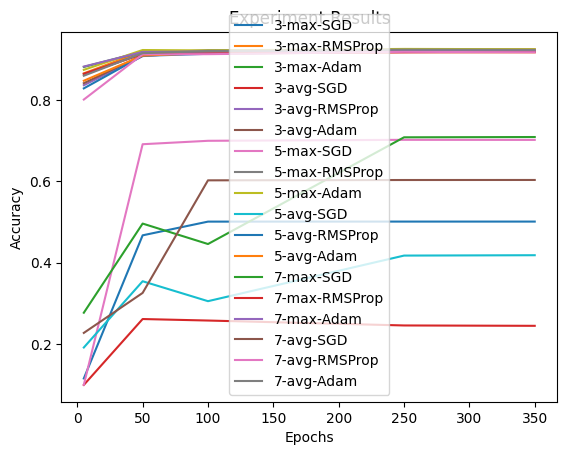

In [15]:
# 7. Visualize Results
for (kernel_size, pooling_type, opt_name), accuracies in results.items():
    plt.plot(num_epochs_list[:len(accuracies)], accuracies, label=f"{kernel_size}-{pooling_type}-{opt_name}")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Experiment Results")
plt.legend()
plt.show()